In [1]:
#needed after restructuring of directory
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
# change directory to src so that we can import functions
os.chdir(os.path.join("..","..",".."))
from functions import *
# back to repo root
os.chdir("..")

In [107]:
#importing csv fight data and saving as dataframes
ufc_fights = pd.read_csv('src/models/buildingMLModel/data/processed/ufc_fights.csv',low_memory=False)
ufcfighterscrap =pd.read_csv('src/models/buildingMLModel/data/processed/fighter_stats.csv',sep=',',low_memory=False)
#cleaning the methods column for method prediction (counting split decisions as decisions)
ufc_fights['method'] = clean_method_vect(ufc_fights['method'])
#getting rid of rows with incomplete or useless data
#fights with outcome "Win" or "Loss" (no "Draw")
draw_mask=ufc_fights['result'] != 'D' 
#fights where the method of victory is TKO/SUB/DEC (no bullshit)
method_mask=(ufc_fights['method']=='DEC')|(ufc_fights['method']=='SUB')|(ufc_fights['method']=='KO/TKO')
#fights where age is known
age_mask=(ufc_fights['fighter_age']!='unknown')&(ufc_fights['opponent_age']!='unknown')
#fights where height reach is known
height_mask=(ufc_fights['fighter_height']!='unknown')&(ufc_fights['opponent_height']!='unknown')
reach_mask=(ufc_fights['fighter_reach']!='unknown')&(ufc_fights['opponent_reach']!='unknown')
#fights where number of wins is known
wins_mask=(ufc_fights['fighter_wins'] != 'unknown' )& (ufc_fights['opponent_wins'] != 'unknown')
#fights where both fighters have strike statistics (gets rid of UFC debuts)
strikes_mask=(ufc_fights['fighter_inf_sig_strikes_attempts_avg'] != 0)&(ufc_fights['opponent_inf_sig_strikes_attempts_avg'] != 0)
#includes only the fights satisfying these conditions
ufc_fights=ufc_fights[draw_mask&method_mask&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]

record_statistics=[u'fighter_wins', u'fighter_losses',u'fighter_L5Y_wins',u'fighter_L5Y_losses', u'fighter_L2Y_wins', u'fighter_L2Y_losses', u'fighter_ko_wins',u'fighter_ko_losses',u'fighter_L5Y_ko_wins',u'fighter_L5Y_ko_losses',u'fighter_L2Y_ko_wins', u'fighter_L2Y_ko_losses',u'fighter_sub_wins',u'fighter_sub_losses',u'fighter_L5Y_sub_wins', u'fighter_L5Y_sub_losses', u'fighter_L2Y_sub_wins', u'fighter_L2Y_sub_losses',u'opponent_wins', u'opponent_losses',u'opponent_L5Y_wins', u'opponent_L5Y_losses', u'opponent_L2Y_wins', u'opponent_L2Y_losses',  u'opponent_ko_wins', u'opponent_ko_losses', u'opponent_L5Y_ko_wins', u'opponent_L5Y_ko_losses', u'opponent_L2Y_ko_wins', u'opponent_L2Y_ko_losses', u'opponent_sub_wins', u'opponent_sub_losses',u'opponent_L5Y_sub_wins',  u'opponent_L5Y_sub_losses', u'opponent_L2Y_sub_wins', u'opponent_L2Y_sub_losses']
physical_stats=[ u'fighter_age',u'fighter_height',    u'fighter_reach',  u'opponent_age',  u'opponent_height', u'opponent_reach']
punch_statistics=[ u'fighter_inf_knockdowns_avg',u'fighter_inf_pass_avg',u'fighter_inf_reversals_avg',u'fighter_inf_sub_attempts_avg',u'fighter_inf_takedowns_landed_avg',u'fighter_inf_takedowns_attempts_avg',u'fighter_inf_sig_strikes_landed_avg',u'fighter_inf_sig_strikes_attempts_avg',u'fighter_inf_total_strikes_landed_avg',u'fighter_inf_total_strikes_attempts_avg',u'fighter_inf_head_strikes_landed_avg',u'fighter_inf_head_strikes_attempts_avg',u'fighter_inf_body_strikes_landed_avg',u'fighter_inf_body_strikes_attempts_avg',u'fighter_inf_leg_strikes_landed_avg',u'fighter_inf_leg_strikes_attempts_avg',u'fighter_inf_distance_strikes_landed_avg',u'fighter_inf_distance_strikes_attempts_avg',u'fighter_inf_clinch_strikes_landed_avg',u'fighter_inf_clinch_strikes_attempts_avg',u'fighter_inf_ground_strikes_landed_avg',u'fighter_inf_ground_strikes_attempts_avg',u'fighter_abs_knockdowns_avg',u'fighter_abs_pass_avg',u'fighter_abs_reversals_avg',u'fighter_abs_sub_attempts_avg',u'fighter_abs_takedowns_landed_avg',u'fighter_abs_takedowns_attempts_avg',u'fighter_abs_sig_strikes_landed_avg',u'fighter_abs_sig_strikes_attempts_avg',u'fighter_abs_total_strikes_landed_avg',u'fighter_abs_total_strikes_attempts_avg',u'fighter_abs_head_strikes_landed_avg',u'fighter_abs_head_strikes_attempts_avg',u'fighter_abs_body_strikes_landed_avg',u'fighter_abs_body_strikes_attempts_avg',u'fighter_abs_leg_strikes_landed_avg',u'fighter_abs_leg_strikes_attempts_avg',u'fighter_abs_distance_strikes_landed_avg',u'fighter_abs_distance_strikes_attempts_avg',u'fighter_abs_clinch_strikes_landed_avg',u'fighter_abs_clinch_strikes_attempts_avg',u'fighter_abs_ground_strikes_landed_avg',u'fighter_abs_ground_strikes_attempts_avg',u'opponent_inf_knockdowns_avg',u'opponent_inf_pass_avg',u'opponent_inf_reversals_avg',u'opponent_inf_sub_attempts_avg',u'opponent_inf_takedowns_landed_avg',u'opponent_inf_takedowns_attempts_avg',u'opponent_inf_sig_strikes_landed_avg',u'opponent_inf_sig_strikes_attempts_avg',u'opponent_inf_total_strikes_landed_avg',u'opponent_inf_total_strikes_attempts_avg',u'opponent_inf_head_strikes_landed_avg',u'opponent_inf_head_strikes_attempts_avg',u'opponent_inf_body_strikes_landed_avg',u'opponent_inf_body_strikes_attempts_avg',u'opponent_inf_leg_strikes_landed_avg',u'opponent_inf_leg_strikes_attempts_avg',u'opponent_inf_distance_strikes_landed_avg',u'opponent_inf_distance_strikes_attempts_avg',u'opponent_inf_clinch_strikes_landed_avg',u'opponent_inf_clinch_strikes_attempts_avg',u'opponent_inf_ground_strikes_landed_avg',u'opponent_inf_ground_strikes_attempts_avg',u'opponent_abs_knockdowns_avg',u'opponent_abs_pass_avg',u'opponent_abs_reversals_avg',u'opponent_abs_sub_attempts_avg',u'opponent_abs_takedowns_landed_avg',u'opponent_abs_takedowns_attempts_avg',u'opponent_abs_sig_strikes_landed_avg',u'opponent_abs_sig_strikes_attempts_avg',u'opponent_abs_total_strikes_landed_avg',u'opponent_abs_total_strikes_attempts_avg',u'opponent_abs_head_strikes_landed_avg',u'opponent_abs_head_strikes_attempts_avg',u'opponent_abs_body_strikes_landed_avg',u'opponent_abs_body_strikes_attempts_avg',u'opponent_abs_leg_strikes_landed_avg',u'opponent_abs_leg_strikes_attempts_avg',u'opponent_abs_distance_strikes_landed_avg',u'opponent_abs_distance_strikes_attempts_avg',u'opponent_abs_clinch_strikes_landed_avg',u'opponent_abs_clinch_strikes_attempts_avg',u'opponent_abs_ground_strikes_landed_avg',u'opponent_abs_ground_strikes_attempts_avg']

#here is the version of punch stats geared for comparing fighter_inf to opponent_abs

fight_math_stats=['4-fighter_score_diff','9-fighter_score_diff','15-fighter_score_diff','1-fight_math','6-fight_math',]

#adding record differences to ufc_fights
record_statistics_diff = []
half_length=int(len(record_statistics)/2)
for i in range(half_length):
    ufc_fights[record_statistics[i]+'_diff_2']=ufc_fights[record_statistics[i]]-ufc_fights[record_statistics[i+half_length]]
    record_statistics_diff.append(record_statistics[i]+'_diff_2')
    
ufc_fights['fighter_age'] = ufc_fights['fighter_age'].apply(float)
ufc_fights['opponent_age'] = ufc_fights['opponent_age'].apply(float)

#lets try and improve the greedy algorithm by considering differences. Lets start by replacing height and reach by their differences
ufc_fights['height_diff']=ufc_fights['fighter_height'].apply(float)-ufc_fights['opponent_height'].apply(float)
ufc_fights['reach_diff']=ufc_fights['fighter_reach'].apply(float)-ufc_fights['opponent_reach'].apply(float)
ufc_fights['fighter_age_diff'] = ufc_fights['fighter_age']-ufc_fights['opponent_age']

physical_stats_diff = [ 'fighter_age','opponent_age', 'fighter_age_diff', 'height_diff', 'reach_diff']

#adding punch differences to ufc_fights
punch_statistics_diff = []
half_length=int(len(punch_statistics)/2)
for i in range(half_length):
    ufc_fights[punch_statistics[i]+'_diff_2']=ufc_fights[punch_statistics[i]]-ufc_fights[punch_statistics[i+half_length]]
    punch_statistics_diff.append(punch_statistics[i]+'_diff_2')
    
possible_stats =record_statistics_diff+physical_stats_diff+punch_statistics_diff+fight_math_stats

In [108]:
ufc_fights = ufc_fights.dropna(subset=possible_stats)

In [109]:
# Create tensors to input into neural net
Xr=ufc_fights[possible_stats]
yr = ufc_fights['result'].to_numpy().reshape(-1,1)

# Normalize Xr to have mean 0 and std 1
Xr_mean = Xr.mean()
Xr_std = Xr.std()
Xr_normalized=(Xr-Xr_mean)/Xr_std

# One-hot encode yr so 
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False).fit(yr)
yr_onehot = ohe.transform(yr)

# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
Xr_normalized = torch.tensor(Xr_normalized.values, dtype=torch.float32)
yr_onehot = torch.tensor(yr_onehot, dtype=torch.float32)

In [110]:
yr_onehot

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]])

In [111]:
# shows which labels correspond to which methods
method_0 = ohe.inverse_transform(np.array([[1,0]]))[0,0]
method_1 = ohe.inverse_transform(np.array([[0,1]]))[0,0]
print(f'label: 0 <-----> method: {method_0} <-----> [1,0]')
print(f'label: 1 <-----> method: {method_1} <-----> [0,1]')

label: 0 <-----> method: L <-----> [1,0]
label: 1 <-----> method: W <-----> [0,1]


In [112]:
Xr_normalized.shape, yr_onehot.shape

(torch.Size([4572, 72]), torch.Size([4572, 2]))

In [113]:
y_labeled = torch.argmax(yr_onehot, 1).reshape(-1,1).float()
y_labeled

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [120]:
# Defining parameters
lr_ = 0.00005                    # learning rate (default: 1e-3)
betas_ = (0.9, 0.999)           # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
eps_ = 1e-08                    # term added to the denominator to improve numerical stability (default: 1e-8)
weight_decay_ = 0               # weight decay (L2 penalty) (default: 0)
num_neurons_ = 120              # number of neurons in hidden layer (default: 100)

In [121]:
# using https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/
# but trying to get logsoftmax to work
class Multiclass(nn.Module):
    def __init__(self, num_features, num_neurons):
        super().__init__()
        self.hidden = nn.Linear(num_features, num_neurons)
        self.relu = nn.ReLU()
        self.output = nn.Linear(num_neurons, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
# defining the learning model
model = Multiclass(Xr_normalized.shape[1], num_neurons_)

#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr_, betas=betas_, eps=eps_, weight_decay=weight_decay_)

In [122]:
model(Xr_normalized[0,:])

tensor([0.5483], grad_fn=<SigmoidBackward0>)

In [123]:
y_labeled[0]

tensor([0.])

In [124]:
loss_fn(model(Xr_normalized[0,:]), y_labeled[0])

tensor(0.7947, grad_fn=<BinaryCrossEntropyBackward0>)

In [125]:
# real training loop
import copy
import tqdm
import numpy as np

# split
X_train, X_test, y_train, y_test = train_test_split(Xr_normalized, y_labeled, train_size=0.7, shuffle=True)

n_epochs = 500
batch_size = 250
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (((y_pred>.5)&(y_batch==1))|((y_pred<=.5)&(y_batch==0))).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (((y_pred>.5)&(y_test==1))|((y_pred<=.5)&(y_test==0))).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: binary cross entropy loss={ce}, Accuracy={acc}")
    
model.load_state_dict(best_weights)

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 203.39batch/s, acc=0.472, loss=0.7]


Epoch 0 validation: binary cross entropy loss=0.6962948441505432, Accuracy=0.49125364422798157


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.468, loss=0.698]


Epoch 1 validation: binary cross entropy loss=0.6945106983184814, Accuracy=0.5021865963935852


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.48, loss=0.696]


Epoch 2 validation: binary cross entropy loss=0.692825436592102, Accuracy=0.5072886347770691


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 171.44batch/s, acc=0.5, loss=0.694]


Epoch 3 validation: binary cross entropy loss=0.6912453174591064, Accuracy=0.5167638659477234


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 176.48batch/s, acc=0.548, loss=0.693]


Epoch 4 validation: binary cross entropy loss=0.6897608637809753, Accuracy=0.5255101919174194


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.544, loss=0.691]


Epoch 5 validation: binary cross entropy loss=0.6883653998374939, Accuracy=0.532069981098175


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 162.17batch/s, acc=0.548, loss=0.689]


Epoch 6 validation: binary cross entropy loss=0.6870527863502502, Accuracy=0.545918345451355


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.528, loss=0.688]


Epoch 7 validation: binary cross entropy loss=0.685818612575531, Accuracy=0.5488338470458984


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 164.38batch/s, acc=0.544, loss=0.687]


Epoch 8 validation: binary cross entropy loss=0.6846581101417542, Accuracy=0.556851327419281


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.56, loss=0.685]


Epoch 9 validation: binary cross entropy loss=0.6835606694221497, Accuracy=0.5634110569953918


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.568, loss=0.684]


Epoch 10 validation: binary cross entropy loss=0.6825259327888489, Accuracy=0.5677842497825623


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.564, loss=0.683]


Epoch 11 validation: binary cross entropy loss=0.6815509796142578, Accuracy=0.5706996917724609


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 160.00batch/s, acc=0.544, loss=0.682]


Epoch 12 validation: binary cross entropy loss=0.6806294918060303, Accuracy=0.5772594809532166


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.552, loss=0.681]


Epoch 13 validation: binary cross entropy loss=0.6797557473182678, Accuracy=0.5772594809532166


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.556, loss=0.68]


Epoch 14 validation: binary cross entropy loss=0.678927481174469, Accuracy=0.5787171721458435


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.556, loss=0.679]


Epoch 15 validation: binary cross entropy loss=0.678141176700592, Accuracy=0.5758017301559448


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.572, loss=0.678]


Epoch 16 validation: binary cross entropy loss=0.6773934364318848, Accuracy=0.5772594809532166


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.58, loss=0.677]


Epoch 17 validation: binary cross entropy loss=0.676683247089386, Accuracy=0.5787171721458435


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.584, loss=0.676]


Epoch 18 validation: binary cross entropy loss=0.6760082840919495, Accuracy=0.5845481157302856


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.588, loss=0.676]


Epoch 19 validation: binary cross entropy loss=0.6753671169281006, Accuracy=0.5852769613265991


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.584, loss=0.675]


Epoch 20 validation: binary cross entropy loss=0.6747559905052185, Accuracy=0.5845481157302856


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.588, loss=0.674]


Epoch 21 validation: binary cross entropy loss=0.6741732358932495, Accuracy=0.5867347121238708


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.592, loss=0.673]


Epoch 22 validation: binary cross entropy loss=0.6736168265342712, Accuracy=0.5896501541137695


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.592, loss=0.673]


Epoch 23 validation: binary cross entropy loss=0.67308509349823, Accuracy=0.590378999710083


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.592, loss=0.672]


Epoch 24 validation: binary cross entropy loss=0.6725790500640869, Accuracy=0.5918367505073547


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.592, loss=0.671]


Epoch 25 validation: binary cross entropy loss=0.6720963716506958, Accuracy=0.5911078453063965


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.6, loss=0.671]


Epoch 26 validation: binary cross entropy loss=0.6716356873512268, Accuracy=0.5940233469009399


Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.596, loss=0.67]


Epoch 27 validation: binary cross entropy loss=0.6711965203285217, Accuracy=0.5911078453063965


Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 121.21batch/s, acc=0.592, loss=0.67]


Epoch 28 validation: binary cross entropy loss=0.6707771420478821, Accuracy=0.5947521924972534


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.592, loss=0.669]


Epoch 29 validation: binary cross entropy loss=0.670376718044281, Accuracy=0.5954810380935669


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.6, loss=0.669]


Epoch 30 validation: binary cross entropy loss=0.6699941158294678, Accuracy=0.5940233469009399


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.596, loss=0.668]


Epoch 31 validation: binary cross entropy loss=0.6696273684501648, Accuracy=0.5947521924972534


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.596, loss=0.667]


Epoch 32 validation: binary cross entropy loss=0.6692751049995422, Accuracy=0.5969387888908386


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.596, loss=0.667]


Epoch 33 validation: binary cross entropy loss=0.6689380407333374, Accuracy=0.5983964800834656


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.596, loss=0.666]


Epoch 34 validation: binary cross entropy loss=0.6686148643493652, Accuracy=0.5983964800834656


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.596, loss=0.666]


Epoch 35 validation: binary cross entropy loss=0.6683068871498108, Accuracy=0.5998542308807373


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.588, loss=0.665]


Epoch 36 validation: binary cross entropy loss=0.6680111289024353, Accuracy=0.5991253852844238


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.592, loss=0.665]


Epoch 37 validation: binary cross entropy loss=0.6677289009094238, Accuracy=0.601311981678009


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.592, loss=0.665]


Epoch 38 validation: binary cross entropy loss=0.6674576997756958, Accuracy=0.6005830764770508


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.596, loss=0.664]


Epoch 39 validation: binary cross entropy loss=0.6671956777572632, Accuracy=0.6020408272743225


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.592, loss=0.664]


Epoch 40 validation: binary cross entropy loss=0.6669424772262573, Accuracy=0.602769672870636


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.596, loss=0.663]


Epoch 41 validation: binary cross entropy loss=0.6666983366012573, Accuracy=0.602769672870636


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.36batch/s, acc=0.596, loss=0.663]


Epoch 42 validation: binary cross entropy loss=0.6664636731147766, Accuracy=0.6020408272743225


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.6, loss=0.662]


Epoch 43 validation: binary cross entropy loss=0.6662368774414062, Accuracy=0.6020408272743225


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.53batch/s, acc=0.604, loss=0.662]


Epoch 44 validation: binary cross entropy loss=0.6660174131393433, Accuracy=0.6042274236679077


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 110.09batch/s, acc=0.604, loss=0.661]


Epoch 45 validation: binary cross entropy loss=0.6658056378364563, Accuracy=0.6042274236679077


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 114.29batch/s, acc=0.608, loss=0.661]


Epoch 46 validation: binary cross entropy loss=0.6656014323234558, Accuracy=0.6034985184669495


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 125.00batch/s, acc=0.608, loss=0.661]


Epoch 47 validation: binary cross entropy loss=0.6654048562049866, Accuracy=0.6042274236679077


Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 122.45batch/s, acc=0.608, loss=0.66]


Epoch 48 validation: binary cross entropy loss=0.6652169823646545, Accuracy=0.6034985184669495


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.608, loss=0.66]


Epoch 49 validation: binary cross entropy loss=0.6650370955467224, Accuracy=0.6042274236679077


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.608, loss=0.66]


Epoch 50 validation: binary cross entropy loss=0.6648638844490051, Accuracy=0.6042274236679077


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.608, loss=0.659]


Epoch 51 validation: binary cross entropy loss=0.6646974086761475, Accuracy=0.6042274236679077


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.608, loss=0.659]


Epoch 52 validation: binary cross entropy loss=0.6645370125770569, Accuracy=0.6049562692642212


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.608, loss=0.658]


Epoch 53 validation: binary cross entropy loss=0.6643810868263245, Accuracy=0.6042274236679077


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.608, loss=0.658]


Epoch 54 validation: binary cross entropy loss=0.6642314791679382, Accuracy=0.6042274236679077


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.604, loss=0.658]


Epoch 55 validation: binary cross entropy loss=0.6640869379043579, Accuracy=0.602769672870636


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.604, loss=0.657]


Epoch 56 validation: binary cross entropy loss=0.6639463305473328, Accuracy=0.6020408272743225


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.608, loss=0.657]


Epoch 57 validation: binary cross entropy loss=0.6638104915618896, Accuracy=0.6042274236679077


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.608, loss=0.657]


Epoch 58 validation: binary cross entropy loss=0.6636788249015808, Accuracy=0.6034985184669495


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.612, loss=0.656]


Epoch 59 validation: binary cross entropy loss=0.6635524034500122, Accuracy=0.6049562692642212


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.612, loss=0.656]


Epoch 60 validation: binary cross entropy loss=0.6634289026260376, Accuracy=0.6056851148605347


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.608, loss=0.656]


Epoch 61 validation: binary cross entropy loss=0.6633103489875793, Accuracy=0.6071428656578064


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.604, loss=0.655]


Epoch 62 validation: binary cross entropy loss=0.6631960868835449, Accuracy=0.6086005568504333


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.604, loss=0.655]


Epoch 63 validation: binary cross entropy loss=0.6630862951278687, Accuracy=0.6078717112541199


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 125.00batch/s, acc=0.604, loss=0.655]


Epoch 64 validation: binary cross entropy loss=0.662980854511261, Accuracy=0.6056851148605347


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 122.45batch/s, acc=0.604, loss=0.654]


Epoch 65 validation: binary cross entropy loss=0.662880003452301, Accuracy=0.6064140200614929


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 111.11batch/s, acc=0.604, loss=0.654]


Epoch 66 validation: binary cross entropy loss=0.6627833843231201, Accuracy=0.6064140200614929


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 116.50batch/s, acc=0.604, loss=0.654]


Epoch 67 validation: binary cross entropy loss=0.6626899838447571, Accuracy=0.6086005568504333


Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 100.84batch/s, acc=0.6, loss=0.653]


Epoch 68 validation: binary cross entropy loss=0.6626001596450806, Accuracy=0.6078717112541199


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.596, loss=0.653]


Epoch 69 validation: binary cross entropy loss=0.6625136137008667, Accuracy=0.6056851148605347


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.596, loss=0.653]


Epoch 70 validation: binary cross entropy loss=0.662429928779602, Accuracy=0.6056851148605347


Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.88batch/s, acc=0.6, loss=0.653]


Epoch 71 validation: binary cross entropy loss=0.6623485088348389, Accuracy=0.6064140200614929


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 123.72batch/s, acc=0.596, loss=0.652]


Epoch 72 validation: binary cross entropy loss=0.6622699499130249, Accuracy=0.6064140200614929


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.6, loss=0.652]


Epoch 73 validation: binary cross entropy loss=0.6621942520141602, Accuracy=0.6064140200614929


Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.6, loss=0.652]


Epoch 74 validation: binary cross entropy loss=0.662120521068573, Accuracy=0.6056851148605347


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.604, loss=0.651]


Epoch 75 validation: binary cross entropy loss=0.662049412727356, Accuracy=0.6049562692642212


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.608, loss=0.651]


Epoch 76 validation: binary cross entropy loss=0.6619808673858643, Accuracy=0.6049562692642212


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.608, loss=0.651]


Epoch 77 validation: binary cross entropy loss=0.6619142293930054, Accuracy=0.6056851148605347


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.612, loss=0.651]


Epoch 78 validation: binary cross entropy loss=0.6618492007255554, Accuracy=0.6064140200614929


Epoch 79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.616, loss=0.65]


Epoch 79 validation: binary cross entropy loss=0.6617859601974487, Accuracy=0.6078717112541199


Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.616, loss=0.65]


Epoch 80 validation: binary cross entropy loss=0.6617258787155151, Accuracy=0.6078717112541199


Epoch 81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.616, loss=0.65]


Epoch 81 validation: binary cross entropy loss=0.661668062210083, Accuracy=0.6086005568504333


Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.616, loss=0.65]


Epoch 82 validation: binary cross entropy loss=0.6616126894950867, Accuracy=0.6086005568504333


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.612, loss=0.649]


Epoch 83 validation: binary cross entropy loss=0.6615587472915649, Accuracy=0.6078717112541199


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.53batch/s, acc=0.616, loss=0.649]


Epoch 84 validation: binary cross entropy loss=0.6615070104598999, Accuracy=0.6078717112541199


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.616, loss=0.649]


Epoch 85 validation: binary cross entropy loss=0.661457896232605, Accuracy=0.6078717112541199


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.616, loss=0.649]


Epoch 86 validation: binary cross entropy loss=0.6614103317260742, Accuracy=0.6093294620513916


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.616, loss=0.648]


Epoch 87 validation: binary cross entropy loss=0.6613637208938599, Accuracy=0.6071428656578064


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.616, loss=0.648]


Epoch 88 validation: binary cross entropy loss=0.6613202095031738, Accuracy=0.6049562692642212


Epoch 89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.62, loss=0.648]


Epoch 89 validation: binary cross entropy loss=0.6612801551818848, Accuracy=0.6056851148605347


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.628, loss=0.648]


Epoch 90 validation: binary cross entropy loss=0.6612422466278076, Accuracy=0.6056851148605347


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 129.03batch/s, acc=0.628, loss=0.647]


Epoch 91 validation: binary cross entropy loss=0.6612061262130737, Accuracy=0.6049562692642212


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.628, loss=0.647]


Epoch 92 validation: binary cross entropy loss=0.6611722111701965, Accuracy=0.6034985184669495


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.628, loss=0.647]


Epoch 93 validation: binary cross entropy loss=0.6611411571502686, Accuracy=0.6034985184669495


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.632, loss=0.647]


Epoch 94 validation: binary cross entropy loss=0.6611102819442749, Accuracy=0.6042274236679077


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.632, loss=0.647]


Epoch 95 validation: binary cross entropy loss=0.6610809564590454, Accuracy=0.6042274236679077


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.646]


Epoch 96 validation: binary cross entropy loss=0.6610527634620667, Accuracy=0.6034985184669495


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.632, loss=0.646]


Epoch 97 validation: binary cross entropy loss=0.6610264182090759, Accuracy=0.6034985184669495


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.646]


Epoch 98 validation: binary cross entropy loss=0.6610020399093628, Accuracy=0.602769672870636


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.88batch/s, acc=0.632, loss=0.646]


Epoch 99 validation: binary cross entropy loss=0.6609788537025452, Accuracy=0.602769672870636


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.632, loss=0.645]


Epoch 100 validation: binary cross entropy loss=0.6609580516815186, Accuracy=0.602769672870636


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.645]


Epoch 101 validation: binary cross entropy loss=0.6609389781951904, Accuracy=0.602769672870636


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.632, loss=0.645]


Epoch 102 validation: binary cross entropy loss=0.660921573638916, Accuracy=0.602769672870636


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.632, loss=0.645]


Epoch 103 validation: binary cross entropy loss=0.6609062552452087, Accuracy=0.6020408272743225


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.632, loss=0.645]


Epoch 104 validation: binary cross entropy loss=0.6608926057815552, Accuracy=0.601311981678009


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.632, loss=0.644]


Epoch 105 validation: binary cross entropy loss=0.6608803868293762, Accuracy=0.601311981678009


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.644]


Epoch 106 validation: binary cross entropy loss=0.6608694195747375, Accuracy=0.6005830764770508


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.632, loss=0.644]


Epoch 107 validation: binary cross entropy loss=0.6608607172966003, Accuracy=0.5998542308807373


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.636, loss=0.644]


Epoch 108 validation: binary cross entropy loss=0.6608542799949646, Accuracy=0.5998542308807373


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.36batch/s, acc=0.636, loss=0.644]


Epoch 109 validation: binary cross entropy loss=0.6608471274375916, Accuracy=0.6005830764770508


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.643]


Epoch 110 validation: binary cross entropy loss=0.6608418822288513, Accuracy=0.601311981678009


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.636, loss=0.643]


Epoch 111 validation: binary cross entropy loss=0.6608376502990723, Accuracy=0.601311981678009


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.636, loss=0.643]


Epoch 112 validation: binary cross entropy loss=0.660835325717926, Accuracy=0.6005830764770508


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.643]


Epoch 113 validation: binary cross entropy loss=0.6608337163925171, Accuracy=0.6005830764770508


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.643]


Epoch 114 validation: binary cross entropy loss=0.6608331203460693, Accuracy=0.5998542308807373


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.85batch/s, acc=0.636, loss=0.642]


Epoch 115 validation: binary cross entropy loss=0.6608321666717529, Accuracy=0.5998542308807373


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.86batch/s, acc=0.636, loss=0.642]


Epoch 116 validation: binary cross entropy loss=0.6608319878578186, Accuracy=0.5998542308807373


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.642]


Epoch 117 validation: binary cross entropy loss=0.6608313322067261, Accuracy=0.6005830764770508


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.636, loss=0.642]


Epoch 118 validation: binary cross entropy loss=0.6608306765556335, Accuracy=0.6005830764770508


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.636, loss=0.642]


Epoch 119 validation: binary cross entropy loss=0.6608302593231201, Accuracy=0.5998542308807373


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.636, loss=0.641]


Epoch 120 validation: binary cross entropy loss=0.6608301997184753, Accuracy=0.6005830764770508


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.636, loss=0.641]


Epoch 121 validation: binary cross entropy loss=0.6608313918113708, Accuracy=0.5998542308807373


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 109.10batch/s, acc=0.636, loss=0.641]


Epoch 122 validation: binary cross entropy loss=0.660834550857544, Accuracy=0.5998542308807373


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.641]


Epoch 123 validation: binary cross entropy loss=0.6608388423919678, Accuracy=0.5998542308807373


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.636, loss=0.641]


Epoch 124 validation: binary cross entropy loss=0.6608426570892334, Accuracy=0.6005830764770508


Epoch 125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.64, loss=0.64]


Epoch 125 validation: binary cross entropy loss=0.6608464121818542, Accuracy=0.5998542308807373


Epoch 126: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.644, loss=0.64]


Epoch 126 validation: binary cross entropy loss=0.6608518362045288, Accuracy=0.6005830764770508


Epoch 127: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.644, loss=0.64]


Epoch 127 validation: binary cross entropy loss=0.6608568429946899, Accuracy=0.5998542308807373


Epoch 128: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.644, loss=0.64]


Epoch 128 validation: binary cross entropy loss=0.6608633399009705, Accuracy=0.5998542308807373


Epoch 129: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.644, loss=0.64]


Epoch 129 validation: binary cross entropy loss=0.6608704328536987, Accuracy=0.5998542308807373


Epoch 130: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.644, loss=0.64]


Epoch 130 validation: binary cross entropy loss=0.6608766317367554, Accuracy=0.6005830764770508


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.644, loss=0.639]


Epoch 131 validation: binary cross entropy loss=0.6608831882476807, Accuracy=0.601311981678009


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.644, loss=0.639]


Epoch 132 validation: binary cross entropy loss=0.6608903408050537, Accuracy=0.6005830764770508


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.644, loss=0.639]


Epoch 133 validation: binary cross entropy loss=0.6608974933624268, Accuracy=0.6005830764770508


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.644, loss=0.639]


Epoch 134 validation: binary cross entropy loss=0.660906195640564, Accuracy=0.5998542308807373


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.648, loss=0.639]


Epoch 135 validation: binary cross entropy loss=0.6609156131744385, Accuracy=0.6005830764770508


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.53batch/s, acc=0.648, loss=0.638]


Epoch 136 validation: binary cross entropy loss=0.6609250903129578, Accuracy=0.5998542308807373


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.648, loss=0.638]


Epoch 137 validation: binary cross entropy loss=0.6609358191490173, Accuracy=0.5998542308807373


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.17batch/s, acc=0.648, loss=0.638]


Epoch 138 validation: binary cross entropy loss=0.6609483957290649, Accuracy=0.5998542308807373


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.648, loss=0.638]


Epoch 139 validation: binary cross entropy loss=0.6609618663787842, Accuracy=0.5998542308807373


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.648, loss=0.638]


Epoch 140 validation: binary cross entropy loss=0.6609756946563721, Accuracy=0.5998542308807373


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.648, loss=0.637]


Epoch 141 validation: binary cross entropy loss=0.6609909534454346, Accuracy=0.5991253852844238


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.648, loss=0.637]


Epoch 142 validation: binary cross entropy loss=0.6610073447227478, Accuracy=0.5991253852844238


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.648, loss=0.637]


Epoch 143 validation: binary cross entropy loss=0.6610250473022461, Accuracy=0.5983964800834656


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.648, loss=0.637]


Epoch 144 validation: binary cross entropy loss=0.6610446572303772, Accuracy=0.5991253852844238


Epoch 145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.648, loss=0.637]


Epoch 145 validation: binary cross entropy loss=0.6610638499259949, Accuracy=0.5983964800834656


Epoch 146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.644, loss=0.637]


Epoch 146 validation: binary cross entropy loss=0.6610835790634155, Accuracy=0.5976676344871521


Epoch 147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.644, loss=0.636]


Epoch 147 validation: binary cross entropy loss=0.6611034274101257, Accuracy=0.5969387888908386


Epoch 148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.644, loss=0.636]


Epoch 148 validation: binary cross entropy loss=0.6611239910125732, Accuracy=0.5969387888908386


Epoch 149: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.64, loss=0.636]


Epoch 149 validation: binary cross entropy loss=0.6611432433128357, Accuracy=0.5976676344871521


Epoch 150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.64, loss=0.636]


Epoch 150 validation: binary cross entropy loss=0.6611642241477966, Accuracy=0.5991253852844238


Epoch 151: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.64, loss=0.636]


Epoch 151 validation: binary cross entropy loss=0.661186158657074, Accuracy=0.5998542308807373


Epoch 152: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.64, loss=0.635]

Epoch 152 validation: binary cross entropy loss=0.6612093448638916, Accuracy=0.5991253852844238



Epoch 153: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.64, loss=0.635]


Epoch 153 validation: binary cross entropy loss=0.6612316370010376, Accuracy=0.5991253852844238


Epoch 154: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.64, loss=0.635]


Epoch 154 validation: binary cross entropy loss=0.6612530946731567, Accuracy=0.5991253852844238


Epoch 155: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.64, loss=0.635]


Epoch 155 validation: binary cross entropy loss=0.661274790763855, Accuracy=0.5991253852844238


Epoch 156: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.64, loss=0.635]


Epoch 156 validation: binary cross entropy loss=0.6612991690635681, Accuracy=0.5991253852844238


Epoch 157: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.64, loss=0.635]


Epoch 157 validation: binary cross entropy loss=0.6613239049911499, Accuracy=0.5998542308807373


Epoch 158: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.644, loss=0.634]


Epoch 158 validation: binary cross entropy loss=0.6613488793373108, Accuracy=0.5998542308807373


Epoch 159: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.644, loss=0.634]


Epoch 159 validation: binary cross entropy loss=0.6613775491714478, Accuracy=0.6005830764770508


Epoch 160: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.656, loss=0.634]


Epoch 160 validation: binary cross entropy loss=0.6614066362380981, Accuracy=0.601311981678009


Epoch 161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.656, loss=0.634]


Epoch 161 validation: binary cross entropy loss=0.6614364981651306, Accuracy=0.6005830764770508


Epoch 162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.656, loss=0.634]


Epoch 162 validation: binary cross entropy loss=0.6614677309989929, Accuracy=0.6005830764770508


Epoch 163: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.656, loss=0.633]


Epoch 163 validation: binary cross entropy loss=0.6614982485771179, Accuracy=0.6020408272743225


Epoch 164: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 129.03batch/s, acc=0.656, loss=0.633]


Epoch 164 validation: binary cross entropy loss=0.6615281701087952, Accuracy=0.602769672870636


Epoch 165: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.656, loss=0.633]


Epoch 165 validation: binary cross entropy loss=0.6615579128265381, Accuracy=0.6034985184669495


Epoch 166: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.656, loss=0.633]


Epoch 166 validation: binary cross entropy loss=0.6615860462188721, Accuracy=0.6042274236679077


Epoch 167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.656, loss=0.633]


Epoch 167 validation: binary cross entropy loss=0.6616148948669434, Accuracy=0.6042274236679077


Epoch 168: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.656, loss=0.633]


Epoch 168 validation: binary cross entropy loss=0.6616458892822266, Accuracy=0.6049562692642212


Epoch 169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.656, loss=0.632]


Epoch 169 validation: binary cross entropy loss=0.6616768836975098, Accuracy=0.6049562692642212


Epoch 170: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 120.00batch/s, acc=0.656, loss=0.632]


Epoch 170 validation: binary cross entropy loss=0.6617072820663452, Accuracy=0.6049562692642212


Epoch 171: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.656, loss=0.632]


Epoch 171 validation: binary cross entropy loss=0.661739706993103, Accuracy=0.6049562692642212


Epoch 172: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.656, loss=0.632]


Epoch 172 validation: binary cross entropy loss=0.6617725491523743, Accuracy=0.6049562692642212


Epoch 173: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.656, loss=0.632]


Epoch 173 validation: binary cross entropy loss=0.6618054509162903, Accuracy=0.6042274236679077


Epoch 174: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.656, loss=0.632]


Epoch 174 validation: binary cross entropy loss=0.6618393659591675, Accuracy=0.6056851148605347


Epoch 175: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.36batch/s, acc=0.66, loss=0.631]


Epoch 175 validation: binary cross entropy loss=0.6618740558624268, Accuracy=0.6064140200614929


Epoch 176: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.66, loss=0.631]


Epoch 176 validation: binary cross entropy loss=0.6619096994400024, Accuracy=0.6064140200614929


Epoch 177: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.43batch/s, acc=0.66, loss=0.631]


Epoch 177 validation: binary cross entropy loss=0.6619452834129333, Accuracy=0.6078717112541199


Epoch 178: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.66, loss=0.631]


Epoch 178 validation: binary cross entropy loss=0.6619822382926941, Accuracy=0.6086005568504333


Epoch 179: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.66, loss=0.631]


Epoch 179 validation: binary cross entropy loss=0.6620177626609802, Accuracy=0.6086005568504333


Epoch 180: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.86batch/s, acc=0.66, loss=0.631]

Epoch 180 validation: binary cross entropy loss=0.6620531678199768, Accuracy=0.6086005568504333



Epoch 181: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.66, loss=0.63]


Epoch 181 validation: binary cross entropy loss=0.6620897054672241, Accuracy=0.6064140200614929


Epoch 182: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.664, loss=0.63]


Epoch 182 validation: binary cross entropy loss=0.6621262431144714, Accuracy=0.6049562692642212


Epoch 183: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.664, loss=0.63]


Epoch 183 validation: binary cross entropy loss=0.6621628999710083, Accuracy=0.6049562692642212


Epoch 184: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.668, loss=0.63]


Epoch 184 validation: binary cross entropy loss=0.6622001528739929, Accuracy=0.6034985184669495


Epoch 185: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.668, loss=0.63]


Epoch 185 validation: binary cross entropy loss=0.6622387170791626, Accuracy=0.6042274236679077


Epoch 186: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.668, loss=0.629]


Epoch 186 validation: binary cross entropy loss=0.6622792482376099, Accuracy=0.6034985184669495


Epoch 187: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.668, loss=0.629]


Epoch 187 validation: binary cross entropy loss=0.6623215079307556, Accuracy=0.6034985184669495


Epoch 188: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.84batch/s, acc=0.668, loss=0.629]


Epoch 188 validation: binary cross entropy loss=0.6623638868331909, Accuracy=0.6042274236679077


Epoch 189: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.668, loss=0.629]


Epoch 189 validation: binary cross entropy loss=0.6624074578285217, Accuracy=0.6034985184669495


Epoch 190: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.668, loss=0.629]


Epoch 190 validation: binary cross entropy loss=0.6624526977539062, Accuracy=0.6049562692642212


Epoch 191: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.668, loss=0.629]


Epoch 191 validation: binary cross entropy loss=0.662494957447052, Accuracy=0.6049562692642212


Epoch 192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 123.72batch/s, acc=0.668, loss=0.628]


Epoch 192 validation: binary cross entropy loss=0.66253662109375, Accuracy=0.6042274236679077


Epoch 193: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 126.32batch/s, acc=0.668, loss=0.628]


Epoch 193 validation: binary cross entropy loss=0.6625771522521973, Accuracy=0.6049562692642212


Epoch 194: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.668, loss=0.628]


Epoch 194 validation: binary cross entropy loss=0.662618100643158, Accuracy=0.6056851148605347


Epoch 195: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.668, loss=0.628]


Epoch 195 validation: binary cross entropy loss=0.6626619100570679, Accuracy=0.6064140200614929


Epoch 196: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.668, loss=0.628]


Epoch 196 validation: binary cross entropy loss=0.6627053022384644, Accuracy=0.6064140200614929


Epoch 197: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.668, loss=0.628]


Epoch 197 validation: binary cross entropy loss=0.6627492904663086, Accuracy=0.6056851148605347


Epoch 198: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.668, loss=0.627]


Epoch 198 validation: binary cross entropy loss=0.6627944707870483, Accuracy=0.6056851148605347


Epoch 199: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.668, loss=0.627]


Epoch 199 validation: binary cross entropy loss=0.6628397703170776, Accuracy=0.6056851148605347


Epoch 200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.668, loss=0.627]


Epoch 200 validation: binary cross entropy loss=0.6628866791725159, Accuracy=0.6049562692642212


Epoch 201: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.668, loss=0.627]


Epoch 201 validation: binary cross entropy loss=0.6629331111907959, Accuracy=0.6056851148605347


Epoch 202: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.668, loss=0.627]


Epoch 202 validation: binary cross entropy loss=0.6629778146743774, Accuracy=0.6056851148605347


Epoch 203: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.668, loss=0.627]


Epoch 203 validation: binary cross entropy loss=0.6630240082740784, Accuracy=0.6056851148605347


Epoch 204: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.668, loss=0.626]


Epoch 204 validation: binary cross entropy loss=0.6630690097808838, Accuracy=0.6056851148605347


Epoch 205: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.668, loss=0.626]


Epoch 205 validation: binary cross entropy loss=0.6631123423576355, Accuracy=0.6056851148605347


Epoch 206: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.668, loss=0.626]


Epoch 206 validation: binary cross entropy loss=0.66315758228302, Accuracy=0.6056851148605347


Epoch 207: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.668, loss=0.626]


Epoch 207 validation: binary cross entropy loss=0.6632033586502075, Accuracy=0.6056851148605347


Epoch 208: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.668, loss=0.626]


Epoch 208 validation: binary cross entropy loss=0.6632475852966309, Accuracy=0.6056851148605347


Epoch 209: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.668, loss=0.626]


Epoch 209 validation: binary cross entropy loss=0.6632925868034363, Accuracy=0.6056851148605347


Epoch 210: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.668, loss=0.625]


Epoch 210 validation: binary cross entropy loss=0.663335919380188, Accuracy=0.6056851148605347


Epoch 211: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.668, loss=0.625]


Epoch 211 validation: binary cross entropy loss=0.6633790731430054, Accuracy=0.6056851148605347


Epoch 212: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.668, loss=0.625]


Epoch 212 validation: binary cross entropy loss=0.663421094417572, Accuracy=0.6049562692642212


Epoch 213: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.668, loss=0.625]


Epoch 213 validation: binary cross entropy loss=0.6634624004364014, Accuracy=0.6049562692642212


Epoch 214: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.668, loss=0.625]


Epoch 214 validation: binary cross entropy loss=0.6635039448738098, Accuracy=0.6049562692642212


Epoch 215: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.668, loss=0.625]


Epoch 215 validation: binary cross entropy loss=0.6635449528694153, Accuracy=0.6049562692642212


Epoch 216: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 122.45batch/s, acc=0.668, loss=0.624]


Epoch 216 validation: binary cross entropy loss=0.6635851860046387, Accuracy=0.6042274236679077


Epoch 217: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.668, loss=0.624]


Epoch 217 validation: binary cross entropy loss=0.6636260151863098, Accuracy=0.6034985184669495


Epoch 218: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.668, loss=0.624]


Epoch 218 validation: binary cross entropy loss=0.6636638641357422, Accuracy=0.6034985184669495


Epoch 219: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.668, loss=0.624]


Epoch 219 validation: binary cross entropy loss=0.6637004017829895, Accuracy=0.6034985184669495


Epoch 220: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.668, loss=0.624]


Epoch 220 validation: binary cross entropy loss=0.6637399792671204, Accuracy=0.6056851148605347


Epoch 221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.668, loss=0.623]


Epoch 221 validation: binary cross entropy loss=0.6637802720069885, Accuracy=0.6056851148605347


Epoch 222: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.668, loss=0.623]


Epoch 222 validation: binary cross entropy loss=0.6638205051422119, Accuracy=0.6064140200614929


Epoch 223: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.668, loss=0.623]


Epoch 223 validation: binary cross entropy loss=0.6638599634170532, Accuracy=0.6071428656578064


Epoch 224: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.19batch/s, acc=0.668, loss=0.623]


Epoch 224 validation: binary cross entropy loss=0.6639007329940796, Accuracy=0.6064140200614929


Epoch 225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.668, loss=0.623]


Epoch 225 validation: binary cross entropy loss=0.6639420390129089, Accuracy=0.6064140200614929


Epoch 226: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.668, loss=0.623]


Epoch 226 validation: binary cross entropy loss=0.663985013961792, Accuracy=0.6078717112541199


Epoch 227: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.668, loss=0.622]


Epoch 227 validation: binary cross entropy loss=0.6640278100967407, Accuracy=0.6086005568504333


Epoch 228: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.17batch/s, acc=0.668, loss=0.622]


Epoch 228 validation: binary cross entropy loss=0.6640705466270447, Accuracy=0.6078717112541199


Epoch 229: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.668, loss=0.622]


Epoch 229 validation: binary cross entropy loss=0.6641132831573486, Accuracy=0.6071428656578064


Epoch 230: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.668, loss=0.622]


Epoch 230 validation: binary cross entropy loss=0.6641567349433899, Accuracy=0.6071428656578064


Epoch 231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.668, loss=0.622]


Epoch 231 validation: binary cross entropy loss=0.6641982197761536, Accuracy=0.6071428656578064


Epoch 232: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.668, loss=0.622]


Epoch 232 validation: binary cross entropy loss=0.6642411351203918, Accuracy=0.6064140200614929


Epoch 233: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.668, loss=0.621]


Epoch 233 validation: binary cross entropy loss=0.6642853021621704, Accuracy=0.6064140200614929


Epoch 234: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.668, loss=0.621]


Epoch 234 validation: binary cross entropy loss=0.6643282771110535, Accuracy=0.6071428656578064


Epoch 235: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.668, loss=0.621]


Epoch 235 validation: binary cross entropy loss=0.6643733382225037, Accuracy=0.6071428656578064


Epoch 236: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.668, loss=0.621]


Epoch 236 validation: binary cross entropy loss=0.664417564868927, Accuracy=0.6078717112541199


Epoch 237: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.668, loss=0.621]


Epoch 237 validation: binary cross entropy loss=0.6644607782363892, Accuracy=0.6086005568504333


Epoch 238: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.668, loss=0.621]


Epoch 238 validation: binary cross entropy loss=0.6645035743713379, Accuracy=0.6086005568504333


Epoch 239: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.668, loss=0.62]


Epoch 239 validation: binary cross entropy loss=0.6645488739013672, Accuracy=0.6078717112541199


Epoch 240: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.668, loss=0.62]


Epoch 240 validation: binary cross entropy loss=0.6645920276641846, Accuracy=0.6064140200614929


Epoch 241: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.672, loss=0.62]


Epoch 241 validation: binary cross entropy loss=0.6646350026130676, Accuracy=0.6078717112541199


Epoch 242: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.672, loss=0.62]


Epoch 242 validation: binary cross entropy loss=0.6646791696548462, Accuracy=0.6078717112541199


Epoch 243: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.17batch/s, acc=0.672, loss=0.62]


Epoch 243 validation: binary cross entropy loss=0.6647225618362427, Accuracy=0.6071428656578064


Epoch 244: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.672, loss=0.62]


Epoch 244 validation: binary cross entropy loss=0.664766788482666, Accuracy=0.6071428656578064


Epoch 245: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.672, loss=0.619]


Epoch 245 validation: binary cross entropy loss=0.6648102402687073, Accuracy=0.6071428656578064


Epoch 246: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.672, loss=0.619]


Epoch 246 validation: binary cross entropy loss=0.6648555397987366, Accuracy=0.6071428656578064


Epoch 247: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.676, loss=0.619]


Epoch 247 validation: binary cross entropy loss=0.664898157119751, Accuracy=0.6071428656578064


Epoch 248: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.86batch/s, acc=0.676, loss=0.619]


Epoch 248 validation: binary cross entropy loss=0.6649428606033325, Accuracy=0.6071428656578064


Epoch 249: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.85batch/s, acc=0.676, loss=0.619]


Epoch 249 validation: binary cross entropy loss=0.6649879217147827, Accuracy=0.6086005568504333


Epoch 250: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.676, loss=0.618]


Epoch 250 validation: binary cross entropy loss=0.6650346517562866, Accuracy=0.6086005568504333


Epoch 251: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.676, loss=0.618]


Epoch 251 validation: binary cross entropy loss=0.6650802493095398, Accuracy=0.6093294620513916


Epoch 252: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.676, loss=0.618]


Epoch 252 validation: binary cross entropy loss=0.6651244163513184, Accuracy=0.6093294620513916


Epoch 253: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.676, loss=0.618]


Epoch 253 validation: binary cross entropy loss=0.6651679277420044, Accuracy=0.6093294620513916


Epoch 254: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.676, loss=0.618]


Epoch 254 validation: binary cross entropy loss=0.6652125716209412, Accuracy=0.6093294620513916


Epoch 255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.676, loss=0.618]


Epoch 255 validation: binary cross entropy loss=0.6652581095695496, Accuracy=0.6093294620513916


Epoch 256: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.676, loss=0.617]


Epoch 256 validation: binary cross entropy loss=0.6653032302856445, Accuracy=0.6093294620513916


Epoch 257: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.68, loss=0.617]


Epoch 257 validation: binary cross entropy loss=0.6653488874435425, Accuracy=0.6086005568504333


Epoch 258: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.68, loss=0.617]


Epoch 258 validation: binary cross entropy loss=0.6653941869735718, Accuracy=0.6086005568504333


Epoch 259: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 116.51batch/s, acc=0.68, loss=0.617]


Epoch 259 validation: binary cross entropy loss=0.6654381155967712, Accuracy=0.6078717112541199


Epoch 260: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.68, loss=0.617]


Epoch 260 validation: binary cross entropy loss=0.6654804944992065, Accuracy=0.6086005568504333


Epoch 261: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.68, loss=0.617]


Epoch 261 validation: binary cross entropy loss=0.6655235290527344, Accuracy=0.6093294620513916


Epoch 262: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.684, loss=0.616]


Epoch 262 validation: binary cross entropy loss=0.6655671000480652, Accuracy=0.6086005568504333


Epoch 263: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.616]


Epoch 263 validation: binary cross entropy loss=0.6656107902526855, Accuracy=0.6086005568504333


Epoch 264: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.684, loss=0.616]


Epoch 264 validation: binary cross entropy loss=0.6656550168991089, Accuracy=0.6086005568504333


Epoch 265: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.684, loss=0.616]


Epoch 265 validation: binary cross entropy loss=0.6656966209411621, Accuracy=0.6086005568504333


Epoch 266: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.616]


Epoch 266 validation: binary cross entropy loss=0.6657393574714661, Accuracy=0.6071428656578064


Epoch 267: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.684, loss=0.616]


Epoch 267 validation: binary cross entropy loss=0.6657822728157043, Accuracy=0.6071428656578064


Epoch 268: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.688, loss=0.615]


Epoch 268 validation: binary cross entropy loss=0.6658258438110352, Accuracy=0.6071428656578064


Epoch 269: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.688, loss=0.615]


Epoch 269 validation: binary cross entropy loss=0.6658690571784973, Accuracy=0.6071428656578064


Epoch 270: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.688, loss=0.615]


Epoch 270 validation: binary cross entropy loss=0.6659121513366699, Accuracy=0.6071428656578064


Epoch 271: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.688, loss=0.615]


Epoch 271 validation: binary cross entropy loss=0.6659545302391052, Accuracy=0.6071428656578064


Epoch 272: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.688, loss=0.615]


Epoch 272 validation: binary cross entropy loss=0.6659958362579346, Accuracy=0.6071428656578064


Epoch 273: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.688, loss=0.615]


Epoch 273 validation: binary cross entropy loss=0.6660369634628296, Accuracy=0.6064140200614929


Epoch 274: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.688, loss=0.614]


Epoch 274 validation: binary cross entropy loss=0.6660779118537903, Accuracy=0.6056851148605347


Epoch 275: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.688, loss=0.614]


Epoch 275 validation: binary cross entropy loss=0.6661187410354614, Accuracy=0.6056851148605347


Epoch 276: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.688, loss=0.614]


Epoch 276 validation: binary cross entropy loss=0.6661604046821594, Accuracy=0.6056851148605347


Epoch 277: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.684, loss=0.614]


Epoch 277 validation: binary cross entropy loss=0.6662029027938843, Accuracy=0.6056851148605347


Epoch 278: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.684, loss=0.614]


Epoch 278 validation: binary cross entropy loss=0.6662451028823853, Accuracy=0.6056851148605347


Epoch 279: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.613]


Epoch 279 validation: binary cross entropy loss=0.6662853956222534, Accuracy=0.6056851148605347


Epoch 280: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.613]


Epoch 280 validation: binary cross entropy loss=0.6663268804550171, Accuracy=0.6056851148605347


Epoch 281: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.36batch/s, acc=0.684, loss=0.613]


Epoch 281 validation: binary cross entropy loss=0.6663683652877808, Accuracy=0.6056851148605347


Epoch 282: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.684, loss=0.613]


Epoch 282 validation: binary cross entropy loss=0.6664103269577026, Accuracy=0.6064140200614929


Epoch 283: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.684, loss=0.613]


Epoch 283 validation: binary cross entropy loss=0.6664525866508484, Accuracy=0.6056851148605347


Epoch 284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.684, loss=0.613]


Epoch 284 validation: binary cross entropy loss=0.6664978265762329, Accuracy=0.6056851148605347


Epoch 285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.684, loss=0.613]


Epoch 285 validation: binary cross entropy loss=0.666545033454895, Accuracy=0.6064140200614929


Epoch 286: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.684, loss=0.612]


Epoch 286 validation: binary cross entropy loss=0.6665924191474915, Accuracy=0.6064140200614929


Epoch 287: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.684, loss=0.612]


Epoch 287 validation: binary cross entropy loss=0.666638195514679, Accuracy=0.6064140200614929


Epoch 288: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.684, loss=0.612]


Epoch 288 validation: binary cross entropy loss=0.6666842699050903, Accuracy=0.6064140200614929


Epoch 289: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.684, loss=0.612]


Epoch 289 validation: binary cross entropy loss=0.6667318344116211, Accuracy=0.6064140200614929


Epoch 290: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.612]


Epoch 290 validation: binary cross entropy loss=0.6667801737785339, Accuracy=0.6056851148605347


Epoch 291: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.612]


Epoch 291 validation: binary cross entropy loss=0.6668288111686707, Accuracy=0.6049562692642212


Epoch 292: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.36batch/s, acc=0.684, loss=0.611]


Epoch 292 validation: binary cross entropy loss=0.6668768525123596, Accuracy=0.6042274236679077


Epoch 293: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.611]


Epoch 293 validation: binary cross entropy loss=0.6669240593910217, Accuracy=0.6042274236679077


Epoch 294: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.684, loss=0.611]


Epoch 294 validation: binary cross entropy loss=0.6669721007347107, Accuracy=0.6042274236679077


Epoch 295: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.611]


Epoch 295 validation: binary cross entropy loss=0.667019248008728, Accuracy=0.6049562692642212


Epoch 296: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.611]


Epoch 296 validation: binary cross entropy loss=0.6670691967010498, Accuracy=0.6049562692642212


Epoch 297: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.611]


Epoch 297 validation: binary cross entropy loss=0.6671204566955566, Accuracy=0.6049562692642212


Epoch 298: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.684, loss=0.61]


Epoch 298 validation: binary cross entropy loss=0.667169988155365, Accuracy=0.6049562692642212


Epoch 299: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.684, loss=0.61]


Epoch 299 validation: binary cross entropy loss=0.6672176718711853, Accuracy=0.6049562692642212


Epoch 300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.684, loss=0.61]


Epoch 300 validation: binary cross entropy loss=0.6672666668891907, Accuracy=0.6049562692642212


Epoch 301: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.61]


Epoch 301 validation: binary cross entropy loss=0.6673150658607483, Accuracy=0.6042274236679077


Epoch 302: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.61]


Epoch 302 validation: binary cross entropy loss=0.6673642992973328, Accuracy=0.6042274236679077


Epoch 303: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.684, loss=0.609]


Epoch 303 validation: binary cross entropy loss=0.6674113273620605, Accuracy=0.6042274236679077


Epoch 304: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.684, loss=0.609]


Epoch 304 validation: binary cross entropy loss=0.6674577593803406, Accuracy=0.6042274236679077


Epoch 305: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.684, loss=0.609]


Epoch 305 validation: binary cross entropy loss=0.6675068736076355, Accuracy=0.6034985184669495


Epoch 306: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.609]

Epoch 306 validation: binary cross entropy loss=0.6675565838813782, Accuracy=0.6034985184669495



Epoch 307: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.684, loss=0.609]


Epoch 307 validation: binary cross entropy loss=0.6676039099693298, Accuracy=0.6034985184669495


Epoch 308: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.609]

Epoch 308 validation: binary cross entropy loss=0.6676532030105591, Accuracy=0.6034985184669495



Epoch 309: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.684, loss=0.608]

Epoch 309 validation: binary cross entropy loss=0.6677034497261047, Accuracy=0.6042274236679077



Epoch 310: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.684, loss=0.608]


Epoch 310 validation: binary cross entropy loss=0.6677517890930176, Accuracy=0.6042274236679077


Epoch 311: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.608]


Epoch 311 validation: binary cross entropy loss=0.6677980422973633, Accuracy=0.6034985184669495


Epoch 312: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 117.65batch/s, acc=0.684, loss=0.608]


Epoch 312 validation: binary cross entropy loss=0.6678444743156433, Accuracy=0.6034985184669495


Epoch 313: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.608]


Epoch 313 validation: binary cross entropy loss=0.6678895354270935, Accuracy=0.6034985184669495


Epoch 314: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.608]


Epoch 314 validation: binary cross entropy loss=0.6679370403289795, Accuracy=0.602769672870636


Epoch 315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.684, loss=0.607]


Epoch 315 validation: binary cross entropy loss=0.6679840087890625, Accuracy=0.602769672870636


Epoch 316: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.85batch/s, acc=0.684, loss=0.607]


Epoch 316 validation: binary cross entropy loss=0.6680303812026978, Accuracy=0.601311981678009


Epoch 317: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 123.71batch/s, acc=0.684, loss=0.607]


Epoch 317 validation: binary cross entropy loss=0.6680773496627808, Accuracy=0.602769672870636


Epoch 318: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.684, loss=0.607]


Epoch 318 validation: binary cross entropy loss=0.6681267023086548, Accuracy=0.602769672870636


Epoch 319: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.684, loss=0.607]


Epoch 319 validation: binary cross entropy loss=0.6681749224662781, Accuracy=0.6034985184669495


Epoch 320: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.684, loss=0.607]


Epoch 320 validation: binary cross entropy loss=0.6682230234146118, Accuracy=0.602769672870636


Epoch 321: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.684, loss=0.606]


Epoch 321 validation: binary cross entropy loss=0.668273389339447, Accuracy=0.602769672870636


Epoch 322: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.606]


Epoch 322 validation: binary cross entropy loss=0.6683251261711121, Accuracy=0.6020408272743225


Epoch 323: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.606]


Epoch 323 validation: binary cross entropy loss=0.6683748960494995, Accuracy=0.6020408272743225


Epoch 324: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.684, loss=0.606]


Epoch 324 validation: binary cross entropy loss=0.6684249043464661, Accuracy=0.6020408272743225


Epoch 325: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.684, loss=0.606]


Epoch 325 validation: binary cross entropy loss=0.6684748530387878, Accuracy=0.6020408272743225


Epoch 326: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.684, loss=0.606]


Epoch 326 validation: binary cross entropy loss=0.6685264706611633, Accuracy=0.601311981678009


Epoch 327: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.684, loss=0.605]


Epoch 327 validation: binary cross entropy loss=0.6685757637023926, Accuracy=0.601311981678009


Epoch 328: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.688, loss=0.605]


Epoch 328 validation: binary cross entropy loss=0.6686256527900696, Accuracy=0.601311981678009


Epoch 329: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.692, loss=0.605]


Epoch 329 validation: binary cross entropy loss=0.6686781644821167, Accuracy=0.601311981678009


Epoch 330: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.692, loss=0.605]


Epoch 330 validation: binary cross entropy loss=0.6687308549880981, Accuracy=0.601311981678009


Epoch 331: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.696, loss=0.605]


Epoch 331 validation: binary cross entropy loss=0.668784499168396, Accuracy=0.6020408272743225


Epoch 332: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.696, loss=0.605]


Epoch 332 validation: binary cross entropy loss=0.668837308883667, Accuracy=0.6020408272743225


Epoch 333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.696, loss=0.604]


Epoch 333 validation: binary cross entropy loss=0.6688903570175171, Accuracy=0.6020408272743225


Epoch 334: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.696, loss=0.604]


Epoch 334 validation: binary cross entropy loss=0.6689473390579224, Accuracy=0.6020408272743225


Epoch 335: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.696, loss=0.604]


Epoch 335 validation: binary cross entropy loss=0.6690022349357605, Accuracy=0.6020408272743225


Epoch 336: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.692, loss=0.604]


Epoch 336 validation: binary cross entropy loss=0.6690556406974792, Accuracy=0.6020408272743225


Epoch 337: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.692, loss=0.604]


Epoch 337 validation: binary cross entropy loss=0.6691104173660278, Accuracy=0.6020408272743225


Epoch 338: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.692, loss=0.604]


Epoch 338 validation: binary cross entropy loss=0.6691632866859436, Accuracy=0.6020408272743225


Epoch 339: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.52batch/s, acc=0.692, loss=0.603]


Epoch 339 validation: binary cross entropy loss=0.6692198514938354, Accuracy=0.6020408272743225


Epoch 340: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.696, loss=0.603]


Epoch 340 validation: binary cross entropy loss=0.6692758798599243, Accuracy=0.601311981678009


Epoch 341: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.696, loss=0.603]


Epoch 341 validation: binary cross entropy loss=0.669331431388855, Accuracy=0.601311981678009


Epoch 342: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.692, loss=0.603]


Epoch 342 validation: binary cross entropy loss=0.6693851947784424, Accuracy=0.601311981678009


Epoch 343: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.692, loss=0.603]


Epoch 343 validation: binary cross entropy loss=0.6694375276565552, Accuracy=0.6005830764770508


Epoch 344: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.692, loss=0.603]


Epoch 344 validation: binary cross entropy loss=0.6694901585578918, Accuracy=0.6005830764770508


Epoch 345: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.692, loss=0.602]


Epoch 345 validation: binary cross entropy loss=0.6695411205291748, Accuracy=0.5998542308807373


Epoch 346: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.692, loss=0.602]


Epoch 346 validation: binary cross entropy loss=0.669594407081604, Accuracy=0.5998542308807373


Epoch 347: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.692, loss=0.602]


Epoch 347 validation: binary cross entropy loss=0.6696505546569824, Accuracy=0.5998542308807373


Epoch 348: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.692, loss=0.602]


Epoch 348 validation: binary cross entropy loss=0.6697057485580444, Accuracy=0.5991253852844238


Epoch 349: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.692, loss=0.602]


Epoch 349 validation: binary cross entropy loss=0.6697588562965393, Accuracy=0.5983964800834656


Epoch 350: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.84batch/s, acc=0.692, loss=0.602]


Epoch 350 validation: binary cross entropy loss=0.6698141098022461, Accuracy=0.5983964800834656


Epoch 351: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.696, loss=0.601]


Epoch 351 validation: binary cross entropy loss=0.6698679327964783, Accuracy=0.5983964800834656


Epoch 352: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.696, loss=0.601]


Epoch 352 validation: binary cross entropy loss=0.6699203848838806, Accuracy=0.5983964800834656


Epoch 353: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.696, loss=0.601]


Epoch 353 validation: binary cross entropy loss=0.669975757598877, Accuracy=0.5983964800834656


Epoch 354: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.696, loss=0.601]


Epoch 354 validation: binary cross entropy loss=0.6700318455696106, Accuracy=0.5983964800834656


Epoch 355: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.696, loss=0.601]


Epoch 355 validation: binary cross entropy loss=0.6700868010520935, Accuracy=0.5991253852844238


Epoch 356: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.85batch/s, acc=0.696, loss=0.601]


Epoch 356 validation: binary cross entropy loss=0.6701421141624451, Accuracy=0.5998542308807373


Epoch 357: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.696, loss=0.6]


Epoch 357 validation: binary cross entropy loss=0.6701985001564026, Accuracy=0.5998542308807373


Epoch 358: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.696, loss=0.6]


Epoch 358 validation: binary cross entropy loss=0.670254647731781, Accuracy=0.6005830764770508


Epoch 359: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.696, loss=0.6]


Epoch 359 validation: binary cross entropy loss=0.67030930519104, Accuracy=0.6005830764770508


Epoch 360: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.696, loss=0.6]


Epoch 360 validation: binary cross entropy loss=0.6703638434410095, Accuracy=0.6005830764770508


Epoch 361: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.17batch/s, acc=0.692, loss=0.6]


Epoch 361 validation: binary cross entropy loss=0.6704199314117432, Accuracy=0.6005830764770508


Epoch 362: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.692, loss=0.6]


Epoch 362 validation: binary cross entropy loss=0.6704769134521484, Accuracy=0.6005830764770508


Epoch 363: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.692, loss=0.599]


Epoch 363 validation: binary cross entropy loss=0.670529842376709, Accuracy=0.6005830764770508


Epoch 364: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.692, loss=0.599]


Epoch 364 validation: binary cross entropy loss=0.6705837249755859, Accuracy=0.6005830764770508


Epoch 365: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 117.65batch/s, acc=0.692, loss=0.599]


Epoch 365 validation: binary cross entropy loss=0.6706403493881226, Accuracy=0.601311981678009


Epoch 366: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.692, loss=0.599]


Epoch 366 validation: binary cross entropy loss=0.6706952452659607, Accuracy=0.6005830764770508


Epoch 367: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.17batch/s, acc=0.692, loss=0.599]


Epoch 367 validation: binary cross entropy loss=0.6707480549812317, Accuracy=0.6005830764770508


Epoch 368: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.57batch/s, acc=0.692, loss=0.599]


Epoch 368 validation: binary cross entropy loss=0.670799970626831, Accuracy=0.6005830764770508


Epoch 369: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.21batch/s, acc=0.692, loss=0.598]


Epoch 369 validation: binary cross entropy loss=0.670854926109314, Accuracy=0.5998542308807373


Epoch 370: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.692, loss=0.598]


Epoch 370 validation: binary cross entropy loss=0.6709078550338745, Accuracy=0.6005830764770508


Epoch 371: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.692, loss=0.598]


Epoch 371 validation: binary cross entropy loss=0.67095947265625, Accuracy=0.6005830764770508


Epoch 372: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.692, loss=0.598]


Epoch 372 validation: binary cross entropy loss=0.6710110902786255, Accuracy=0.5998542308807373


Epoch 373: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.86batch/s, acc=0.692, loss=0.598]


Epoch 373 validation: binary cross entropy loss=0.6710624098777771, Accuracy=0.5998542308807373


Epoch 374: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.692, loss=0.598]


Epoch 374 validation: binary cross entropy loss=0.671116292476654, Accuracy=0.5991253852844238


Epoch 375: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.692, loss=0.597]


Epoch 375 validation: binary cross entropy loss=0.6711708903312683, Accuracy=0.5998542308807373


Epoch 376: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.692, loss=0.597]


Epoch 376 validation: binary cross entropy loss=0.6712239384651184, Accuracy=0.6005830764770508


Epoch 377: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 149.99batch/s, acc=0.692, loss=0.597]


Epoch 377 validation: binary cross entropy loss=0.6712763905525208, Accuracy=0.6005830764770508


Epoch 378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.692, loss=0.597]


Epoch 378 validation: binary cross entropy loss=0.6713294982910156, Accuracy=0.6005830764770508


Epoch 379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.692, loss=0.597]


Epoch 379 validation: binary cross entropy loss=0.6713833808898926, Accuracy=0.6005830764770508


Epoch 380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.692, loss=0.597]


Epoch 380 validation: binary cross entropy loss=0.6714366674423218, Accuracy=0.6005830764770508


Epoch 381: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.692, loss=0.596]


Epoch 381 validation: binary cross entropy loss=0.6714915037155151, Accuracy=0.6005830764770508


Epoch 382: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.692, loss=0.596]

Epoch 382 validation: binary cross entropy loss=0.6715444922447205, Accuracy=0.6005830764770508



Epoch 383: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.692, loss=0.596]


Epoch 383 validation: binary cross entropy loss=0.6716001033782959, Accuracy=0.6005830764770508


Epoch 384: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.692, loss=0.596]


Epoch 384 validation: binary cross entropy loss=0.6716552972793579, Accuracy=0.5998542308807373


Epoch 385: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.692, loss=0.596]


Epoch 385 validation: binary cross entropy loss=0.6717100739479065, Accuracy=0.5998542308807373


Epoch 386: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.53batch/s, acc=0.692, loss=0.596]


Epoch 386 validation: binary cross entropy loss=0.6717629432678223, Accuracy=0.5998542308807373


Epoch 387: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.692, loss=0.595]


Epoch 387 validation: binary cross entropy loss=0.6718137264251709, Accuracy=0.5998542308807373


Epoch 388: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.34batch/s, acc=0.692, loss=0.595]


Epoch 388 validation: binary cross entropy loss=0.6718670725822449, Accuracy=0.5991253852844238


Epoch 389: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.692, loss=0.595]


Epoch 389 validation: binary cross entropy loss=0.6719217896461487, Accuracy=0.5991253852844238


Epoch 390: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.692, loss=0.595]


Epoch 390 validation: binary cross entropy loss=0.6719757914543152, Accuracy=0.5991253852844238


Epoch 391: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.692, loss=0.595]


Epoch 391 validation: binary cross entropy loss=0.6720315217971802, Accuracy=0.5991253852844238


Epoch 392: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.53batch/s, acc=0.692, loss=0.595]


Epoch 392 validation: binary cross entropy loss=0.6720881462097168, Accuracy=0.5998542308807373


Epoch 393: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.696, loss=0.594]


Epoch 393 validation: binary cross entropy loss=0.672146737575531, Accuracy=0.5991253852844238


Epoch 394: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.696, loss=0.594]


Epoch 394 validation: binary cross entropy loss=0.6722049713134766, Accuracy=0.6005830764770508


Epoch 395: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.696, loss=0.594]


Epoch 395 validation: binary cross entropy loss=0.6722620725631714, Accuracy=0.6005830764770508


Epoch 396: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.696, loss=0.594]


Epoch 396 validation: binary cross entropy loss=0.6723207235336304, Accuracy=0.6005830764770508


Epoch 397: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.87batch/s, acc=0.696, loss=0.594]


Epoch 397 validation: binary cross entropy loss=0.6723793148994446, Accuracy=0.6005830764770508


Epoch 398: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.696, loss=0.594]


Epoch 398 validation: binary cross entropy loss=0.6724386215209961, Accuracy=0.6005830764770508


Epoch 399: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.696, loss=0.593]


Epoch 399 validation: binary cross entropy loss=0.6724987626075745, Accuracy=0.6005830764770508


Epoch 400: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.696, loss=0.593]


Epoch 400 validation: binary cross entropy loss=0.6725592017173767, Accuracy=0.6005830764770508


Epoch 401: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.696, loss=0.593]


Epoch 401 validation: binary cross entropy loss=0.6726186871528625, Accuracy=0.5991253852844238


Epoch 402: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.696, loss=0.593]


Epoch 402 validation: binary cross entropy loss=0.6726787686347961, Accuracy=0.5991253852844238


Epoch 403: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.696, loss=0.593]


Epoch 403 validation: binary cross entropy loss=0.6727367043495178, Accuracy=0.5983964800834656


Epoch 404: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.696, loss=0.593]


Epoch 404 validation: binary cross entropy loss=0.6727957129478455, Accuracy=0.5976676344871521


Epoch 405: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.696, loss=0.593]


Epoch 405 validation: binary cross entropy loss=0.6728523969650269, Accuracy=0.5969387888908386


Epoch 406: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.696, loss=0.592]


Epoch 406 validation: binary cross entropy loss=0.6729081869125366, Accuracy=0.5969387888908386


Epoch 407: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.696, loss=0.592]


Epoch 407 validation: binary cross entropy loss=0.6729633212089539, Accuracy=0.5969387888908386


Epoch 408: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.696, loss=0.592]


Epoch 408 validation: binary cross entropy loss=0.6730194091796875, Accuracy=0.5969387888908386


Epoch 409: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.36batch/s, acc=0.696, loss=0.592]


Epoch 409 validation: binary cross entropy loss=0.6730738878250122, Accuracy=0.5969387888908386


Epoch 410: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.696, loss=0.592]


Epoch 410 validation: binary cross entropy loss=0.6731299757957458, Accuracy=0.5969387888908386


Epoch 411: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.7, loss=0.592]


Epoch 411 validation: binary cross entropy loss=0.6731842160224915, Accuracy=0.5969387888908386


Epoch 412: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.704, loss=0.591]


Epoch 412 validation: binary cross entropy loss=0.6732406616210938, Accuracy=0.5969387888908386


Epoch 413: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.14batch/s, acc=0.704, loss=0.591]


Epoch 413 validation: binary cross entropy loss=0.6732978224754333, Accuracy=0.5976676344871521


Epoch 414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.86batch/s, acc=0.704, loss=0.591]


Epoch 414 validation: binary cross entropy loss=0.6733526587486267, Accuracy=0.5976676344871521


Epoch 415: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.704, loss=0.591]


Epoch 415 validation: binary cross entropy loss=0.6734098792076111, Accuracy=0.5962098836898804


Epoch 416: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.704, loss=0.591]


Epoch 416 validation: binary cross entropy loss=0.6734650135040283, Accuracy=0.5962098836898804


Epoch 417: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.704, loss=0.591]


Epoch 417 validation: binary cross entropy loss=0.6735202074050903, Accuracy=0.5962098836898804


Epoch 418: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.704, loss=0.59]


Epoch 418 validation: binary cross entropy loss=0.673577606678009, Accuracy=0.5954810380935669


Epoch 419: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.704, loss=0.59]


Epoch 419 validation: binary cross entropy loss=0.6736372709274292, Accuracy=0.5969387888908386


Epoch 420: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.704, loss=0.59]


Epoch 420 validation: binary cross entropy loss=0.6736958622932434, Accuracy=0.5969387888908386


Epoch 421: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 120.01batch/s, acc=0.708, loss=0.59]


Epoch 421 validation: binary cross entropy loss=0.6737539172172546, Accuracy=0.5962098836898804


Epoch 422: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.708, loss=0.59]


Epoch 422 validation: binary cross entropy loss=0.6738136410713196, Accuracy=0.5962098836898804


Epoch 423: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.708, loss=0.59]


Epoch 423 validation: binary cross entropy loss=0.6738728284835815, Accuracy=0.5962098836898804


Epoch 424: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.708, loss=0.589]


Epoch 424 validation: binary cross entropy loss=0.6739311814308167, Accuracy=0.5962098836898804


Epoch 425: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.708, loss=0.589]


Epoch 425 validation: binary cross entropy loss=0.6739915013313293, Accuracy=0.5954810380935669


Epoch 426: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.00batch/s, acc=0.708, loss=0.589]


Epoch 426 validation: binary cross entropy loss=0.6740532517433167, Accuracy=0.5954810380935669


Epoch 427: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.708, loss=0.589]


Epoch 427 validation: binary cross entropy loss=0.6741144061088562, Accuracy=0.5954810380935669


Epoch 428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.86batch/s, acc=0.708, loss=0.589]


Epoch 428 validation: binary cross entropy loss=0.6741780042648315, Accuracy=0.5947521924972534


Epoch 429: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.708, loss=0.589]


Epoch 429 validation: binary cross entropy loss=0.6742374897003174, Accuracy=0.5947521924972534


Epoch 430: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.708, loss=0.588]


Epoch 430 validation: binary cross entropy loss=0.6742977499961853, Accuracy=0.5947521924972534


Epoch 431: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.708, loss=0.588]


Epoch 431 validation: binary cross entropy loss=0.6743588447570801, Accuracy=0.5947521924972534


Epoch 432: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.708, loss=0.588]


Epoch 432 validation: binary cross entropy loss=0.6744213104248047, Accuracy=0.5947521924972534


Epoch 433: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.708, loss=0.588]


Epoch 433 validation: binary cross entropy loss=0.6744839549064636, Accuracy=0.5947521924972534


Epoch 434: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.708, loss=0.588]


Epoch 434 validation: binary cross entropy loss=0.6745471358299255, Accuracy=0.5932944416999817


Epoch 435: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.708, loss=0.588]


Epoch 435 validation: binary cross entropy loss=0.6746102571487427, Accuracy=0.5932944416999817


Epoch 436: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.85batch/s, acc=0.708, loss=0.588]


Epoch 436 validation: binary cross entropy loss=0.674671471118927, Accuracy=0.5925655961036682


Epoch 437: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.708, loss=0.587]


Epoch 437 validation: binary cross entropy loss=0.6747319102287292, Accuracy=0.5932944416999817


Epoch 438: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.708, loss=0.587]


Epoch 438 validation: binary cross entropy loss=0.6747918128967285, Accuracy=0.5932944416999817


Epoch 439: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87batch/s, acc=0.708, loss=0.587]


Epoch 439 validation: binary cross entropy loss=0.6748542189598083, Accuracy=0.5940233469009399


Epoch 440: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.708, loss=0.587]


Epoch 440 validation: binary cross entropy loss=0.6749154329299927, Accuracy=0.5940233469009399


Epoch 441: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.708, loss=0.587]


Epoch 441 validation: binary cross entropy loss=0.6749754548072815, Accuracy=0.5947521924972534


Epoch 442: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 157.89batch/s, acc=0.708, loss=0.587]


Epoch 442 validation: binary cross entropy loss=0.6750341057777405, Accuracy=0.5947521924972534


Epoch 443: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.708, loss=0.586]


Epoch 443 validation: binary cross entropy loss=0.6750938296318054, Accuracy=0.5940233469009399


Epoch 444: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.708, loss=0.586]


Epoch 444 validation: binary cross entropy loss=0.6751527190208435, Accuracy=0.5940233469009399


Epoch 445: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.708, loss=0.586]


Epoch 445 validation: binary cross entropy loss=0.6752087473869324, Accuracy=0.5940233469009399


Epoch 446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.708, loss=0.586]


Epoch 446 validation: binary cross entropy loss=0.6752673983573914, Accuracy=0.5932944416999817


Epoch 447: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 155.84batch/s, acc=0.708, loss=0.586]


Epoch 447 validation: binary cross entropy loss=0.6753265261650085, Accuracy=0.5940233469009399


Epoch 448: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 157.90batch/s, acc=0.708, loss=0.586]


Epoch 448 validation: binary cross entropy loss=0.6753824353218079, Accuracy=0.5940233469009399


Epoch 449: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.01batch/s, acc=0.708, loss=0.585]


Epoch 449 validation: binary cross entropy loss=0.6754400730133057, Accuracy=0.5940233469009399


Epoch 450: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.90batch/s, acc=0.704, loss=0.585]


Epoch 450 validation: binary cross entropy loss=0.6754981875419617, Accuracy=0.5940233469009399


Epoch 451: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.704, loss=0.585]


Epoch 451 validation: binary cross entropy loss=0.6755529642105103, Accuracy=0.5947521924972534


Epoch 452: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.90batch/s, acc=0.704, loss=0.585]


Epoch 452 validation: binary cross entropy loss=0.675611674785614, Accuracy=0.5954810380935669


Epoch 453: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.704, loss=0.585]


Epoch 453 validation: binary cross entropy loss=0.6756683588027954, Accuracy=0.5954810380935669


Epoch 454: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.704, loss=0.585]


Epoch 454 validation: binary cross entropy loss=0.6757233142852783, Accuracy=0.5954810380935669


Epoch 455: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.704, loss=0.584]


Epoch 455 validation: binary cross entropy loss=0.6757804751396179, Accuracy=0.5962098836898804


Epoch 456: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.704, loss=0.584]


Epoch 456 validation: binary cross entropy loss=0.6758415102958679, Accuracy=0.5954810380935669


Epoch 457: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.704, loss=0.584]


Epoch 457 validation: binary cross entropy loss=0.6758999228477478, Accuracy=0.5954810380935669


Epoch 458: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.37batch/s, acc=0.704, loss=0.584]


Epoch 458 validation: binary cross entropy loss=0.6759570837020874, Accuracy=0.5954810380935669


Epoch 459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.18batch/s, acc=0.704, loss=0.584]


Epoch 459 validation: binary cross entropy loss=0.6760151386260986, Accuracy=0.5962098836898804


Epoch 460: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.83batch/s, acc=0.708, loss=0.584]


Epoch 460 validation: binary cross entropy loss=0.6760739088058472, Accuracy=0.5962098836898804


Epoch 461: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.708, loss=0.583]


Epoch 461 validation: binary cross entropy loss=0.6761353015899658, Accuracy=0.5962098836898804


Epoch 462: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.708, loss=0.583]


Epoch 462 validation: binary cross entropy loss=0.6761949062347412, Accuracy=0.5962098836898804


Epoch 463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.708, loss=0.583]


Epoch 463 validation: binary cross entropy loss=0.6762522459030151, Accuracy=0.5962098836898804


Epoch 464: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.708, loss=0.583]


Epoch 464 validation: binary cross entropy loss=0.676312267780304, Accuracy=0.5954810380935669


Epoch 465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.708, loss=0.583]


Epoch 465 validation: binary cross entropy loss=0.6763712763786316, Accuracy=0.5947521924972534


Epoch 466: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.708, loss=0.583]


Epoch 466 validation: binary cross entropy loss=0.6764321327209473, Accuracy=0.5940233469009399


Epoch 467: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.708, loss=0.582]


Epoch 467 validation: binary cross entropy loss=0.6764935851097107, Accuracy=0.5940233469009399


Epoch 468: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.59batch/s, acc=0.708, loss=0.582]


Epoch 468 validation: binary cross entropy loss=0.6765570044517517, Accuracy=0.5940233469009399


Epoch 469: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.708, loss=0.582]


Epoch 469 validation: binary cross entropy loss=0.67662113904953, Accuracy=0.5940233469009399


Epoch 470: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.708, loss=0.582]


Epoch 470 validation: binary cross entropy loss=0.6766868233680725, Accuracy=0.5940233469009399


Epoch 471: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.708, loss=0.582]


Epoch 471 validation: binary cross entropy loss=0.6767513155937195, Accuracy=0.5940233469009399


Epoch 472: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.708, loss=0.582]


Epoch 472 validation: binary cross entropy loss=0.6768174171447754, Accuracy=0.5940233469009399


Epoch 473: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.712, loss=0.581]


Epoch 473 validation: binary cross entropy loss=0.6768838763237, Accuracy=0.5932944416999817


Epoch 474: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.91batch/s, acc=0.708, loss=0.581]


Epoch 474 validation: binary cross entropy loss=0.6769489049911499, Accuracy=0.5925655961036682


Epoch 475: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.708, loss=0.581]


Epoch 475 validation: binary cross entropy loss=0.677012026309967, Accuracy=0.5925655961036682


Epoch 476: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.33batch/s, acc=0.708, loss=0.581]


Epoch 476 validation: binary cross entropy loss=0.6770768165588379, Accuracy=0.5932944416999817


Epoch 477: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.35batch/s, acc=0.708, loss=0.581]


Epoch 477 validation: binary cross entropy loss=0.6771412491798401, Accuracy=0.5940233469009399


Epoch 478: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 118.81batch/s, acc=0.708, loss=0.581]


Epoch 478 validation: binary cross entropy loss=0.6772051453590393, Accuracy=0.5940233469009399


Epoch 479: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.16batch/s, acc=0.708, loss=0.58]


Epoch 479 validation: binary cross entropy loss=0.677267849445343, Accuracy=0.5940233469009399


Epoch 480: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.708, loss=0.58]


Epoch 480 validation: binary cross entropy loss=0.6773293018341064, Accuracy=0.5940233469009399


Epoch 481: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.712, loss=0.58]


Epoch 481 validation: binary cross entropy loss=0.6773926019668579, Accuracy=0.5940233469009399


Epoch 482: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 126.31batch/s, acc=0.712, loss=0.58]


Epoch 482 validation: binary cross entropy loss=0.6774574518203735, Accuracy=0.5940233469009399


Epoch 483: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.33batch/s, acc=0.712, loss=0.58]


Epoch 483 validation: binary cross entropy loss=0.6775241494178772, Accuracy=0.5947521924972534


Epoch 484: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.84batch/s, acc=0.712, loss=0.58]


Epoch 484 validation: binary cross entropy loss=0.6775862574577332, Accuracy=0.5947521924972534


Epoch 485: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 125.01batch/s, acc=0.712, loss=0.579]


Epoch 485 validation: binary cross entropy loss=0.6776506304740906, Accuracy=0.5947521924972534


Epoch 486: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.44batch/s, acc=0.712, loss=0.579]


Epoch 486 validation: binary cross entropy loss=0.6777157187461853, Accuracy=0.5947521924972534


Epoch 487: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.86batch/s, acc=0.712, loss=0.579]


Epoch 487 validation: binary cross entropy loss=0.677781343460083, Accuracy=0.5962098836898804


Epoch 488: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.34batch/s, acc=0.712, loss=0.579]


Epoch 488 validation: binary cross entropy loss=0.6778451800346375, Accuracy=0.5954810380935669


Epoch 489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.712, loss=0.579]


Epoch 489 validation: binary cross entropy loss=0.6779120564460754, Accuracy=0.5954810380935669


Epoch 490: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.85batch/s, acc=0.712, loss=0.579]


Epoch 490 validation: binary cross entropy loss=0.6779757738113403, Accuracy=0.5954810380935669


Epoch 491: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.712, loss=0.578]


Epoch 491 validation: binary cross entropy loss=0.6780424118041992, Accuracy=0.5954810380935669


Epoch 492: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.93batch/s, acc=0.712, loss=0.578]


Epoch 492 validation: binary cross entropy loss=0.6781061887741089, Accuracy=0.5947521924972534


Epoch 493: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.54batch/s, acc=0.712, loss=0.578]


Epoch 493 validation: binary cross entropy loss=0.6781708002090454, Accuracy=0.5947521924972534


Epoch 494: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.58batch/s, acc=0.712, loss=0.578]


Epoch 494 validation: binary cross entropy loss=0.6782351136207581, Accuracy=0.5947521924972534


Epoch 495: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.55batch/s, acc=0.712, loss=0.578]


Epoch 495 validation: binary cross entropy loss=0.6783004403114319, Accuracy=0.5947521924972534


Epoch 496: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.712, loss=0.578]


Epoch 496 validation: binary cross entropy loss=0.6783661842346191, Accuracy=0.5954810380935669


Epoch 497: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.712, loss=0.577]


Epoch 497 validation: binary cross entropy loss=0.678429365158081, Accuracy=0.5954810380935669


Epoch 498: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.15batch/s, acc=0.712, loss=0.577]


Epoch 498 validation: binary cross entropy loss=0.6784960031509399, Accuracy=0.5954810380935669


Epoch 499: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94batch/s, acc=0.712, loss=0.577]

Epoch 499 validation: binary cross entropy loss=0.6785621047019958, Accuracy=0.5954810380935669


<All keys matched successfully>

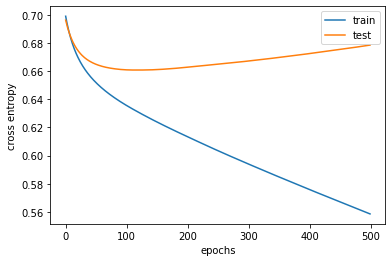

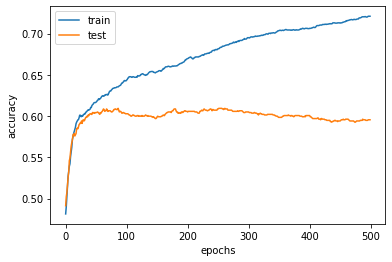

In [126]:
# plot the losses
import matplotlib.pyplot as plt

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [127]:
model.forward(Xr_normalized[0,:]).item()

0.4388851225376129

In [128]:
y_labeled[0].item()

0.0

In [129]:
total = 0
correct = 0
for i in range(Xr_normalized.shape[0]):
    total = total + 1
    y_pred = model.forward(Xr_normalized[i,:]).item()
    y_true = y_labeled[i].item()
    if ((y_pred > .5) and (y_true == 1)) or ((y_pred < .5) and (y_true == 0)):
        correct = correct + 1
print(f'Accuracy of this model on training set: {correct/total}')

Accuracy of this model on training set: 0.6253280839895013


In [130]:
print(f'Accuracy of this model on test set: {best_acc}')

Accuracy of this model on test set: 0.6093294620513916


In [67]:
# This is pretty good. Not too overfit. 
# Better than the logistic regression model, but not by much and its much more complicated.
# TODO: see if we can improve this with feature selection or 

In [68]:
# Trying feature selection that worked for logistic regression
current_best = ['4-fighter_score_diff',
 '9-fighter_score_diff',
 '15-fighter_score_diff',
 '1-fight_math',
 '6-fight_math',
 'fighter_L5Y_sub_wins_diff_2',
 'fighter_L5Y_losses_diff_2',
 'fighter_L5Y_ko_losses_diff_2',
 'fighter_age_diff',
 'fighter_abs_total_strikes_landed_avg_diff_2',
 'fighter_abs_head_strikes_landed_avg_diff_2',
 'fighter_inf_ground_strikes_landed_avg_diff_2',
 'fighter_inf_takedowns_attempts_avg_diff_2',
 'fighter_inf_head_strikes_landed_avg_diff_2',
 ]

In [69]:
# Create tensors to input into neural net
Xr=ufc_fights[current_best]
yr = ufc_fights['result'].to_numpy().reshape(-1,1)

# Normalize Xr to have mean 0 and std 1
Xr_mean = Xr.mean()
Xr_std = Xr.std()
Xr_normalized=(Xr-Xr_mean)/Xr_std

# One-hot encode yr so 
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False).fit(yr)
yr_onehot = ohe.transform(yr)

# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
Xr_normalized = torch.tensor(Xr_normalized.values, dtype=torch.float32)
yr_onehot = torch.tensor(yr_onehot, dtype=torch.float32)

In [101]:
# Defining parameters
lr_ = 0.00004                    # learning rate (default: 1e-3)
betas_ = (0.9, 0.999)           # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
eps_ = 1e-08                    # term added to the denominator to improve numerical stability (default: 1e-8)
weight_decay_ = 0.001               # weight decay (L2 penalty) (default: 0)
num_neurons_ = 120              # number of neurons in hidden layer (default: 100)

In [102]:
# using https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/
# but trying to get logsoftmax to work
class Multiclass(nn.Module):
    def __init__(self, num_features, num_neurons):
        super().__init__()
        self.hidden = nn.Linear(num_features, num_neurons)
        self.relu = nn.ReLU()
        self.output = nn.Linear(num_neurons, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
# defining the learning model
model = Multiclass(Xr_normalized.shape[1], num_neurons_)

#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr_, betas=betas_, eps=eps_, weight_decay=weight_decay_)

In [103]:
# real training loop
import copy
import tqdm
import numpy as np

# split
X_train, X_test, y_train, y_test = train_test_split(Xr_normalized, y_labeled, train_size=0.7, shuffle=True)

n_epochs = 1500
batch_size = 500
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (((y_pred>.5)&(y_batch==1))|((y_pred<=.5)&(y_batch==0))).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (((y_pred>.5)&(y_test==1))|((y_pred<=.5)&(y_test==0))).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: binary cross entropy loss={ce}, Accuracy={acc}")
    
model.load_state_dict(best_weights)

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 206.22batch/s, acc=0.512, loss=0.696]


Epoch 0 validation: binary cross entropy loss=0.6969902515411377, Accuracy=0.48906704783439636


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 187.53batch/s, acc=0.512, loss=0.696]


Epoch 1 validation: binary cross entropy loss=0.6964256167411804, Accuracy=0.4927113652229309


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 187.49batch/s, acc=0.518, loss=0.695]


Epoch 2 validation: binary cross entropy loss=0.6958690881729126, Accuracy=0.4927113652229309


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.43batch/s, acc=0.524, loss=0.695]


Epoch 3 validation: binary cross entropy loss=0.6953211426734924, Accuracy=0.4927113652229309


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.44batch/s, acc=0.524, loss=0.694]


Epoch 4 validation: binary cross entropy loss=0.6947821974754333, Accuracy=0.4927113652229309


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 176.47batch/s, acc=0.524, loss=0.694]


Epoch 5 validation: binary cross entropy loss=0.6942529082298279, Accuracy=0.49635568261146545


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.16batch/s, acc=0.528, loss=0.693]


Epoch 6 validation: binary cross entropy loss=0.6937329769134521, Accuracy=0.5


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.524, loss=0.693]


Epoch 7 validation: binary cross entropy loss=0.6932218670845032, Accuracy=0.5021865963935852


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.53, loss=0.692]


Epoch 8 validation: binary cross entropy loss=0.6927197575569153, Accuracy=0.5043731927871704


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.534, loss=0.692]


Epoch 9 validation: binary cross entropy loss=0.6922270655632019, Accuracy=0.5065597891807556


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.18batch/s, acc=0.538, loss=0.691]


Epoch 10 validation: binary cross entropy loss=0.6917436718940735, Accuracy=0.5116618275642395


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.42batch/s, acc=0.538, loss=0.691]


Epoch 11 validation: binary cross entropy loss=0.691268801689148, Accuracy=0.5153061151504517


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.542, loss=0.69]


Epoch 12 validation: binary cross entropy loss=0.6908024549484253, Accuracy=0.5167638659477234


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.83batch/s, acc=0.548, loss=0.69]


Epoch 13 validation: binary cross entropy loss=0.6903446912765503, Accuracy=0.5196793079376221


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.18batch/s, acc=0.55, loss=0.689]


Epoch 14 validation: binary cross entropy loss=0.6898950338363647, Accuracy=0.5240525007247925


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.83batch/s, acc=0.552, loss=0.689]


Epoch 15 validation: binary cross entropy loss=0.6894532442092896, Accuracy=0.5298833847045898


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.554, loss=0.689]


Epoch 16 validation: binary cross entropy loss=0.6890195608139038, Accuracy=0.5313411355018616


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.15batch/s, acc=0.556, loss=0.688]

Epoch 17 validation: binary cross entropy loss=0.6885936260223389, Accuracy=0.5371720194816589



Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.558, loss=0.688]


Epoch 18 validation: binary cross entropy loss=0.6881751418113708, Accuracy=0.5371720194816589


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.15batch/s, acc=0.558, loss=0.687]


Epoch 19 validation: binary cross entropy loss=0.6877639889717102, Accuracy=0.5379008650779724


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.43batch/s, acc=0.564, loss=0.687]


Epoch 20 validation: binary cross entropy loss=0.6873602867126465, Accuracy=0.5379008650779724


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.66batch/s, acc=0.562, loss=0.686]


Epoch 21 validation: binary cross entropy loss=0.6869638562202454, Accuracy=0.5400874614715576


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.70batch/s, acc=0.566, loss=0.686]


Epoch 22 validation: binary cross entropy loss=0.6865744590759277, Accuracy=0.5437317490577698


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.68batch/s, acc=0.566, loss=0.686]


Epoch 23 validation: binary cross entropy loss=0.686191737651825, Accuracy=0.5422740578651428


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.568, loss=0.685]


Epoch 24 validation: binary cross entropy loss=0.6858156323432922, Accuracy=0.544460654258728


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.52batch/s, acc=0.568, loss=0.685]


Epoch 25 validation: binary cross entropy loss=0.6854459047317505, Accuracy=0.5422740578651428


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.574, loss=0.685]


Epoch 26 validation: binary cross entropy loss=0.6850826740264893, Accuracy=0.5430029034614563


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.576, loss=0.684]


Epoch 27 validation: binary cross entropy loss=0.6847255825996399, Accuracy=0.5415452122688293


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.39batch/s, acc=0.584, loss=0.684]


Epoch 28 validation: binary cross entropy loss=0.6843744516372681, Accuracy=0.5408163070678711


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.578, loss=0.683]


Epoch 29 validation: binary cross entropy loss=0.6840295195579529, Accuracy=0.5437317490577698


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.582, loss=0.683]


Epoch 30 validation: binary cross entropy loss=0.6836902499198914, Accuracy=0.5430029034614563


Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.67batch/s, acc=0.58, loss=0.683]


Epoch 31 validation: binary cross entropy loss=0.6833568215370178, Accuracy=0.5481049418449402


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.15batch/s, acc=0.586, loss=0.682]


Epoch 32 validation: binary cross entropy loss=0.6830289363861084, Accuracy=0.5495626926422119


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.88batch/s, acc=0.588, loss=0.682]


Epoch 33 validation: binary cross entropy loss=0.6827065944671631, Accuracy=0.5532069802284241


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.18batch/s, acc=0.588, loss=0.682]


Epoch 34 validation: binary cross entropy loss=0.6823897361755371, Accuracy=0.5524781346321106


Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.59, loss=0.681]


Epoch 35 validation: binary cross entropy loss=0.6820780634880066, Accuracy=0.5561224222183228


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.15batch/s, acc=0.596, loss=0.681]


Epoch 36 validation: binary cross entropy loss=0.6817712187767029, Accuracy=0.5546647310256958


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.88batch/s, acc=0.596, loss=0.681]


Epoch 37 validation: binary cross entropy loss=0.6814694404602051, Accuracy=0.5546647310256958


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.16batch/s, acc=0.592, loss=0.681]


Epoch 38 validation: binary cross entropy loss=0.6811726093292236, Accuracy=0.5553935766220093


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.44batch/s, acc=0.59, loss=0.68]


Epoch 39 validation: binary cross entropy loss=0.680880606174469, Accuracy=0.5590379238128662


Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.596, loss=0.68]


Epoch 40 validation: binary cross entropy loss=0.6805934906005859, Accuracy=0.5634110569953918


Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.68batch/s, acc=0.596, loss=0.68]


Epoch 41 validation: binary cross entropy loss=0.6803112626075745, Accuracy=0.5641399621963501


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.598, loss=0.679]


Epoch 42 validation: binary cross entropy loss=0.680033802986145, Accuracy=0.5648688077926636


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.596, loss=0.679]


Epoch 43 validation: binary cross entropy loss=0.6797613501548767, Accuracy=0.5663265585899353


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.598, loss=0.679]


Epoch 44 validation: binary cross entropy loss=0.6794934868812561, Accuracy=0.5685130953788757


Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.602, loss=0.678]


Epoch 45 validation: binary cross entropy loss=0.6792303323745728, Accuracy=0.5699708461761475


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.6, loss=0.678]


Epoch 46 validation: binary cross entropy loss=0.6789720058441162, Accuracy=0.5699708461761475


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.6, loss=0.678]


Epoch 47 validation: binary cross entropy loss=0.6787180304527283, Accuracy=0.5706996917724609


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.32batch/s, acc=0.6, loss=0.678]


Epoch 48 validation: binary cross entropy loss=0.6784685850143433, Accuracy=0.5714285969734192


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.604, loss=0.677]


Epoch 49 validation: binary cross entropy loss=0.6782234311103821, Accuracy=0.5714285969734192


Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.602, loss=0.677]


Epoch 50 validation: binary cross entropy loss=0.6779823899269104, Accuracy=0.5736151337623596


Epoch 51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.604, loss=0.677]


Epoch 51 validation: binary cross entropy loss=0.6777456402778625, Accuracy=0.5772594809532166


Epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.604, loss=0.677]


Epoch 52 validation: binary cross entropy loss=0.677513062953949, Accuracy=0.5772594809532166


Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.602, loss=0.676]


Epoch 53 validation: binary cross entropy loss=0.6772847175598145, Accuracy=0.57798832654953


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.6, loss=0.676]


Epoch 54 validation: binary cross entropy loss=0.6770604848861694, Accuracy=0.5787171721458435


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.6, loss=0.676]


Epoch 55 validation: binary cross entropy loss=0.6768401265144348, Accuracy=0.5801749229431152


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.6, loss=0.676]


Epoch 56 validation: binary cross entropy loss=0.6766236424446106, Accuracy=0.5801749229431152


Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.598, loss=0.675]


Epoch 57 validation: binary cross entropy loss=0.676410973072052, Accuracy=0.581632673740387


Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.598, loss=0.675]


Epoch 58 validation: binary cross entropy loss=0.6762021780014038, Accuracy=0.5830903649330139


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.6, loss=0.675]


Epoch 59 validation: binary cross entropy loss=0.6759970188140869, Accuracy=0.5860058069229126


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.6, loss=0.675]


Epoch 60 validation: binary cross entropy loss=0.6757954359054565, Accuracy=0.5852769613265991


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.594, loss=0.674]


Epoch 61 validation: binary cross entropy loss=0.6755974888801575, Accuracy=0.5852769613265991


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.596, loss=0.674]


Epoch 62 validation: binary cross entropy loss=0.6754029989242554, Accuracy=0.5830903649330139


Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.598, loss=0.674]


Epoch 63 validation: binary cross entropy loss=0.6752120852470398, Accuracy=0.5830903649330139


Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.598, loss=0.674]


Epoch 64 validation: binary cross entropy loss=0.675024688243866, Accuracy=0.5845481157302856


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.6, loss=0.674]


Epoch 65 validation: binary cross entropy loss=0.6748404502868652, Accuracy=0.5867347121238708


Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.598, loss=0.673]


Epoch 66 validation: binary cross entropy loss=0.6746595501899719, Accuracy=0.5874635577201843


Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.596, loss=0.673]


Epoch 67 validation: binary cross entropy loss=0.674481987953186, Accuracy=0.5896501541137695


Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.598, loss=0.673]


Epoch 68 validation: binary cross entropy loss=0.6743077039718628, Accuracy=0.590378999710083


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.6, loss=0.673]


Epoch 69 validation: binary cross entropy loss=0.6741366982460022, Accuracy=0.590378999710083


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.6, loss=0.673]


Epoch 70 validation: binary cross entropy loss=0.673969030380249, Accuracy=0.5918367505073547


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 103.45batch/s, acc=0.6, loss=0.672]


Epoch 71 validation: binary cross entropy loss=0.6738045811653137, Accuracy=0.5918367505073547


Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.64batch/s, acc=0.604, loss=0.672]


Epoch 72 validation: binary cross entropy loss=0.6736432313919067, Accuracy=0.5918367505073547


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.606, loss=0.672]


Epoch 73 validation: binary cross entropy loss=0.6734849810600281, Accuracy=0.5918367505073547


Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.608, loss=0.672]


Epoch 74 validation: binary cross entropy loss=0.673329770565033, Accuracy=0.590378999710083


Epoch 75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.57batch/s, acc=0.61, loss=0.672]


Epoch 75 validation: binary cross entropy loss=0.6731776595115662, Accuracy=0.5911078453063965


Epoch 76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.61, loss=0.671]


Epoch 76 validation: binary cross entropy loss=0.673028290271759, Accuracy=0.5918367505073547


Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.612, loss=0.671]


Epoch 77 validation: binary cross entropy loss=0.6728816628456116, Accuracy=0.5918367505073547


Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.612, loss=0.671]


Epoch 78 validation: binary cross entropy loss=0.6727378964424133, Accuracy=0.5918367505073547


Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.612, loss=0.671]


Epoch 79 validation: binary cross entropy loss=0.6725969314575195, Accuracy=0.5925655961036682


Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.612, loss=0.671]


Epoch 80 validation: binary cross entropy loss=0.6724586486816406, Accuracy=0.5925655961036682


Epoch 81: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.614, loss=0.671]


Epoch 81 validation: binary cross entropy loss=0.6723230481147766, Accuracy=0.5947521924972534


Epoch 82: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.616, loss=0.67]


Epoch 82 validation: binary cross entropy loss=0.6721901297569275, Accuracy=0.5954810380935669


Epoch 83: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.618, loss=0.67]


Epoch 83 validation: binary cross entropy loss=0.6720595955848694, Accuracy=0.5962098836898804


Epoch 84: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.618, loss=0.67]


Epoch 84 validation: binary cross entropy loss=0.6719315648078918, Accuracy=0.5962098836898804


Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.618, loss=0.67]


Epoch 85 validation: binary cross entropy loss=0.6718060970306396, Accuracy=0.5962098836898804


Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.618, loss=0.67]


Epoch 86 validation: binary cross entropy loss=0.6716830134391785, Accuracy=0.5969387888908386


Epoch 87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.618, loss=0.67]


Epoch 87 validation: binary cross entropy loss=0.6715624332427979, Accuracy=0.5976676344871521


Epoch 88: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.62, loss=0.669]


Epoch 88 validation: binary cross entropy loss=0.671444296836853, Accuracy=0.5976676344871521


Epoch 89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.62, loss=0.669]


Epoch 89 validation: binary cross entropy loss=0.6713284254074097, Accuracy=0.5969387888908386


Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.46batch/s, acc=0.618, loss=0.669]


Epoch 90 validation: binary cross entropy loss=0.6712149381637573, Accuracy=0.5969387888908386


Epoch 91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.01batch/s, acc=0.618, loss=0.669]


Epoch 91 validation: binary cross entropy loss=0.671103835105896, Accuracy=0.5962098836898804


Epoch 92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 115.39batch/s, acc=0.616, loss=0.669]


Epoch 92 validation: binary cross entropy loss=0.6709949374198914, Accuracy=0.5954810380935669


Epoch 93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.616, loss=0.669]


Epoch 93 validation: binary cross entropy loss=0.6708881258964539, Accuracy=0.5954810380935669


Epoch 94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.616, loss=0.668]


Epoch 94 validation: binary cross entropy loss=0.670783281326294, Accuracy=0.5947521924972534


Epoch 95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.616, loss=0.668]


Epoch 95 validation: binary cross entropy loss=0.6706805229187012, Accuracy=0.5969387888908386


Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.616, loss=0.668]


Epoch 96 validation: binary cross entropy loss=0.670579731464386, Accuracy=0.5983964800834656


Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.618, loss=0.668]


Epoch 97 validation: binary cross entropy loss=0.6704813241958618, Accuracy=0.6005830764770508


Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.618, loss=0.668]


Epoch 98 validation: binary cross entropy loss=0.6703847646713257, Accuracy=0.601311981678009


Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.62, loss=0.668]


Epoch 99 validation: binary cross entropy loss=0.6702902913093567, Accuracy=0.6005830764770508


Epoch 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.62, loss=0.668]


Epoch 100 validation: binary cross entropy loss=0.670197606086731, Accuracy=0.6005830764770508


Epoch 101: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.62, loss=0.668]


Epoch 101 validation: binary cross entropy loss=0.6701067686080933, Accuracy=0.5998542308807373


Epoch 102: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.62, loss=0.667]


Epoch 102 validation: binary cross entropy loss=0.6700177192687988, Accuracy=0.5998542308807373


Epoch 103: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.62, loss=0.667]


Epoch 103 validation: binary cross entropy loss=0.6699302792549133, Accuracy=0.5983964800834656


Epoch 104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.622, loss=0.667]


Epoch 104 validation: binary cross entropy loss=0.6698445677757263, Accuracy=0.5983964800834656


Epoch 105: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.622, loss=0.667]


Epoch 105 validation: binary cross entropy loss=0.6697606444358826, Accuracy=0.5976676344871521


Epoch 106: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.622, loss=0.667]


Epoch 106 validation: binary cross entropy loss=0.6696786284446716, Accuracy=0.5976676344871521


Epoch 107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.622, loss=0.667]


Epoch 107 validation: binary cross entropy loss=0.6695983409881592, Accuracy=0.5976676344871521


Epoch 108: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.622, loss=0.667]


Epoch 108 validation: binary cross entropy loss=0.6695197820663452, Accuracy=0.5983964800834656


Epoch 109: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.622, loss=0.667]


Epoch 109 validation: binary cross entropy loss=0.6694428324699402, Accuracy=0.5991253852844238


Epoch 110: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.91batch/s, acc=0.622, loss=0.666]


Epoch 110 validation: binary cross entropy loss=0.6693674921989441, Accuracy=0.5983964800834656


Epoch 111: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.62, loss=0.666]


Epoch 111 validation: binary cross entropy loss=0.6692936420440674, Accuracy=0.5983964800834656


Epoch 112: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.62, loss=0.666]


Epoch 112 validation: binary cross entropy loss=0.6692214608192444, Accuracy=0.5983964800834656


Epoch 113: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.62, loss=0.666]


Epoch 113 validation: binary cross entropy loss=0.6691505312919617, Accuracy=0.5998542308807373


Epoch 114: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.622, loss=0.666]


Epoch 114 validation: binary cross entropy loss=0.6690810322761536, Accuracy=0.6005830764770508


Epoch 115: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.622, loss=0.666]


Epoch 115 validation: binary cross entropy loss=0.6690129637718201, Accuracy=0.601311981678009


Epoch 116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.624, loss=0.666]


Epoch 116 validation: binary cross entropy loss=0.6689464449882507, Accuracy=0.6005830764770508


Epoch 117: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.624, loss=0.666]


Epoch 117 validation: binary cross entropy loss=0.6688812971115112, Accuracy=0.6020408272743225


Epoch 118: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.628, loss=0.666]


Epoch 118 validation: binary cross entropy loss=0.6688173413276672, Accuracy=0.6020408272743225


Epoch 119: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.628, loss=0.665]


Epoch 119 validation: binary cross entropy loss=0.6687549352645874, Accuracy=0.601311981678009


Epoch 120: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.628, loss=0.665]


Epoch 120 validation: binary cross entropy loss=0.6686938405036926, Accuracy=0.5998542308807373


Epoch 121: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.628, loss=0.665]


Epoch 121 validation: binary cross entropy loss=0.6686341762542725, Accuracy=0.6005830764770508


Epoch 122: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.628, loss=0.665]


Epoch 122 validation: binary cross entropy loss=0.6685757637023926, Accuracy=0.6005830764770508


Epoch 123: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.665]


Epoch 123 validation: binary cross entropy loss=0.6685186624526978, Accuracy=0.5998542308807373


Epoch 124: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 109.10batch/s, acc=0.628, loss=0.665]


Epoch 124 validation: binary cross entropy loss=0.6684627532958984, Accuracy=0.5991253852844238


Epoch 125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.628, loss=0.665]


Epoch 125 validation: binary cross entropy loss=0.6684081554412842, Accuracy=0.6005830764770508


Epoch 126: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.34batch/s, acc=0.63, loss=0.665]


Epoch 126 validation: binary cross entropy loss=0.6683546304702759, Accuracy=0.601311981678009


Epoch 127: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.63, loss=0.665]


Epoch 127 validation: binary cross entropy loss=0.6683021187782288, Accuracy=0.601311981678009


Epoch 128: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 109.09batch/s, acc=0.632, loss=0.665]


Epoch 128 validation: binary cross entropy loss=0.6682508587837219, Accuracy=0.601311981678009


Epoch 129: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.65batch/s, acc=0.634, loss=0.664]


Epoch 129 validation: binary cross entropy loss=0.6682006120681763, Accuracy=0.601311981678009


Epoch 130: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 90.91batch/s, acc=0.632, loss=0.664]


Epoch 130 validation: binary cross entropy loss=0.6681514382362366, Accuracy=0.601311981678009


Epoch 131: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.63, loss=0.664]


Epoch 131 validation: binary cross entropy loss=0.6681033372879028, Accuracy=0.601311981678009


Epoch 132: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.63, loss=0.664]

Epoch 132 validation: binary cross entropy loss=0.6680563688278198, Accuracy=0.6005830764770508



Epoch 133: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.63, loss=0.664]


Epoch 133 validation: binary cross entropy loss=0.6680102348327637, Accuracy=0.601311981678009


Epoch 134: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.63, loss=0.664]


Epoch 134 validation: binary cross entropy loss=0.6679654121398926, Accuracy=0.601311981678009


Epoch 135: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.63, loss=0.664]


Epoch 135 validation: binary cross entropy loss=0.6679214835166931, Accuracy=0.6020408272743225


Epoch 136: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.664]


Epoch 136 validation: binary cross entropy loss=0.6678786873817444, Accuracy=0.601311981678009


Epoch 137: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 113.21batch/s, acc=0.632, loss=0.664]


Epoch 137 validation: binary cross entropy loss=0.6678367853164673, Accuracy=0.601311981678009


Epoch 138: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.46batch/s, acc=0.632, loss=0.664]


Epoch 138 validation: binary cross entropy loss=0.6677958369255066, Accuracy=0.601311981678009


Epoch 139: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.63, loss=0.664]


Epoch 139 validation: binary cross entropy loss=0.6677557229995728, Accuracy=0.6005830764770508


Epoch 140: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.01batch/s, acc=0.63, loss=0.663]


Epoch 140 validation: binary cross entropy loss=0.6677165627479553, Accuracy=0.5998542308807373


Epoch 141: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.628, loss=0.663]


Epoch 141 validation: binary cross entropy loss=0.6676782965660095, Accuracy=0.5998542308807373


Epoch 142: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.628, loss=0.663]


Epoch 142 validation: binary cross entropy loss=0.6676406860351562, Accuracy=0.5998542308807373


Epoch 143: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.628, loss=0.663]


Epoch 143 validation: binary cross entropy loss=0.6676037907600403, Accuracy=0.5991253852844238


Epoch 144: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.628, loss=0.663]


Epoch 144 validation: binary cross entropy loss=0.6675676703453064, Accuracy=0.5991253852844238


Epoch 145: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.66batch/s, acc=0.628, loss=0.663]


Epoch 145 validation: binary cross entropy loss=0.6675322651863098, Accuracy=0.5983964800834656


Epoch 146: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.626, loss=0.663]


Epoch 146 validation: binary cross entropy loss=0.6674976348876953, Accuracy=0.5991253852844238


Epoch 147: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.626, loss=0.663]


Epoch 147 validation: binary cross entropy loss=0.6674638390541077, Accuracy=0.5991253852844238


Epoch 148: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.626, loss=0.663]


Epoch 148 validation: binary cross entropy loss=0.6674308776855469, Accuracy=0.5991253852844238


Epoch 149: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.626, loss=0.663]


Epoch 149 validation: binary cross entropy loss=0.6673986315727234, Accuracy=0.5983964800834656


Epoch 150: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.35batch/s, acc=0.626, loss=0.663]


Epoch 150 validation: binary cross entropy loss=0.6673671007156372, Accuracy=0.5976676344871521


Epoch 151: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.626, loss=0.663]


Epoch 151 validation: binary cross entropy loss=0.6673362255096436, Accuracy=0.5969387888908386


Epoch 152: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.45batch/s, acc=0.626, loss=0.663]


Epoch 152 validation: binary cross entropy loss=0.6673059463500977, Accuracy=0.5969387888908386


Epoch 153: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.626, loss=0.662]


Epoch 153 validation: binary cross entropy loss=0.6672764420509338, Accuracy=0.5976676344871521


Epoch 154: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.626, loss=0.662]


Epoch 154 validation: binary cross entropy loss=0.6672475934028625, Accuracy=0.5983964800834656


Epoch 155: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.626, loss=0.662]


Epoch 155 validation: binary cross entropy loss=0.6672192215919495, Accuracy=0.5969387888908386


Epoch 156: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.628, loss=0.662]


Epoch 156 validation: binary cross entropy loss=0.6671914458274841, Accuracy=0.5969387888908386


Epoch 157: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.628, loss=0.662]


Epoch 157 validation: binary cross entropy loss=0.6671642661094666, Accuracy=0.5969387888908386


Epoch 158: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.628, loss=0.662]


Epoch 158 validation: binary cross entropy loss=0.6671375036239624, Accuracy=0.5969387888908386


Epoch 159: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.628, loss=0.662]


Epoch 159 validation: binary cross entropy loss=0.6671112775802612, Accuracy=0.5976676344871521


Epoch 160: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.628, loss=0.662]


Epoch 160 validation: binary cross entropy loss=0.6670855283737183, Accuracy=0.5983964800834656


Epoch 161: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.56batch/s, acc=0.628, loss=0.662]


Epoch 161 validation: binary cross entropy loss=0.6670603156089783, Accuracy=0.5976676344871521


Epoch 162: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.628, loss=0.662]


Epoch 162 validation: binary cross entropy loss=0.667035698890686, Accuracy=0.5976676344871521


Epoch 163: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.628, loss=0.662]


Epoch 163 validation: binary cross entropy loss=0.667011559009552, Accuracy=0.5983964800834656


Epoch 164: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.628, loss=0.662]


Epoch 164 validation: binary cross entropy loss=0.6669878363609314, Accuracy=0.5983964800834656


Epoch 165: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.628, loss=0.662]


Epoch 165 validation: binary cross entropy loss=0.6669647097587585, Accuracy=0.5983964800834656


Epoch 166: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.628, loss=0.662]


Epoch 166 validation: binary cross entropy loss=0.6669420599937439, Accuracy=0.5991253852844238


Epoch 167: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.628, loss=0.661]


Epoch 167 validation: binary cross entropy loss=0.6669197678565979, Accuracy=0.5998542308807373


Epoch 168: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.628, loss=0.661]


Epoch 168 validation: binary cross entropy loss=0.666897714138031, Accuracy=0.5998542308807373


Epoch 169: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.628, loss=0.661]


Epoch 169 validation: binary cross entropy loss=0.6668761968612671, Accuracy=0.5991253852844238


Epoch 170: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.628, loss=0.661]


Epoch 170 validation: binary cross entropy loss=0.666854977607727, Accuracy=0.5991253852844238


Epoch 171: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.661]


Epoch 171 validation: binary cross entropy loss=0.6668343544006348, Accuracy=0.5991253852844238


Epoch 172: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.63, loss=0.661]


Epoch 172 validation: binary cross entropy loss=0.6668140292167664, Accuracy=0.5998542308807373


Epoch 173: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.63, loss=0.661]


Epoch 173 validation: binary cross entropy loss=0.6667941808700562, Accuracy=0.5998542308807373


Epoch 174: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.63, loss=0.661]


Epoch 174 validation: binary cross entropy loss=0.6667747497558594, Accuracy=0.5998542308807373


Epoch 175: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.63, loss=0.661]


Epoch 175 validation: binary cross entropy loss=0.6667555570602417, Accuracy=0.5998542308807373


Epoch 176: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 115.41batch/s, acc=0.63, loss=0.661]


Epoch 176 validation: binary cross entropy loss=0.6667367219924927, Accuracy=0.5998542308807373


Epoch 177: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.634, loss=0.661]


Epoch 177 validation: binary cross entropy loss=0.6667183041572571, Accuracy=0.5991253852844238


Epoch 178: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.661]


Epoch 178 validation: binary cross entropy loss=0.6667003631591797, Accuracy=0.5998542308807373


Epoch 179: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.661]


Epoch 179 validation: binary cross entropy loss=0.666682779788971, Accuracy=0.6005830764770508


Epoch 180: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.661]


Epoch 180 validation: binary cross entropy loss=0.6666656732559204, Accuracy=0.601311981678009


Epoch 181: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.661]


Epoch 181 validation: binary cross entropy loss=0.6666488647460938, Accuracy=0.6005830764770508


Epoch 182: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.661]


Epoch 182 validation: binary cross entropy loss=0.6666325330734253, Accuracy=0.6005830764770508


Epoch 183: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.661]


Epoch 183 validation: binary cross entropy loss=0.6666166186332703, Accuracy=0.601311981678009


Epoch 184: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.636, loss=0.66]


Epoch 184 validation: binary cross entropy loss=0.6666010022163391, Accuracy=0.6020408272743225


Epoch 185: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.636, loss=0.66]


Epoch 185 validation: binary cross entropy loss=0.6665856242179871, Accuracy=0.6020408272743225


Epoch 186: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.66]


Epoch 186 validation: binary cross entropy loss=0.6665706038475037, Accuracy=0.6042274236679077


Epoch 187: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.66]


Epoch 187 validation: binary cross entropy loss=0.6665558815002441, Accuracy=0.6042274236679077


Epoch 188: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.634, loss=0.66]


Epoch 188 validation: binary cross entropy loss=0.6665413975715637, Accuracy=0.6042274236679077


Epoch 189: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.636, loss=0.66]


Epoch 189 validation: binary cross entropy loss=0.6665272116661072, Accuracy=0.6034985184669495


Epoch 190: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.638, loss=0.66]


Epoch 190 validation: binary cross entropy loss=0.6665133833885193, Accuracy=0.602769672870636


Epoch 191: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.636, loss=0.66]


Epoch 191 validation: binary cross entropy loss=0.6664996147155762, Accuracy=0.602769672870636


Epoch 192: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.638, loss=0.66]


Epoch 192 validation: binary cross entropy loss=0.6664862036705017, Accuracy=0.602769672870636


Epoch 193: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.638, loss=0.66]


Epoch 193 validation: binary cross entropy loss=0.6664730906486511, Accuracy=0.6034985184669495


Epoch 194: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.03batch/s, acc=0.638, loss=0.66]


Epoch 194 validation: binary cross entropy loss=0.6664601564407349, Accuracy=0.6034985184669495


Epoch 195: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.51batch/s, acc=0.638, loss=0.66]


Epoch 195 validation: binary cross entropy loss=0.6664476990699768, Accuracy=0.6034985184669495


Epoch 196: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.638, loss=0.66]


Epoch 196 validation: binary cross entropy loss=0.6664354801177979, Accuracy=0.6034985184669495


Epoch 197: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.638, loss=0.66]


Epoch 197 validation: binary cross entropy loss=0.6664234399795532, Accuracy=0.6020408272743225


Epoch 198: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.636, loss=0.66]


Epoch 198 validation: binary cross entropy loss=0.6664116382598877, Accuracy=0.602769672870636


Epoch 199: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.636, loss=0.66]


Epoch 199 validation: binary cross entropy loss=0.6663999557495117, Accuracy=0.602769672870636


Epoch 200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.636, loss=0.66]


Epoch 200 validation: binary cross entropy loss=0.6663883924484253, Accuracy=0.602769672870636


Epoch 201: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.638, loss=0.66]


Epoch 201 validation: binary cross entropy loss=0.666377067565918, Accuracy=0.602769672870636


Epoch 202: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.638, loss=0.66]


Epoch 202 validation: binary cross entropy loss=0.6663658022880554, Accuracy=0.6020408272743225


Epoch 203: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.638, loss=0.659]


Epoch 203 validation: binary cross entropy loss=0.6663546562194824, Accuracy=0.602769672870636


Epoch 204: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.638, loss=0.659]


Epoch 204 validation: binary cross entropy loss=0.6663438081741333, Accuracy=0.6020408272743225


Epoch 205: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.05batch/s, acc=0.64, loss=0.659]


Epoch 205 validation: binary cross entropy loss=0.6663332581520081, Accuracy=0.6020408272743225


Epoch 206: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.98batch/s, acc=0.64, loss=0.659]


Epoch 206 validation: binary cross entropy loss=0.6663230061531067, Accuracy=0.6020408272743225


Epoch 207: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.64, loss=0.659]


Epoch 207 validation: binary cross entropy loss=0.6663128733634949, Accuracy=0.6020408272743225


Epoch 208: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.64, loss=0.659]


Epoch 208 validation: binary cross entropy loss=0.6663029789924622, Accuracy=0.6020408272743225


Epoch 209: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.64, loss=0.659]


Epoch 209 validation: binary cross entropy loss=0.6662933230400085, Accuracy=0.601311981678009


Epoch 210: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.64, loss=0.659]


Epoch 210 validation: binary cross entropy loss=0.6662837266921997, Accuracy=0.601311981678009


Epoch 211: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.64, loss=0.659]


Epoch 211 validation: binary cross entropy loss=0.6662742495536804, Accuracy=0.6034985184669495


Epoch 212: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.98batch/s, acc=0.64, loss=0.659]


Epoch 212 validation: binary cross entropy loss=0.666265070438385, Accuracy=0.6034985184669495


Epoch 213: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.64, loss=0.659]


Epoch 213 validation: binary cross entropy loss=0.6662560105323792, Accuracy=0.6042274236679077


Epoch 214: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.64, loss=0.659]


Epoch 214 validation: binary cross entropy loss=0.6662469506263733, Accuracy=0.6034985184669495


Epoch 215: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.64, loss=0.659]


Epoch 215 validation: binary cross entropy loss=0.6662378907203674, Accuracy=0.6042274236679077


Epoch 216: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.84batch/s, acc=0.64, loss=0.659]


Epoch 216 validation: binary cross entropy loss=0.6662291288375854, Accuracy=0.6034985184669495


Epoch 217: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.64, loss=0.659]


Epoch 217 validation: binary cross entropy loss=0.6662204265594482, Accuracy=0.6034985184669495


Epoch 218: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.65batch/s, acc=0.64, loss=0.659]


Epoch 218 validation: binary cross entropy loss=0.6662118434906006, Accuracy=0.6034985184669495


Epoch 219: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.64, loss=0.659]


Epoch 219 validation: binary cross entropy loss=0.6662034392356873, Accuracy=0.602769672870636


Epoch 220: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.642, loss=0.659]


Epoch 220 validation: binary cross entropy loss=0.6661950945854187, Accuracy=0.6020408272743225


Epoch 221: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.642, loss=0.659]


Epoch 221 validation: binary cross entropy loss=0.6661868691444397, Accuracy=0.6020408272743225


Epoch 222: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.642, loss=0.659]


Epoch 222 validation: binary cross entropy loss=0.6661787629127502, Accuracy=0.6020408272743225


Epoch 223: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 140.84batch/s, acc=0.642, loss=0.659]


Epoch 223 validation: binary cross entropy loss=0.6661708950996399, Accuracy=0.601311981678009


Epoch 224: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.642, loss=0.658]


Epoch 224 validation: binary cross entropy loss=0.6661631464958191, Accuracy=0.601311981678009


Epoch 225: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.642, loss=0.658]


Epoch 225 validation: binary cross entropy loss=0.6661555171012878, Accuracy=0.601311981678009


Epoch 226: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.642, loss=0.658]


Epoch 226 validation: binary cross entropy loss=0.6661479473114014, Accuracy=0.601311981678009


Epoch 227: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.64, loss=0.658]


Epoch 227 validation: binary cross entropy loss=0.6661404371261597, Accuracy=0.6020408272743225


Epoch 228: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.64, loss=0.658]


Epoch 228 validation: binary cross entropy loss=0.6661329865455627, Accuracy=0.6020408272743225


Epoch 229: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.638, loss=0.658]


Epoch 229 validation: binary cross entropy loss=0.6661257147789001, Accuracy=0.6020408272743225


Epoch 230: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 105.27batch/s, acc=0.638, loss=0.658]


Epoch 230 validation: binary cross entropy loss=0.6661184430122375, Accuracy=0.601311981678009


Epoch 231: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.638, loss=0.658]


Epoch 231 validation: binary cross entropy loss=0.6661112904548645, Accuracy=0.601311981678009


Epoch 232: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.638, loss=0.658]


Epoch 232 validation: binary cross entropy loss=0.666104257106781, Accuracy=0.601311981678009


Epoch 233: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.638, loss=0.658]


Epoch 233 validation: binary cross entropy loss=0.6660974025726318, Accuracy=0.6005830764770508


Epoch 234: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.638, loss=0.658]


Epoch 234 validation: binary cross entropy loss=0.6660904288291931, Accuracy=0.5991253852844238


Epoch 235: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.638, loss=0.658]


Epoch 235 validation: binary cross entropy loss=0.6660837531089783, Accuracy=0.5991253852844238


Epoch 236: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.35batch/s, acc=0.638, loss=0.658]


Epoch 236 validation: binary cross entropy loss=0.6660770773887634, Accuracy=0.5991253852844238


Epoch 237: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.638, loss=0.658]


Epoch 237 validation: binary cross entropy loss=0.6660705804824829, Accuracy=0.5991253852844238


Epoch 238: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.45batch/s, acc=0.638, loss=0.658]


Epoch 238 validation: binary cross entropy loss=0.6660641431808472, Accuracy=0.5991253852844238


Epoch 239: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.638, loss=0.658]


Epoch 239 validation: binary cross entropy loss=0.6660577058792114, Accuracy=0.5991253852844238


Epoch 240: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.52batch/s, acc=0.638, loss=0.658]


Epoch 240 validation: binary cross entropy loss=0.6660513281822205, Accuracy=0.5991253852844238


Epoch 241: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.638, loss=0.658]


Epoch 241 validation: binary cross entropy loss=0.666045069694519, Accuracy=0.5991253852844238


Epoch 242: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.638, loss=0.658]


Epoch 242 validation: binary cross entropy loss=0.6660388708114624, Accuracy=0.6005830764770508


Epoch 243: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.638, loss=0.658]


Epoch 243 validation: binary cross entropy loss=0.6660327315330505, Accuracy=0.5998542308807373


Epoch 244: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.638, loss=0.658]


Epoch 244 validation: binary cross entropy loss=0.666026771068573, Accuracy=0.5991253852844238


Epoch 245: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.638, loss=0.658]


Epoch 245 validation: binary cross entropy loss=0.6660208106040955, Accuracy=0.5991253852844238


Epoch 246: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.638, loss=0.658]


Epoch 246 validation: binary cross entropy loss=0.6660149693489075, Accuracy=0.5983964800834656


Epoch 247: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.638, loss=0.657]


Epoch 247 validation: binary cross entropy loss=0.666009247303009, Accuracy=0.5983964800834656


Epoch 248: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.638, loss=0.657]


Epoch 248 validation: binary cross entropy loss=0.6660035848617554, Accuracy=0.5983964800834656


Epoch 249: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.638, loss=0.657]


Epoch 249 validation: binary cross entropy loss=0.6659979224205017, Accuracy=0.5983964800834656


Epoch 250: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.638, loss=0.657]


Epoch 250 validation: binary cross entropy loss=0.6659923791885376, Accuracy=0.5983964800834656


Epoch 251: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.638, loss=0.657]


Epoch 251 validation: binary cross entropy loss=0.6659868955612183, Accuracy=0.5983964800834656


Epoch 252: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.638, loss=0.657]


Epoch 252 validation: binary cross entropy loss=0.6659815311431885, Accuracy=0.5983964800834656


Epoch 253: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.638, loss=0.657]


Epoch 253 validation: binary cross entropy loss=0.6659761667251587, Accuracy=0.5991253852844238


Epoch 254: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.638, loss=0.657]


Epoch 254 validation: binary cross entropy loss=0.6659709215164185, Accuracy=0.5991253852844238


Epoch 255: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.636, loss=0.657]


Epoch 255 validation: binary cross entropy loss=0.6659656167030334, Accuracy=0.5998542308807373


Epoch 256: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.657]


Epoch 256 validation: binary cross entropy loss=0.6659603714942932, Accuracy=0.5998542308807373


Epoch 257: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.634, loss=0.657]


Epoch 257 validation: binary cross entropy loss=0.665955126285553, Accuracy=0.5998542308807373


Epoch 258: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.657]


Epoch 258 validation: binary cross entropy loss=0.6659498810768127, Accuracy=0.5991253852844238


Epoch 259: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.636, loss=0.657]


Epoch 259 validation: binary cross entropy loss=0.6659445762634277, Accuracy=0.5991253852844238


Epoch 260: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.657]


Epoch 260 validation: binary cross entropy loss=0.6659393310546875, Accuracy=0.5983964800834656


Epoch 261: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.636, loss=0.657]


Epoch 261 validation: binary cross entropy loss=0.6659340262413025, Accuracy=0.5983964800834656


Epoch 262: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.636, loss=0.657]


Epoch 262 validation: binary cross entropy loss=0.6659287214279175, Accuracy=0.5983964800834656


Epoch 263: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.657]


Epoch 263 validation: binary cross entropy loss=0.6659234166145325, Accuracy=0.5983964800834656


Epoch 264: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.63, loss=0.657]


Epoch 264 validation: binary cross entropy loss=0.6659181714057922, Accuracy=0.5983964800834656


Epoch 265: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.63, loss=0.657]


Epoch 265 validation: binary cross entropy loss=0.6659130454063416, Accuracy=0.5983964800834656


Epoch 266: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.63, loss=0.657]


Epoch 266 validation: binary cross entropy loss=0.6659078001976013, Accuracy=0.5983964800834656


Epoch 267: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.628, loss=0.657]


Epoch 267 validation: binary cross entropy loss=0.6659024357795715, Accuracy=0.5983964800834656


Epoch 268: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.628, loss=0.657]


Epoch 268 validation: binary cross entropy loss=0.6658971905708313, Accuracy=0.5983964800834656


Epoch 269: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.657]


Epoch 269 validation: binary cross entropy loss=0.6658919453620911, Accuracy=0.5983964800834656


Epoch 270: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.63, loss=0.657]


Epoch 270 validation: binary cross entropy loss=0.6658867001533508, Accuracy=0.5983964800834656


Epoch 271: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.628, loss=0.657]


Epoch 271 validation: binary cross entropy loss=0.6658815145492554, Accuracy=0.5983964800834656


Epoch 272: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.628, loss=0.656]


Epoch 272 validation: binary cross entropy loss=0.6658763885498047, Accuracy=0.5983964800834656


Epoch 273: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.628, loss=0.656]


Epoch 273 validation: binary cross entropy loss=0.6658714413642883, Accuracy=0.5983964800834656


Epoch 274: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.628, loss=0.656]


Epoch 274 validation: binary cross entropy loss=0.6658664345741272, Accuracy=0.5983964800834656


Epoch 275: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.628, loss=0.656]


Epoch 275 validation: binary cross entropy loss=0.6658614277839661, Accuracy=0.5983964800834656


Epoch 276: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.628, loss=0.656]


Epoch 276 validation: binary cross entropy loss=0.6658564805984497, Accuracy=0.5976676344871521


Epoch 277: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.628, loss=0.656]


Epoch 277 validation: binary cross entropy loss=0.6658516526222229, Accuracy=0.5976676344871521


Epoch 278: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.628, loss=0.656]


Epoch 278 validation: binary cross entropy loss=0.6658468246459961, Accuracy=0.5983964800834656


Epoch 279: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.628, loss=0.656]


Epoch 279 validation: binary cross entropy loss=0.6658421158790588, Accuracy=0.5983964800834656


Epoch 280: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.628, loss=0.656]


Epoch 280 validation: binary cross entropy loss=0.6658375263214111, Accuracy=0.5983964800834656


Epoch 281: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.628, loss=0.656]


Epoch 281 validation: binary cross entropy loss=0.6658328175544739, Accuracy=0.5969387888908386


Epoch 282: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.628, loss=0.656]


Epoch 282 validation: binary cross entropy loss=0.6658282279968262, Accuracy=0.5969387888908386


Epoch 283: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.628, loss=0.656]


Epoch 283 validation: binary cross entropy loss=0.6658235192298889, Accuracy=0.5962098836898804


Epoch 284: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.628, loss=0.656]


Epoch 284 validation: binary cross entropy loss=0.6658189296722412, Accuracy=0.5962098836898804


Epoch 285: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.628, loss=0.656]


Epoch 285 validation: binary cross entropy loss=0.6658144593238831, Accuracy=0.5954810380935669


Epoch 286: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.628, loss=0.656]


Epoch 286 validation: binary cross entropy loss=0.6658099889755249, Accuracy=0.5947521924972534


Epoch 287: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 113.21batch/s, acc=0.626, loss=0.656]


Epoch 287 validation: binary cross entropy loss=0.6658057570457458, Accuracy=0.5947521924972534


Epoch 288: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.626, loss=0.656]


Epoch 288 validation: binary cross entropy loss=0.665801465511322, Accuracy=0.5947521924972534


Epoch 289: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.626, loss=0.656]


Epoch 289 validation: binary cross entropy loss=0.6657971739768982, Accuracy=0.5947521924972534


Epoch 290: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.626, loss=0.656]


Epoch 290 validation: binary cross entropy loss=0.6657929420471191, Accuracy=0.5954810380935669


Epoch 291: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.626, loss=0.656]


Epoch 291 validation: binary cross entropy loss=0.6657887697219849, Accuracy=0.5954810380935669


Epoch 292: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.626, loss=0.656]


Epoch 292 validation: binary cross entropy loss=0.6657845377922058, Accuracy=0.5954810380935669


Epoch 293: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.626, loss=0.656]


Epoch 293 validation: binary cross entropy loss=0.6657803654670715, Accuracy=0.5954810380935669


Epoch 294: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.626, loss=0.656]


Epoch 294 validation: binary cross entropy loss=0.6657761335372925, Accuracy=0.5962098836898804


Epoch 295: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.626, loss=0.656]


Epoch 295 validation: binary cross entropy loss=0.6657719016075134, Accuracy=0.5962098836898804


Epoch 296: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.626, loss=0.656]


Epoch 296 validation: binary cross entropy loss=0.6657676696777344, Accuracy=0.5962098836898804


Epoch 297: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.01batch/s, acc=0.626, loss=0.656]


Epoch 297 validation: binary cross entropy loss=0.6657633781433105, Accuracy=0.5962098836898804


Epoch 298: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.626, loss=0.656]


Epoch 298 validation: binary cross entropy loss=0.665759265422821, Accuracy=0.5962098836898804


Epoch 299: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.628, loss=0.656]


Epoch 299 validation: binary cross entropy loss=0.6657552123069763, Accuracy=0.5962098836898804


Epoch 300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 111.11batch/s, acc=0.628, loss=0.656]


Epoch 300 validation: binary cross entropy loss=0.6657510995864868, Accuracy=0.5954810380935669


Epoch 301: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.628, loss=0.655]


Epoch 301 validation: binary cross entropy loss=0.6657470464706421, Accuracy=0.5954810380935669


Epoch 302: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.655]


Epoch 302 validation: binary cross entropy loss=0.6657429337501526, Accuracy=0.5947521924972534


Epoch 303: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.632, loss=0.655]


Epoch 303 validation: binary cross entropy loss=0.6657389402389526, Accuracy=0.5954810380935669


Epoch 304: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.632, loss=0.655]


Epoch 304 validation: binary cross entropy loss=0.6657349467277527, Accuracy=0.5954810380935669


Epoch 305: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.655]


Epoch 305 validation: binary cross entropy loss=0.665730893611908, Accuracy=0.5954810380935669


Epoch 306: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.66batch/s, acc=0.632, loss=0.655]


Epoch 306 validation: binary cross entropy loss=0.6657268404960632, Accuracy=0.5954810380935669


Epoch 307: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.655]


Epoch 307 validation: binary cross entropy loss=0.6657229065895081, Accuracy=0.5954810380935669


Epoch 308: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.655]


Epoch 308 validation: binary cross entropy loss=0.6657189726829529, Accuracy=0.5954810380935669


Epoch 309: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.655]


Epoch 309 validation: binary cross entropy loss=0.6657149195671082, Accuracy=0.5954810380935669


Epoch 310: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.655]


Epoch 310 validation: binary cross entropy loss=0.665710985660553, Accuracy=0.5954810380935669


Epoch 311: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.655]


Epoch 311 validation: binary cross entropy loss=0.6657071113586426, Accuracy=0.5954810380935669


Epoch 312: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.655]


Epoch 312 validation: binary cross entropy loss=0.6657031774520874, Accuracy=0.5954810380935669


Epoch 313: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.655]


Epoch 313 validation: binary cross entropy loss=0.665699303150177, Accuracy=0.5947521924972534


Epoch 314: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.655]


Epoch 314 validation: binary cross entropy loss=0.6656954884529114, Accuracy=0.5947521924972534


Epoch 315: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.655]


Epoch 315 validation: binary cross entropy loss=0.6656916737556458, Accuracy=0.5947521924972534


Epoch 316: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.655]


Epoch 316 validation: binary cross entropy loss=0.6656879186630249, Accuracy=0.5947521924972534


Epoch 317: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.655]


Epoch 317 validation: binary cross entropy loss=0.6656840443611145, Accuracy=0.5947521924972534


Epoch 318: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.655]


Epoch 318 validation: binary cross entropy loss=0.6656803488731384, Accuracy=0.5947521924972534


Epoch 319: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.01batch/s, acc=0.632, loss=0.655]


Epoch 319 validation: binary cross entropy loss=0.6656767129898071, Accuracy=0.5947521924972534


Epoch 320: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.655]


Epoch 320 validation: binary cross entropy loss=0.665673017501831, Accuracy=0.5940233469009399


Epoch 321: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.63, loss=0.655]


Epoch 321 validation: binary cross entropy loss=0.6656693816184998, Accuracy=0.5940233469009399


Epoch 322: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.63, loss=0.655]


Epoch 322 validation: binary cross entropy loss=0.6656659841537476, Accuracy=0.5947521924972534


Epoch 323: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.63, loss=0.655]


Epoch 323 validation: binary cross entropy loss=0.665662407875061, Accuracy=0.5947521924972534


Epoch 324: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.63, loss=0.655]


Epoch 324 validation: binary cross entropy loss=0.6656589508056641, Accuracy=0.5947521924972534


Epoch 325: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 115.38batch/s, acc=0.63, loss=0.655]


Epoch 325 validation: binary cross entropy loss=0.6656553745269775, Accuracy=0.5954810380935669


Epoch 326: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.63, loss=0.655]


Epoch 326 validation: binary cross entropy loss=0.6656519770622253, Accuracy=0.5954810380935669


Epoch 327: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.63, loss=0.655]


Epoch 327 validation: binary cross entropy loss=0.6656484603881836, Accuracy=0.5954810380935669


Epoch 328: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.63, loss=0.655]


Epoch 328 validation: binary cross entropy loss=0.6656451225280762, Accuracy=0.5954810380935669


Epoch 329: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.63, loss=0.655]


Epoch 329 validation: binary cross entropy loss=0.6656417846679688, Accuracy=0.5954810380935669


Epoch 330: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.655]


Epoch 330 validation: binary cross entropy loss=0.6656384468078613, Accuracy=0.5954810380935669


Epoch 331: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.63, loss=0.655]


Epoch 331 validation: binary cross entropy loss=0.6656352877616882, Accuracy=0.5954810380935669


Epoch 332: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.63, loss=0.654]


Epoch 332 validation: binary cross entropy loss=0.6656321883201599, Accuracy=0.5954810380935669


Epoch 333: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.63, loss=0.654]


Epoch 333 validation: binary cross entropy loss=0.6656292080879211, Accuracy=0.5947521924972534


Epoch 334: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.63, loss=0.654]


Epoch 334 validation: binary cross entropy loss=0.6656262278556824, Accuracy=0.5947521924972534


Epoch 335: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.63, loss=0.654]


Epoch 335 validation: binary cross entropy loss=0.6656233072280884, Accuracy=0.5947521924972534


Epoch 336: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.63, loss=0.654]


Epoch 336 validation: binary cross entropy loss=0.6656203866004944, Accuracy=0.5947521924972534


Epoch 337: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.654]


Epoch 337 validation: binary cross entropy loss=0.6656174659729004, Accuracy=0.5947521924972534


Epoch 338: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.654]


Epoch 338 validation: binary cross entropy loss=0.6656147241592407, Accuracy=0.5947521924972534


Epoch 339: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.654]


Epoch 339 validation: binary cross entropy loss=0.6656118035316467, Accuracy=0.5947521924972534


Epoch 340: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.654]


Epoch 340 validation: binary cross entropy loss=0.6656091213226318, Accuracy=0.5947521924972534


Epoch 341: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.654]


Epoch 341 validation: binary cross entropy loss=0.6656063199043274, Accuracy=0.5947521924972534


Epoch 342: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 107.14batch/s, acc=0.632, loss=0.654]


Epoch 342 validation: binary cross entropy loss=0.6656035780906677, Accuracy=0.5954810380935669


Epoch 343: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.654]


Epoch 343 validation: binary cross entropy loss=0.6656007170677185, Accuracy=0.5954810380935669


Epoch 344: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.49batch/s, acc=0.632, loss=0.654]


Epoch 344 validation: binary cross entropy loss=0.6655979156494141, Accuracy=0.5954810380935669


Epoch 345: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.654]


Epoch 345 validation: binary cross entropy loss=0.6655950546264648, Accuracy=0.5954810380935669


Epoch 346: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.654]


Epoch 346 validation: binary cross entropy loss=0.6655923128128052, Accuracy=0.5954810380935669


Epoch 347: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.01batch/s, acc=0.632, loss=0.654]


Epoch 347 validation: binary cross entropy loss=0.6655895709991455, Accuracy=0.5954810380935669


Epoch 348: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.654]


Epoch 348 validation: binary cross entropy loss=0.6655866503715515, Accuracy=0.5954810380935669


Epoch 349: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.65batch/s, acc=0.632, loss=0.654]


Epoch 349 validation: binary cross entropy loss=0.6655838489532471, Accuracy=0.5954810380935669


Epoch 350: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.632, loss=0.654]


Epoch 350 validation: binary cross entropy loss=0.6655809879302979, Accuracy=0.5954810380935669


Epoch 351: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.654]


Epoch 351 validation: binary cross entropy loss=0.6655781865119934, Accuracy=0.5954810380935669


Epoch 352: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.654]


Epoch 352 validation: binary cross entropy loss=0.665575385093689, Accuracy=0.5954810380935669


Epoch 353: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.68batch/s, acc=0.632, loss=0.654]


Epoch 353 validation: binary cross entropy loss=0.6655725240707397, Accuracy=0.5962098836898804


Epoch 354: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.654]


Epoch 354 validation: binary cross entropy loss=0.6655697226524353, Accuracy=0.5962098836898804


Epoch 355: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.654]


Epoch 355 validation: binary cross entropy loss=0.6655670404434204, Accuracy=0.5954810380935669


Epoch 356: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.45batch/s, acc=0.634, loss=0.654]


Epoch 356 validation: binary cross entropy loss=0.6655642986297607, Accuracy=0.5954810380935669


Epoch 357: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.654]


Epoch 357 validation: binary cross entropy loss=0.6655616164207458, Accuracy=0.5954810380935669


Epoch 358: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.654]


Epoch 358 validation: binary cross entropy loss=0.6655589938163757, Accuracy=0.5954810380935669


Epoch 359: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.654]


Epoch 359 validation: binary cross entropy loss=0.6655564904212952, Accuracy=0.5954810380935669


Epoch 360: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.654]


Epoch 360 validation: binary cross entropy loss=0.6655540466308594, Accuracy=0.5954810380935669


Epoch 361: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.654]


Epoch 361 validation: binary cross entropy loss=0.6655516624450684, Accuracy=0.5954810380935669


Epoch 362: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.654]


Epoch 362 validation: binary cross entropy loss=0.6655493974685669, Accuracy=0.5954810380935669


Epoch 363: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.634, loss=0.654]


Epoch 363 validation: binary cross entropy loss=0.6655469536781311, Accuracy=0.5954810380935669


Epoch 364: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.634, loss=0.654]


Epoch 364 validation: binary cross entropy loss=0.6655445694923401, Accuracy=0.5954810380935669


Epoch 365: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.654]


Epoch 365 validation: binary cross entropy loss=0.6655421257019043, Accuracy=0.5954810380935669


Epoch 366: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.653]


Epoch 366 validation: binary cross entropy loss=0.6655396223068237, Accuracy=0.5954810380935669


Epoch 367: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.653]


Epoch 367 validation: binary cross entropy loss=0.6655371189117432, Accuracy=0.5969387888908386


Epoch 368: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.18batch/s, acc=0.632, loss=0.653]


Epoch 368 validation: binary cross entropy loss=0.6655346155166626, Accuracy=0.5976676344871521


Epoch 369: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.632, loss=0.653]


Epoch 369 validation: binary cross entropy loss=0.6655319929122925, Accuracy=0.5976676344871521


Epoch 370: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.653]


Epoch 370 validation: binary cross entropy loss=0.6655294299125671, Accuracy=0.5976676344871521


Epoch 371: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.87batch/s, acc=0.632, loss=0.653]


Epoch 371 validation: binary cross entropy loss=0.665526807308197, Accuracy=0.5969387888908386


Epoch 372: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.653]


Epoch 372 validation: binary cross entropy loss=0.6655242443084717, Accuracy=0.5969387888908386


Epoch 373: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.653]


Epoch 373 validation: binary cross entropy loss=0.6655216217041016, Accuracy=0.5969387888908386


Epoch 374: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.653]


Epoch 374 validation: binary cross entropy loss=0.6655189990997314, Accuracy=0.5976676344871521


Epoch 375: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.653]


Epoch 375 validation: binary cross entropy loss=0.6655163764953613, Accuracy=0.5976676344871521


Epoch 376: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.653]


Epoch 376 validation: binary cross entropy loss=0.6655139327049255, Accuracy=0.5976676344871521


Epoch 377: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.632, loss=0.653]


Epoch 377 validation: binary cross entropy loss=0.6655113101005554, Accuracy=0.5976676344871521


Epoch 378: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.653]


Epoch 378 validation: binary cross entropy loss=0.6655088067054749, Accuracy=0.5976676344871521


Epoch 379: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.653]


Epoch 379 validation: binary cross entropy loss=0.6655061841011047, Accuracy=0.5976676344871521


Epoch 380: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.16batch/s, acc=0.632, loss=0.653]


Epoch 380 validation: binary cross entropy loss=0.665503740310669, Accuracy=0.5976676344871521


Epoch 381: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.632, loss=0.653]


Epoch 381 validation: binary cross entropy loss=0.665501058101654, Accuracy=0.5976676344871521


Epoch 382: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.632, loss=0.653]


Epoch 382 validation: binary cross entropy loss=0.6654983758926392, Accuracy=0.5976676344871521


Epoch 383: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.92batch/s, acc=0.632, loss=0.653]


Epoch 383 validation: binary cross entropy loss=0.6654958724975586, Accuracy=0.5976676344871521


Epoch 384: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.03batch/s, acc=0.632, loss=0.653]


Epoch 384 validation: binary cross entropy loss=0.6654932498931885, Accuracy=0.5976676344871521


Epoch 385: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.83batch/s, acc=0.632, loss=0.653]


Epoch 385 validation: binary cross entropy loss=0.6654906272888184, Accuracy=0.5983964800834656


Epoch 386: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.653]


Epoch 386 validation: binary cross entropy loss=0.665488064289093, Accuracy=0.5983964800834656


Epoch 387: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.653]


Epoch 387 validation: binary cross entropy loss=0.6654853224754333, Accuracy=0.5983964800834656


Epoch 388: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.653]


Epoch 388 validation: binary cross entropy loss=0.6654826998710632, Accuracy=0.5983964800834656


Epoch 389: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.88batch/s, acc=0.632, loss=0.653]


Epoch 389 validation: binary cross entropy loss=0.6654799580574036, Accuracy=0.5976676344871521


Epoch 390: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.653]


Epoch 390 validation: binary cross entropy loss=0.6654772758483887, Accuracy=0.5976676344871521


Epoch 391: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.653]


Epoch 391 validation: binary cross entropy loss=0.6654747724533081, Accuracy=0.5976676344871521


Epoch 392: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.653]


Epoch 392 validation: binary cross entropy loss=0.6654722094535828, Accuracy=0.5976676344871521


Epoch 393: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 115.39batch/s, acc=0.632, loss=0.653]


Epoch 393 validation: binary cross entropy loss=0.6654696464538574, Accuracy=0.5983964800834656


Epoch 394: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.632, loss=0.653]


Epoch 394 validation: binary cross entropy loss=0.6654672622680664, Accuracy=0.5983964800834656


Epoch 395: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.653]


Epoch 395 validation: binary cross entropy loss=0.6654648184776306, Accuracy=0.5991253852844238


Epoch 396: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.632, loss=0.653]


Epoch 396 validation: binary cross entropy loss=0.6654624342918396, Accuracy=0.5991253852844238


Epoch 397: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.84batch/s, acc=0.634, loss=0.653]


Epoch 397 validation: binary cross entropy loss=0.6654600501060486, Accuracy=0.5983964800834656


Epoch 398: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.653]


Epoch 398 validation: binary cross entropy loss=0.6654576659202576, Accuracy=0.5983964800834656


Epoch 399: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.653]


Epoch 399 validation: binary cross entropy loss=0.6654553413391113, Accuracy=0.5983964800834656


Epoch 400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.653]


Epoch 400 validation: binary cross entropy loss=0.6654531359672546, Accuracy=0.5983964800834656


Epoch 401: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.653]


Epoch 401 validation: binary cross entropy loss=0.6654511094093323, Accuracy=0.5983964800834656


Epoch 402: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.634, loss=0.653]


Epoch 402 validation: binary cross entropy loss=0.6654490828514099, Accuracy=0.5983964800834656


Epoch 403: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.652]


Epoch 403 validation: binary cross entropy loss=0.6654470562934875, Accuracy=0.5983964800834656


Epoch 404: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.634, loss=0.652]


Epoch 404 validation: binary cross entropy loss=0.6654450297355652, Accuracy=0.5983964800834656


Epoch 405: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.652]


Epoch 405 validation: binary cross entropy loss=0.6654430031776428, Accuracy=0.5983964800834656


Epoch 406: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.634, loss=0.652]


Epoch 406 validation: binary cross entropy loss=0.6654409766197205, Accuracy=0.5983964800834656


Epoch 407: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.636, loss=0.652]


Epoch 407 validation: binary cross entropy loss=0.6654388308525085, Accuracy=0.5983964800834656


Epoch 408: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.636, loss=0.652]


Epoch 408 validation: binary cross entropy loss=0.6654365658760071, Accuracy=0.5983964800834656


Epoch 409: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.652]


Epoch 409 validation: binary cross entropy loss=0.6654343605041504, Accuracy=0.5976676344871521


Epoch 410: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.87batch/s, acc=0.636, loss=0.652]


Epoch 410 validation: binary cross entropy loss=0.6654321551322937, Accuracy=0.5976676344871521


Epoch 411: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.636, loss=0.652]


Epoch 411 validation: binary cross entropy loss=0.6654300093650818, Accuracy=0.5976676344871521


Epoch 412: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.638, loss=0.652]


Epoch 412 validation: binary cross entropy loss=0.6654278635978699, Accuracy=0.5976676344871521


Epoch 413: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.638, loss=0.652]


Epoch 413 validation: binary cross entropy loss=0.6654258370399475, Accuracy=0.5976676344871521


Epoch 414: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.638, loss=0.652]


Epoch 414 validation: binary cross entropy loss=0.6654238700866699, Accuracy=0.5976676344871521


Epoch 415: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.638, loss=0.652]


Epoch 415 validation: binary cross entropy loss=0.6654220223426819, Accuracy=0.5976676344871521


Epoch 416: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.638, loss=0.652]


Epoch 416 validation: binary cross entropy loss=0.6654200553894043, Accuracy=0.5976676344871521


Epoch 417: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.638, loss=0.652]


Epoch 417 validation: binary cross entropy loss=0.6654180884361267, Accuracy=0.5976676344871521


Epoch 418: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.638, loss=0.652]


Epoch 418 validation: binary cross entropy loss=0.6654160618782043, Accuracy=0.5976676344871521


Epoch 419: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.638, loss=0.652]


Epoch 419 validation: binary cross entropy loss=0.665414035320282, Accuracy=0.5976676344871521


Epoch 420: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.638, loss=0.652]


Epoch 420 validation: binary cross entropy loss=0.6654120683670044, Accuracy=0.5976676344871521


Epoch 421: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.638, loss=0.652]


Epoch 421 validation: binary cross entropy loss=0.6654102206230164, Accuracy=0.5976676344871521


Epoch 422: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.87batch/s, acc=0.638, loss=0.652]


Epoch 422 validation: binary cross entropy loss=0.6654082536697388, Accuracy=0.5976676344871521


Epoch 423: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.638, loss=0.652]


Epoch 423 validation: binary cross entropy loss=0.665406346321106, Accuracy=0.5969387888908386


Epoch 424: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.638, loss=0.652]


Epoch 424 validation: binary cross entropy loss=0.6654044985771179, Accuracy=0.5969387888908386


Epoch 425: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.638, loss=0.652]


Epoch 425 validation: binary cross entropy loss=0.6654027700424194, Accuracy=0.5969387888908386


Epoch 426: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.638, loss=0.652]


Epoch 426 validation: binary cross entropy loss=0.6654011011123657, Accuracy=0.5969387888908386


Epoch 427: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.638, loss=0.652]


Epoch 427 validation: binary cross entropy loss=0.6653991937637329, Accuracy=0.5969387888908386


Epoch 428: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.638, loss=0.652]


Epoch 428 validation: binary cross entropy loss=0.6653974652290344, Accuracy=0.5969387888908386


Epoch 429: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.638, loss=0.652]


Epoch 429 validation: binary cross entropy loss=0.6653957366943359, Accuracy=0.5969387888908386


Epoch 430: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.638, loss=0.652]


Epoch 430 validation: binary cross entropy loss=0.6653939485549927, Accuracy=0.5976676344871521


Epoch 431: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.638, loss=0.652]


Epoch 431 validation: binary cross entropy loss=0.6653921604156494, Accuracy=0.5976676344871521


Epoch 432: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.638, loss=0.652]


Epoch 432 validation: binary cross entropy loss=0.6653902530670166, Accuracy=0.5976676344871521


Epoch 433: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.638, loss=0.652]


Epoch 433 validation: binary cross entropy loss=0.6653883457183838, Accuracy=0.5976676344871521


Epoch 434: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.638, loss=0.652]


Epoch 434 validation: binary cross entropy loss=0.665386438369751, Accuracy=0.5976676344871521


Epoch 435: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.638, loss=0.652]


Epoch 435 validation: binary cross entropy loss=0.6653843522071838, Accuracy=0.5976676344871521


Epoch 436: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.638, loss=0.652]


Epoch 436 validation: binary cross entropy loss=0.6653823256492615, Accuracy=0.5976676344871521


Epoch 437: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.638, loss=0.652]


Epoch 437 validation: binary cross entropy loss=0.6653803586959839, Accuracy=0.5976676344871521


Epoch 438: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.638, loss=0.652]


Epoch 438 validation: binary cross entropy loss=0.6653781533241272, Accuracy=0.5976676344871521


Epoch 439: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.638, loss=0.652]


Epoch 439 validation: binary cross entropy loss=0.6653758883476257, Accuracy=0.5969387888908386


Epoch 440: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.638, loss=0.652]


Epoch 440 validation: binary cross entropy loss=0.665373682975769, Accuracy=0.5969387888908386


Epoch 441: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.638, loss=0.652]


Epoch 441 validation: binary cross entropy loss=0.6653716564178467, Accuracy=0.5969387888908386


Epoch 442: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.638, loss=0.652]


Epoch 442 validation: binary cross entropy loss=0.6653696298599243, Accuracy=0.5969387888908386


Epoch 443: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.64, loss=0.651]


Epoch 443 validation: binary cross entropy loss=0.665367603302002, Accuracy=0.5969387888908386


Epoch 444: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.64, loss=0.651]


Epoch 444 validation: binary cross entropy loss=0.6653655171394348, Accuracy=0.5962098836898804


Epoch 445: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.64, loss=0.651]


Epoch 445 validation: binary cross entropy loss=0.6653634309768677, Accuracy=0.5962098836898804


Epoch 446: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.64, loss=0.651]


Epoch 446 validation: binary cross entropy loss=0.6653614044189453, Accuracy=0.5954810380935669


Epoch 447: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.64, loss=0.651]


Epoch 447 validation: binary cross entropy loss=0.6653595566749573, Accuracy=0.5947521924972534


Epoch 448: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.64, loss=0.651]


Epoch 448 validation: binary cross entropy loss=0.6653574705123901, Accuracy=0.5947521924972534


Epoch 449: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.64, loss=0.651]


Epoch 449 validation: binary cross entropy loss=0.6653555035591125, Accuracy=0.5940233469009399


Epoch 450: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.64, loss=0.651]


Epoch 450 validation: binary cross entropy loss=0.6653535962104797, Accuracy=0.5940233469009399


Epoch 451: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.64, loss=0.651]


Epoch 451 validation: binary cross entropy loss=0.6653518080711365, Accuracy=0.5954810380935669


Epoch 452: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.64, loss=0.651]


Epoch 452 validation: binary cross entropy loss=0.6653499603271484, Accuracy=0.5954810380935669


Epoch 453: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.64, loss=0.651]


Epoch 453 validation: binary cross entropy loss=0.66534823179245, Accuracy=0.5954810380935669


Epoch 454: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.64, loss=0.651]


Epoch 454 validation: binary cross entropy loss=0.6653465032577515, Accuracy=0.5954810380935669


Epoch 455: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.64, loss=0.651]


Epoch 455 validation: binary cross entropy loss=0.6653446555137634, Accuracy=0.5954810380935669


Epoch 456: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.64, loss=0.651]


Epoch 456 validation: binary cross entropy loss=0.665343165397644, Accuracy=0.5954810380935669


Epoch 457: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.52batch/s, acc=0.642, loss=0.651]


Epoch 457 validation: binary cross entropy loss=0.6653414368629456, Accuracy=0.5954810380935669


Epoch 458: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.45batch/s, acc=0.642, loss=0.651]


Epoch 458 validation: binary cross entropy loss=0.6653398871421814, Accuracy=0.5947521924972534


Epoch 459: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.642, loss=0.651]


Epoch 459 validation: binary cross entropy loss=0.6653382778167725, Accuracy=0.5947521924972534


Epoch 460: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.642, loss=0.651]


Epoch 460 validation: binary cross entropy loss=0.6653366088867188, Accuracy=0.5947521924972534


Epoch 461: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.642, loss=0.651]


Epoch 461 validation: binary cross entropy loss=0.6653350591659546, Accuracy=0.5947521924972534


Epoch 462: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.642, loss=0.651]


Epoch 462 validation: binary cross entropy loss=0.6653334498405457, Accuracy=0.5947521924972534


Epoch 463: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.642, loss=0.651]


Epoch 463 validation: binary cross entropy loss=0.6653318405151367, Accuracy=0.5947521924972534


Epoch 464: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.642, loss=0.651]


Epoch 464 validation: binary cross entropy loss=0.6653301119804382, Accuracy=0.5947521924972534


Epoch 465: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.642, loss=0.651]


Epoch 465 validation: binary cross entropy loss=0.6653285622596741, Accuracy=0.5947521924972534


Epoch 466: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.642, loss=0.651]


Epoch 466 validation: binary cross entropy loss=0.6653269529342651, Accuracy=0.5947521924972534


Epoch 467: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.642, loss=0.651]


Epoch 467 validation: binary cross entropy loss=0.665325403213501, Accuracy=0.5947521924972534


Epoch 468: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.642, loss=0.651]


Epoch 468 validation: binary cross entropy loss=0.6653239130973816, Accuracy=0.5947521924972534


Epoch 469: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.01batch/s, acc=0.642, loss=0.651]


Epoch 469 validation: binary cross entropy loss=0.6653224229812622, Accuracy=0.5947521924972534


Epoch 470: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.642, loss=0.651]


Epoch 470 validation: binary cross entropy loss=0.6653208136558533, Accuracy=0.5954810380935669


Epoch 471: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.642, loss=0.651]


Epoch 471 validation: binary cross entropy loss=0.6653193235397339, Accuracy=0.5962098836898804


Epoch 472: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 113.21batch/s, acc=0.64, loss=0.651]


Epoch 472 validation: binary cross entropy loss=0.6653178930282593, Accuracy=0.5962098836898804


Epoch 473: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.64, loss=0.651]


Epoch 473 validation: binary cross entropy loss=0.6653164029121399, Accuracy=0.5954810380935669


Epoch 474: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.56batch/s, acc=0.64, loss=0.651]


Epoch 474 validation: binary cross entropy loss=0.6653148531913757, Accuracy=0.5954810380935669


Epoch 475: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.64, loss=0.651]


Epoch 475 validation: binary cross entropy loss=0.6653132438659668, Accuracy=0.5954810380935669


Epoch 476: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.64, loss=0.651]


Epoch 476 validation: binary cross entropy loss=0.6653115153312683, Accuracy=0.5954810380935669


Epoch 477: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.64, loss=0.651]


Epoch 477 validation: binary cross entropy loss=0.6653098464012146, Accuracy=0.5954810380935669


Epoch 478: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.64, loss=0.651]


Epoch 478 validation: binary cross entropy loss=0.6653081774711609, Accuracy=0.5954810380935669


Epoch 479: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.01batch/s, acc=0.64, loss=0.651]


Epoch 479 validation: binary cross entropy loss=0.6653063893318176, Accuracy=0.5954810380935669


Epoch 480: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.64, loss=0.651]


Epoch 480 validation: binary cross entropy loss=0.6653046607971191, Accuracy=0.5954810380935669


Epoch 481: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.64, loss=0.651]


Epoch 481 validation: binary cross entropy loss=0.665303111076355, Accuracy=0.5954810380935669


Epoch 482: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.35batch/s, acc=0.64, loss=0.651]


Epoch 482 validation: binary cross entropy loss=0.6653016805648804, Accuracy=0.5954810380935669


Epoch 483: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.64, loss=0.651]


Epoch 483 validation: binary cross entropy loss=0.6653002500534058, Accuracy=0.5954810380935669


Epoch 484: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.64, loss=0.651]


Epoch 484 validation: binary cross entropy loss=0.6652987599372864, Accuracy=0.5954810380935669


Epoch 485: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.64, loss=0.651]


Epoch 485 validation: binary cross entropy loss=0.6652973294258118, Accuracy=0.5954810380935669


Epoch 486: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.638, loss=0.65]


Epoch 486 validation: binary cross entropy loss=0.6652958989143372, Accuracy=0.5954810380935669


Epoch 487: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.636, loss=0.65]


Epoch 487 validation: binary cross entropy loss=0.6652945876121521, Accuracy=0.5954810380935669


Epoch 488: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.65]


Epoch 488 validation: binary cross entropy loss=0.665293276309967, Accuracy=0.5947521924972534


Epoch 489: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.636, loss=0.65]


Epoch 489 validation: binary cross entropy loss=0.6652920246124268, Accuracy=0.5947521924972534


Epoch 490: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.636, loss=0.65]


Epoch 490 validation: binary cross entropy loss=0.6652907729148865, Accuracy=0.5947521924972534


Epoch 491: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.636, loss=0.65]


Epoch 491 validation: binary cross entropy loss=0.665289580821991, Accuracy=0.5947521924972534


Epoch 492: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.636, loss=0.65]


Epoch 492 validation: binary cross entropy loss=0.6652883887290955, Accuracy=0.5947521924972534


Epoch 493: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.42batch/s, acc=0.636, loss=0.65]


Epoch 493 validation: binary cross entropy loss=0.6652873158454895, Accuracy=0.5947521924972534


Epoch 494: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.636, loss=0.65]


Epoch 494 validation: binary cross entropy loss=0.6652862429618835, Accuracy=0.5947521924972534


Epoch 495: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.01batch/s, acc=0.636, loss=0.65]


Epoch 495 validation: binary cross entropy loss=0.6652854084968567, Accuracy=0.5947521924972534


Epoch 496: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.636, loss=0.65]


Epoch 496 validation: binary cross entropy loss=0.665284276008606, Accuracy=0.5947521924972534


Epoch 497: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.65batch/s, acc=0.636, loss=0.65]


Epoch 497 validation: binary cross entropy loss=0.6652833819389343, Accuracy=0.5947521924972534


Epoch 498: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.636, loss=0.65]


Epoch 498 validation: binary cross entropy loss=0.6652824282646179, Accuracy=0.5947521924972534


Epoch 499: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.636, loss=0.65]


Epoch 499 validation: binary cross entropy loss=0.6652815341949463, Accuracy=0.5947521924972534


Epoch 500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.636, loss=0.65]


Epoch 500 validation: binary cross entropy loss=0.6652805209159851, Accuracy=0.5947521924972534


Epoch 501: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.65]


Epoch 501 validation: binary cross entropy loss=0.6652795672416687, Accuracy=0.5947521924972534


Epoch 502: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.636, loss=0.65]


Epoch 502 validation: binary cross entropy loss=0.6652786731719971, Accuracy=0.5947521924972534


Epoch 503: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.636, loss=0.65]


Epoch 503 validation: binary cross entropy loss=0.6652776598930359, Accuracy=0.5947521924972534


Epoch 504: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.636, loss=0.65]


Epoch 504 validation: binary cross entropy loss=0.6652767062187195, Accuracy=0.5940233469009399


Epoch 505: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.636, loss=0.65]


Epoch 505 validation: binary cross entropy loss=0.6652756929397583, Accuracy=0.5940233469009399


Epoch 506: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.636, loss=0.65]


Epoch 506 validation: binary cross entropy loss=0.6652745604515076, Accuracy=0.5947521924972534


Epoch 507: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.636, loss=0.65]


Epoch 507 validation: binary cross entropy loss=0.6652735471725464, Accuracy=0.5947521924972534


Epoch 508: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.636, loss=0.65]


Epoch 508 validation: binary cross entropy loss=0.6652727127075195, Accuracy=0.5947521924972534


Epoch 509: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.636, loss=0.65]


Epoch 509 validation: binary cross entropy loss=0.6652719974517822, Accuracy=0.5947521924972534


Epoch 510: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.636, loss=0.65]


Epoch 510 validation: binary cross entropy loss=0.6652712821960449, Accuracy=0.5940233469009399


Epoch 511: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.636, loss=0.65]


Epoch 511 validation: binary cross entropy loss=0.6652705669403076, Accuracy=0.5940233469009399


Epoch 512: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.636, loss=0.65]


Epoch 512 validation: binary cross entropy loss=0.6652699708938599, Accuracy=0.5940233469009399


Epoch 513: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.636, loss=0.65]


Epoch 513 validation: binary cross entropy loss=0.6652694344520569, Accuracy=0.5940233469009399


Epoch 514: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.636, loss=0.65]


Epoch 514 validation: binary cross entropy loss=0.6652689576148987, Accuracy=0.5940233469009399


Epoch 515: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.636, loss=0.65]


Epoch 515 validation: binary cross entropy loss=0.6652687191963196, Accuracy=0.5940233469009399


Epoch 516: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.84batch/s, acc=0.636, loss=0.65]


Epoch 516 validation: binary cross entropy loss=0.6652683615684509, Accuracy=0.5940233469009399


Epoch 517: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 107.15batch/s, acc=0.636, loss=0.65]


Epoch 517 validation: binary cross entropy loss=0.665268063545227, Accuracy=0.5940233469009399


Epoch 518: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.636, loss=0.65]


Epoch 518 validation: binary cross entropy loss=0.665267825126648, Accuracy=0.5940233469009399


Epoch 519: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.636, loss=0.65]


Epoch 519 validation: binary cross entropy loss=0.6652675271034241, Accuracy=0.5932944416999817


Epoch 520: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.636, loss=0.65]


Epoch 520 validation: binary cross entropy loss=0.665267288684845, Accuracy=0.5932944416999817


Epoch 521: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.636, loss=0.65]


Epoch 521 validation: binary cross entropy loss=0.6652670502662659, Accuracy=0.5932944416999817


Epoch 522: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.65]


Epoch 522 validation: binary cross entropy loss=0.6652669906616211, Accuracy=0.5932944416999817


Epoch 523: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.636, loss=0.65]


Epoch 523 validation: binary cross entropy loss=0.6652668118476868, Accuracy=0.5932944416999817


Epoch 524: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.65]


Epoch 524 validation: binary cross entropy loss=0.6652665734291077, Accuracy=0.5932944416999817


Epoch 525: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.636, loss=0.65]


Epoch 525 validation: binary cross entropy loss=0.6652664542198181, Accuracy=0.5932944416999817


Epoch 526: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.636, loss=0.65]


Epoch 526 validation: binary cross entropy loss=0.6652662754058838, Accuracy=0.5932944416999817


Epoch 527: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.65]


Epoch 527 validation: binary cross entropy loss=0.6652660965919495, Accuracy=0.5932944416999817


Epoch 528: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.65]


Epoch 528 validation: binary cross entropy loss=0.6652659177780151, Accuracy=0.5932944416999817


Epoch 529: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.65]


Epoch 529 validation: binary cross entropy loss=0.6652657389640808, Accuracy=0.5932944416999817


Epoch 530: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.65]


Epoch 530 validation: binary cross entropy loss=0.6652656197547913, Accuracy=0.5932944416999817


Epoch 531: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.65]


Epoch 531 validation: binary cross entropy loss=0.6652655601501465, Accuracy=0.5932944416999817


Epoch 532: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.83batch/s, acc=0.634, loss=0.65]


Epoch 532 validation: binary cross entropy loss=0.6652654409408569, Accuracy=0.5932944416999817


Epoch 533: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.65]


Epoch 533 validation: binary cross entropy loss=0.6652654409408569, Accuracy=0.5932944416999817


Epoch 534: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.649]


Epoch 534 validation: binary cross entropy loss=0.6652653217315674, Accuracy=0.5932944416999817


Epoch 535: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.649]


Epoch 535 validation: binary cross entropy loss=0.6652653217315674, Accuracy=0.5932944416999817


Epoch 536: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.649]


Epoch 536 validation: binary cross entropy loss=0.6652653217315674, Accuracy=0.5932944416999817


Epoch 537: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.649]


Epoch 537 validation: binary cross entropy loss=0.6652653813362122, Accuracy=0.5932944416999817


Epoch 538: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.649]


Epoch 538 validation: binary cross entropy loss=0.6652653217315674, Accuracy=0.5932944416999817


Epoch 539: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.649]


Epoch 539 validation: binary cross entropy loss=0.6652653217315674, Accuracy=0.5932944416999817


Epoch 540: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.632, loss=0.649]


Epoch 540 validation: binary cross entropy loss=0.6652652621269226, Accuracy=0.5932944416999817


Epoch 541: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.649]


Epoch 541 validation: binary cross entropy loss=0.6652652025222778, Accuracy=0.5932944416999817


Epoch 542: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.649]


Epoch 542 validation: binary cross entropy loss=0.6652652621269226, Accuracy=0.5932944416999817


Epoch 543: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.649]


Epoch 543 validation: binary cross entropy loss=0.6652653813362122, Accuracy=0.5932944416999817


Epoch 544: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.649]


Epoch 544 validation: binary cross entropy loss=0.6652655005455017, Accuracy=0.5932944416999817


Epoch 545: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.649]


Epoch 545 validation: binary cross entropy loss=0.6652655601501465, Accuracy=0.5932944416999817


Epoch 546: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.649]


Epoch 546 validation: binary cross entropy loss=0.6652656197547913, Accuracy=0.5932944416999817


Epoch 547: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.649]


Epoch 547 validation: binary cross entropy loss=0.665265679359436, Accuracy=0.5932944416999817


Epoch 548: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.649]


Epoch 548 validation: binary cross entropy loss=0.6652657389640808, Accuracy=0.5932944416999817


Epoch 549: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.649]


Epoch 549 validation: binary cross entropy loss=0.6652658581733704, Accuracy=0.5932944416999817


Epoch 550: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.649]


Epoch 550 validation: binary cross entropy loss=0.6652659177780151, Accuracy=0.5932944416999817


Epoch 551: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.649]


Epoch 551 validation: binary cross entropy loss=0.6652660965919495, Accuracy=0.5932944416999817


Epoch 552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.632, loss=0.649]


Epoch 552 validation: binary cross entropy loss=0.6652661561965942, Accuracy=0.5932944416999817


Epoch 553: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.98batch/s, acc=0.632, loss=0.649]


Epoch 553 validation: binary cross entropy loss=0.6652660965919495, Accuracy=0.5932944416999817


Epoch 554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.649]


Epoch 554 validation: binary cross entropy loss=0.6652660369873047, Accuracy=0.5932944416999817


Epoch 555: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.649]


Epoch 555 validation: binary cross entropy loss=0.6652659177780151, Accuracy=0.5932944416999817


Epoch 556: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.649]


Epoch 556 validation: binary cross entropy loss=0.6652659177780151, Accuracy=0.5932944416999817


Epoch 557: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.649]


Epoch 557 validation: binary cross entropy loss=0.6652658581733704, Accuracy=0.5940233469009399


Epoch 558: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.63, loss=0.649]


Epoch 558 validation: binary cross entropy loss=0.6652658581733704, Accuracy=0.5940233469009399


Epoch 559: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.649]


Epoch 559 validation: binary cross entropy loss=0.6652657985687256, Accuracy=0.5940233469009399


Epoch 560: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.649]


Epoch 560 validation: binary cross entropy loss=0.6652657985687256, Accuracy=0.5940233469009399


Epoch 561: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.63, loss=0.649]


Epoch 561 validation: binary cross entropy loss=0.6652657389640808, Accuracy=0.5940233469009399


Epoch 562: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.63, loss=0.649]


Epoch 562 validation: binary cross entropy loss=0.6652657389640808, Accuracy=0.5940233469009399


Epoch 563: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.63, loss=0.649]


Epoch 563 validation: binary cross entropy loss=0.6652657985687256, Accuracy=0.5940233469009399


Epoch 564: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.63, loss=0.649]


Epoch 564 validation: binary cross entropy loss=0.6652659177780151, Accuracy=0.5940233469009399


Epoch 565: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.63, loss=0.649]


Epoch 565 validation: binary cross entropy loss=0.6652657389640808, Accuracy=0.5940233469009399


Epoch 566: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.83batch/s, acc=0.63, loss=0.649]


Epoch 566 validation: binary cross entropy loss=0.6652655601501465, Accuracy=0.5940233469009399


Epoch 567: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.63, loss=0.649]


Epoch 567 validation: binary cross entropy loss=0.6652654409408569, Accuracy=0.5940233469009399


Epoch 568: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.63, loss=0.649]


Epoch 568 validation: binary cross entropy loss=0.6652652621269226, Accuracy=0.5940233469009399


Epoch 569: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.649]


Epoch 569 validation: binary cross entropy loss=0.6652652025222778, Accuracy=0.5940233469009399


Epoch 570: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.63, loss=0.649]


Epoch 570 validation: binary cross entropy loss=0.6652651429176331, Accuracy=0.5940233469009399


Epoch 571: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.63, loss=0.649]


Epoch 571 validation: binary cross entropy loss=0.6652649641036987, Accuracy=0.5940233469009399


Epoch 572: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.63, loss=0.649]


Epoch 572 validation: binary cross entropy loss=0.6652645468711853, Accuracy=0.5940233469009399


Epoch 573: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.649]


Epoch 573 validation: binary cross entropy loss=0.665264368057251, Accuracy=0.5940233469009399


Epoch 574: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.63, loss=0.649]


Epoch 574 validation: binary cross entropy loss=0.6652641296386719, Accuracy=0.5940233469009399


Epoch 575: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.63, loss=0.649]


Epoch 575 validation: binary cross entropy loss=0.6652638912200928, Accuracy=0.5940233469009399


Epoch 576: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.32batch/s, acc=0.63, loss=0.649]


Epoch 576 validation: binary cross entropy loss=0.6652637720108032, Accuracy=0.5940233469009399


Epoch 577: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.63, loss=0.649]


Epoch 577 validation: binary cross entropy loss=0.6652636528015137, Accuracy=0.5940233469009399


Epoch 578: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.63, loss=0.649]


Epoch 578 validation: binary cross entropy loss=0.6652634739875793, Accuracy=0.5940233469009399


Epoch 579: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.63, loss=0.649]


Epoch 579 validation: binary cross entropy loss=0.6652633547782898, Accuracy=0.5940233469009399


Epoch 580: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.63, loss=0.649]


Epoch 580 validation: binary cross entropy loss=0.6652631759643555, Accuracy=0.5940233469009399


Epoch 581: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.63, loss=0.649]


Epoch 581 validation: binary cross entropy loss=0.6652628779411316, Accuracy=0.5940233469009399


Epoch 582: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.63, loss=0.649]


Epoch 582 validation: binary cross entropy loss=0.665262758731842, Accuracy=0.5940233469009399


Epoch 583: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 107.15batch/s, acc=0.63, loss=0.649]


Epoch 583 validation: binary cross entropy loss=0.6652624011039734, Accuracy=0.5940233469009399


Epoch 584: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.63, loss=0.649]


Epoch 584 validation: binary cross entropy loss=0.6652620434761047, Accuracy=0.5940233469009399


Epoch 585: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.63, loss=0.649]


Epoch 585 validation: binary cross entropy loss=0.6652616858482361, Accuracy=0.5940233469009399


Epoch 586: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.63, loss=0.648]


Epoch 586 validation: binary cross entropy loss=0.6652615070343018, Accuracy=0.5940233469009399


Epoch 587: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.63, loss=0.648]


Epoch 587 validation: binary cross entropy loss=0.6652613878250122, Accuracy=0.5940233469009399


Epoch 588: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.63, loss=0.648]


Epoch 588 validation: binary cross entropy loss=0.6652612686157227, Accuracy=0.5940233469009399


Epoch 589: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.63, loss=0.648]


Epoch 589 validation: binary cross entropy loss=0.6652610898017883, Accuracy=0.5932944416999817


Epoch 590: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.63, loss=0.648]


Epoch 590 validation: binary cross entropy loss=0.6652610301971436, Accuracy=0.5932944416999817


Epoch 591: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.63, loss=0.648]


Epoch 591 validation: binary cross entropy loss=0.6652610301971436, Accuracy=0.5932944416999817


Epoch 592: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.80batch/s, acc=0.63, loss=0.648]


Epoch 592 validation: binary cross entropy loss=0.6652610898017883, Accuracy=0.5940233469009399


Epoch 593: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.63, loss=0.648]


Epoch 593 validation: binary cross entropy loss=0.6652612090110779, Accuracy=0.5940233469009399


Epoch 594: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.63, loss=0.648]


Epoch 594 validation: binary cross entropy loss=0.6652613878250122, Accuracy=0.5932944416999817


Epoch 595: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.63, loss=0.648]


Epoch 595 validation: binary cross entropy loss=0.6652615666389465, Accuracy=0.5932944416999817


Epoch 596: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.58batch/s, acc=0.63, loss=0.648]


Epoch 596 validation: binary cross entropy loss=0.6652616262435913, Accuracy=0.5932944416999817


Epoch 597: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.63, loss=0.648]


Epoch 597 validation: binary cross entropy loss=0.6652617454528809, Accuracy=0.5932944416999817


Epoch 598: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.63, loss=0.648]


Epoch 598 validation: binary cross entropy loss=0.6652616858482361, Accuracy=0.5932944416999817


Epoch 599: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.63, loss=0.648]


Epoch 599 validation: binary cross entropy loss=0.6652616858482361, Accuracy=0.5932944416999817


Epoch 600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.63, loss=0.648]


Epoch 600 validation: binary cross entropy loss=0.6652617454528809, Accuracy=0.5932944416999817


Epoch 601: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.648]


Epoch 601 validation: binary cross entropy loss=0.6652618050575256, Accuracy=0.5932944416999817


Epoch 602: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.63, loss=0.648]


Epoch 602 validation: binary cross entropy loss=0.6652619242668152, Accuracy=0.5932944416999817


Epoch 603: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.63, loss=0.648]


Epoch 603 validation: binary cross entropy loss=0.6652621030807495, Accuracy=0.5932944416999817


Epoch 604: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.648]


Epoch 604 validation: binary cross entropy loss=0.6652624011039734, Accuracy=0.5932944416999817


Epoch 605: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.648]


Epoch 605 validation: binary cross entropy loss=0.6652626991271973, Accuracy=0.5932944416999817


Epoch 606: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.63, loss=0.648]


Epoch 606 validation: binary cross entropy loss=0.6652629375457764, Accuracy=0.5932944416999817


Epoch 607: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.63, loss=0.648]


Epoch 607 validation: binary cross entropy loss=0.6652630567550659, Accuracy=0.5925655961036682


Epoch 608: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.63, loss=0.648]


Epoch 608 validation: binary cross entropy loss=0.6652632355690002, Accuracy=0.5925655961036682


Epoch 609: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.648]


Epoch 609 validation: binary cross entropy loss=0.6652634739875793, Accuracy=0.5925655961036682


Epoch 610: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.63, loss=0.648]


Epoch 610 validation: binary cross entropy loss=0.6652637124061584, Accuracy=0.5925655961036682


Epoch 611: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.63, loss=0.648]


Epoch 611 validation: binary cross entropy loss=0.6652640104293823, Accuracy=0.5925655961036682


Epoch 612: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.648]


Epoch 612 validation: binary cross entropy loss=0.6652644276618958, Accuracy=0.5918367505073547


Epoch 613: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.63, loss=0.648]


Epoch 613 validation: binary cross entropy loss=0.665264904499054, Accuracy=0.5918367505073547


Epoch 614: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.37batch/s, acc=0.63, loss=0.648]


Epoch 614 validation: binary cross entropy loss=0.6652654409408569, Accuracy=0.5918367505073547


Epoch 615: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.63, loss=0.648]


Epoch 615 validation: binary cross entropy loss=0.6652659177780151, Accuracy=0.5918367505073547


Epoch 616: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.63, loss=0.648]


Epoch 616 validation: binary cross entropy loss=0.6652664542198181, Accuracy=0.5918367505073547


Epoch 617: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.648]


Epoch 617 validation: binary cross entropy loss=0.6652671098709106, Accuracy=0.5918367505073547


Epoch 618: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.63, loss=0.648]


Epoch 618 validation: binary cross entropy loss=0.6652676463127136, Accuracy=0.5918367505073547


Epoch 619: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.648]


Epoch 619 validation: binary cross entropy loss=0.6652682423591614, Accuracy=0.5918367505073547


Epoch 620: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.648]


Epoch 620 validation: binary cross entropy loss=0.6652690172195435, Accuracy=0.5918367505073547


Epoch 621: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.63, loss=0.648]


Epoch 621 validation: binary cross entropy loss=0.6652697920799255, Accuracy=0.5918367505073547


Epoch 622: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.63, loss=0.648]


Epoch 622 validation: binary cross entropy loss=0.6652705073356628, Accuracy=0.5918367505073547


Epoch 623: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.63, loss=0.648]


Epoch 623 validation: binary cross entropy loss=0.6652714610099792, Accuracy=0.5918367505073547


Epoch 624: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.63, loss=0.648]


Epoch 624 validation: binary cross entropy loss=0.6652722358703613, Accuracy=0.5918367505073547


Epoch 625: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.63, loss=0.648]


Epoch 625 validation: binary cross entropy loss=0.6652731895446777, Accuracy=0.5918367505073547


Epoch 626: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.63, loss=0.648]


Epoch 626 validation: binary cross entropy loss=0.6652740836143494, Accuracy=0.5918367505073547


Epoch 627: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.63, loss=0.648]


Epoch 627 validation: binary cross entropy loss=0.6652750372886658, Accuracy=0.5918367505073547


Epoch 628: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.648]


Epoch 628 validation: binary cross entropy loss=0.665276050567627, Accuracy=0.5918367505073547


Epoch 629: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.63, loss=0.648]


Epoch 629 validation: binary cross entropy loss=0.6652770042419434, Accuracy=0.5918367505073547


Epoch 630: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.648]


Epoch 630 validation: binary cross entropy loss=0.6652780771255493, Accuracy=0.5918367505073547


Epoch 631: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.63, loss=0.648]


Epoch 631 validation: binary cross entropy loss=0.6652790904045105, Accuracy=0.5918367505073547


Epoch 632: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.63, loss=0.648]


Epoch 632 validation: binary cross entropy loss=0.6652801036834717, Accuracy=0.5918367505073547


Epoch 633: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.63, loss=0.648]


Epoch 633 validation: binary cross entropy loss=0.6652809977531433, Accuracy=0.5918367505073547


Epoch 634: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.63, loss=0.648]


Epoch 634 validation: binary cross entropy loss=0.665282130241394, Accuracy=0.5918367505073547


Epoch 635: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.648]


Epoch 635 validation: binary cross entropy loss=0.6652831435203552, Accuracy=0.5918367505073547


Epoch 636: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.648]


Epoch 636 validation: binary cross entropy loss=0.6652840971946716, Accuracy=0.5918367505073547


Epoch 637: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.63, loss=0.648]


Epoch 637 validation: binary cross entropy loss=0.6652852296829224, Accuracy=0.5918367505073547


Epoch 638: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.63, loss=0.648]


Epoch 638 validation: binary cross entropy loss=0.665286123752594, Accuracy=0.5918367505073547


Epoch 639: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.63, loss=0.648]


Epoch 639 validation: binary cross entropy loss=0.6652873158454895, Accuracy=0.5918367505073547


Epoch 640: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.63, loss=0.648]


Epoch 640 validation: binary cross entropy loss=0.6652883887290955, Accuracy=0.5918367505073547


Epoch 641: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.63, loss=0.648]


Epoch 641 validation: binary cross entropy loss=0.665289580821991, Accuracy=0.5918367505073547


Epoch 642: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.63, loss=0.648]


Epoch 642 validation: binary cross entropy loss=0.6652907133102417, Accuracy=0.5918367505073547


Epoch 643: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.63, loss=0.648]


Epoch 643 validation: binary cross entropy loss=0.665291965007782, Accuracy=0.5918367505073547


Epoch 644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.38batch/s, acc=0.632, loss=0.647]


Epoch 644 validation: binary cross entropy loss=0.6652930974960327, Accuracy=0.5918367505073547


Epoch 645: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.647]


Epoch 645 validation: binary cross entropy loss=0.665294349193573, Accuracy=0.5918367505073547


Epoch 646: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.65batch/s, acc=0.632, loss=0.647]


Epoch 646 validation: binary cross entropy loss=0.665295422077179, Accuracy=0.5918367505073547


Epoch 647: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.632, loss=0.647]


Epoch 647 validation: binary cross entropy loss=0.6652965545654297, Accuracy=0.5918367505073547


Epoch 648: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.632, loss=0.647]


Epoch 648 validation: binary cross entropy loss=0.6652975678443909, Accuracy=0.5925655961036682


Epoch 649: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.632, loss=0.647]


Epoch 649 validation: binary cross entropy loss=0.6652987003326416, Accuracy=0.5925655961036682


Epoch 650: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 115.38batch/s, acc=0.632, loss=0.647]


Epoch 650 validation: binary cross entropy loss=0.6652998328208923, Accuracy=0.5925655961036682


Epoch 651: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.647]


Epoch 651 validation: binary cross entropy loss=0.6653010845184326, Accuracy=0.5925655961036682


Epoch 652: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.66batch/s, acc=0.632, loss=0.647]


Epoch 652 validation: binary cross entropy loss=0.6653023958206177, Accuracy=0.5925655961036682


Epoch 653: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.04batch/s, acc=0.632, loss=0.647]


Epoch 653 validation: binary cross entropy loss=0.665303647518158, Accuracy=0.5925655961036682


Epoch 654: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.632, loss=0.647]


Epoch 654 validation: binary cross entropy loss=0.6653047204017639, Accuracy=0.5925655961036682


Epoch 655: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.632, loss=0.647]


Epoch 655 validation: binary cross entropy loss=0.6653059720993042, Accuracy=0.5925655961036682


Epoch 656: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.647]


Epoch 656 validation: binary cross entropy loss=0.6653071045875549, Accuracy=0.5925655961036682


Epoch 657: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.647]


Epoch 657 validation: binary cross entropy loss=0.6653083562850952, Accuracy=0.5932944416999817


Epoch 658: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.632, loss=0.647]


Epoch 658 validation: binary cross entropy loss=0.6653095483779907, Accuracy=0.5932944416999817


Epoch 659: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.647]


Epoch 659 validation: binary cross entropy loss=0.6653106808662415, Accuracy=0.5932944416999817


Epoch 660: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 124.99batch/s, acc=0.632, loss=0.647]


Epoch 660 validation: binary cross entropy loss=0.6653117537498474, Accuracy=0.5932944416999817


Epoch 661: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.632, loss=0.647]


Epoch 661 validation: binary cross entropy loss=0.6653128266334534, Accuracy=0.5932944416999817


Epoch 662: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.647]


Epoch 662 validation: binary cross entropy loss=0.6653137803077698, Accuracy=0.5932944416999817


Epoch 663: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.647]


Epoch 663 validation: binary cross entropy loss=0.665314793586731, Accuracy=0.5932944416999817


Epoch 664: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.647]


Epoch 664 validation: binary cross entropy loss=0.6653158664703369, Accuracy=0.5932944416999817


Epoch 665: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.647]


Epoch 665 validation: binary cross entropy loss=0.6653169989585876, Accuracy=0.5932944416999817


Epoch 666: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.647]


Epoch 666 validation: binary cross entropy loss=0.6653180122375488, Accuracy=0.5940233469009399


Epoch 667: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.647]


Epoch 667 validation: binary cross entropy loss=0.6653190851211548, Accuracy=0.5940233469009399


Epoch 668: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.647]


Epoch 668 validation: binary cross entropy loss=0.6653202772140503, Accuracy=0.5940233469009399


Epoch 669: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.647]


Epoch 669 validation: binary cross entropy loss=0.6653215289115906, Accuracy=0.5940233469009399


Epoch 670: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.647]


Epoch 670 validation: binary cross entropy loss=0.6653227806091309, Accuracy=0.5940233469009399


Epoch 671: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.647]


Epoch 671 validation: binary cross entropy loss=0.6653241515159607, Accuracy=0.5940233469009399


Epoch 672: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.647]


Epoch 672 validation: binary cross entropy loss=0.6653254628181458, Accuracy=0.5940233469009399


Epoch 673: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.647]


Epoch 673 validation: binary cross entropy loss=0.665326714515686, Accuracy=0.5940233469009399


Epoch 674: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.647]


Epoch 674 validation: binary cross entropy loss=0.6653280258178711, Accuracy=0.5940233469009399


Epoch 675: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.647]


Epoch 675 validation: binary cross entropy loss=0.6653293371200562, Accuracy=0.5940233469009399


Epoch 676: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.647]


Epoch 676 validation: binary cross entropy loss=0.6653305888175964, Accuracy=0.5940233469009399


Epoch 677: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.647]


Epoch 677 validation: binary cross entropy loss=0.6653317213058472, Accuracy=0.5940233469009399


Epoch 678: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.647]


Epoch 678 validation: binary cross entropy loss=0.6653329133987427, Accuracy=0.5940233469009399


Epoch 679: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.647]


Epoch 679 validation: binary cross entropy loss=0.6653341054916382, Accuracy=0.5932944416999817


Epoch 680: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.647]


Epoch 680 validation: binary cross entropy loss=0.6653353571891785, Accuracy=0.5932944416999817


Epoch 681: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.81batch/s, acc=0.632, loss=0.647]


Epoch 681 validation: binary cross entropy loss=0.6653366088867188, Accuracy=0.5932944416999817


Epoch 682: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.647]


Epoch 682 validation: binary cross entropy loss=0.6653379201889038, Accuracy=0.5932944416999817


Epoch 683: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.647]


Epoch 683 validation: binary cross entropy loss=0.6653391122817993, Accuracy=0.5932944416999817


Epoch 684: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.647]


Epoch 684 validation: binary cross entropy loss=0.6653403639793396, Accuracy=0.5925655961036682


Epoch 685: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.647]


Epoch 685 validation: binary cross entropy loss=0.6653416156768799, Accuracy=0.5925655961036682


Epoch 686: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.647]


Epoch 686 validation: binary cross entropy loss=0.6653428077697754, Accuracy=0.5925655961036682


Epoch 687: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.647]


Epoch 687 validation: binary cross entropy loss=0.6653441190719604, Accuracy=0.5925655961036682


Epoch 688: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.46batch/s, acc=0.632, loss=0.647]


Epoch 688 validation: binary cross entropy loss=0.6653454899787903, Accuracy=0.5925655961036682


Epoch 689: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.647]


Epoch 689 validation: binary cross entropy loss=0.6653469204902649, Accuracy=0.5925655961036682


Epoch 690: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.647]


Epoch 690 validation: binary cross entropy loss=0.6653482913970947, Accuracy=0.5925655961036682


Epoch 691: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.647]


Epoch 691 validation: binary cross entropy loss=0.6653497815132141, Accuracy=0.5918367505073547


Epoch 692: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.647]


Epoch 692 validation: binary cross entropy loss=0.6653512716293335, Accuracy=0.5918367505073547


Epoch 693: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 115.38batch/s, acc=0.632, loss=0.647]


Epoch 693 validation: binary cross entropy loss=0.6653527617454529, Accuracy=0.5918367505073547


Epoch 694: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.647]


Epoch 694 validation: binary cross entropy loss=0.665354311466217, Accuracy=0.5918367505073547


Epoch 695: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.647]


Epoch 695 validation: binary cross entropy loss=0.6653559803962708, Accuracy=0.5918367505073547


Epoch 696: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.35batch/s, acc=0.632, loss=0.647]


Epoch 696 validation: binary cross entropy loss=0.6653575301170349, Accuracy=0.5918367505073547


Epoch 697: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.647]


Epoch 697 validation: binary cross entropy loss=0.6653591990470886, Accuracy=0.5918367505073547


Epoch 698: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.632, loss=0.647]


Epoch 698 validation: binary cross entropy loss=0.665360689163208, Accuracy=0.5918367505073547


Epoch 699: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.647]


Epoch 699 validation: binary cross entropy loss=0.6653622984886169, Accuracy=0.5918367505073547


Epoch 700: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.647]


Epoch 700 validation: binary cross entropy loss=0.6653637290000916, Accuracy=0.5918367505073547


Epoch 701: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.647]


Epoch 701 validation: binary cross entropy loss=0.6653652191162109, Accuracy=0.5918367505073547


Epoch 702: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.647]


Epoch 702 validation: binary cross entropy loss=0.6653667688369751, Accuracy=0.5918367505073547


Epoch 703: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.647]


Epoch 703 validation: binary cross entropy loss=0.6653681993484497, Accuracy=0.5918367505073547


Epoch 704: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.647]


Epoch 704 validation: binary cross entropy loss=0.6653695106506348, Accuracy=0.5918367505073547


Epoch 705: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.647]


Epoch 705 validation: binary cross entropy loss=0.6653708219528198, Accuracy=0.5918367505073547


Epoch 706: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 154.01batch/s, acc=0.632, loss=0.647]


Epoch 706 validation: binary cross entropy loss=0.6653720140457153, Accuracy=0.5918367505073547


Epoch 707: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.647]


Epoch 707 validation: binary cross entropy loss=0.6653732061386108, Accuracy=0.5918367505073547


Epoch 708: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.646]


Epoch 708 validation: binary cross entropy loss=0.6653743386268616, Accuracy=0.5918367505073547


Epoch 709: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.84batch/s, acc=0.632, loss=0.646]


Epoch 709 validation: binary cross entropy loss=0.6653754115104675, Accuracy=0.5918367505073547


Epoch 710: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.646]


Epoch 710 validation: binary cross entropy loss=0.6653765439987183, Accuracy=0.5918367505073547


Epoch 711: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.646]


Epoch 711 validation: binary cross entropy loss=0.6653776168823242, Accuracy=0.5918367505073547


Epoch 712: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.646]


Epoch 712 validation: binary cross entropy loss=0.665378749370575, Accuracy=0.5918367505073547


Epoch 713: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.646]


Epoch 713 validation: binary cross entropy loss=0.66538006067276, Accuracy=0.5918367505073547


Epoch 714: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.632, loss=0.646]


Epoch 714 validation: binary cross entropy loss=0.6653811931610107, Accuracy=0.5918367505073547


Epoch 715: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.632, loss=0.646]


Epoch 715 validation: binary cross entropy loss=0.6653825640678406, Accuracy=0.5918367505073547


Epoch 716: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.646]


Epoch 716 validation: binary cross entropy loss=0.6653837561607361, Accuracy=0.5918367505073547


Epoch 717: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.646]


Epoch 717 validation: binary cross entropy loss=0.6653850078582764, Accuracy=0.5918367505073547


Epoch 718: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.646]


Epoch 718 validation: binary cross entropy loss=0.6653863191604614, Accuracy=0.5918367505073547


Epoch 719: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.646]


Epoch 719 validation: binary cross entropy loss=0.6653876304626465, Accuracy=0.5918367505073547


Epoch 720: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.632, loss=0.646]


Epoch 720 validation: binary cross entropy loss=0.6653890013694763, Accuracy=0.5918367505073547


Epoch 721: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.646]


Epoch 721 validation: binary cross entropy loss=0.6653902530670166, Accuracy=0.5918367505073547


Epoch 722: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.646]


Epoch 722 validation: binary cross entropy loss=0.6653915047645569, Accuracy=0.5918367505073547


Epoch 723: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.646]


Epoch 723 validation: binary cross entropy loss=0.6653925776481628, Accuracy=0.5918367505073547


Epoch 724: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.646]


Epoch 724 validation: binary cross entropy loss=0.6653936505317688, Accuracy=0.5918367505073547


Epoch 725: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.646]


Epoch 725 validation: binary cross entropy loss=0.66539466381073, Accuracy=0.5918367505073547


Epoch 726: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.646]


Epoch 726 validation: binary cross entropy loss=0.6653957366943359, Accuracy=0.5918367505073547


Epoch 727: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.646]


Epoch 727 validation: binary cross entropy loss=0.6653968691825867, Accuracy=0.5925655961036682


Epoch 728: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.646]


Epoch 728 validation: binary cross entropy loss=0.6653978824615479, Accuracy=0.5925655961036682


Epoch 729: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.632, loss=0.646]


Epoch 729 validation: binary cross entropy loss=0.6653987169265747, Accuracy=0.5925655961036682


Epoch 730: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.16batch/s, acc=0.632, loss=0.646]


Epoch 730 validation: binary cross entropy loss=0.6653997302055359, Accuracy=0.5925655961036682


Epoch 731: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.37batch/s, acc=0.632, loss=0.646]


Epoch 731 validation: binary cross entropy loss=0.6654006838798523, Accuracy=0.5925655961036682


Epoch 732: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.646]


Epoch 732 validation: binary cross entropy loss=0.6654018759727478, Accuracy=0.5925655961036682


Epoch 733: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.646]


Epoch 733 validation: binary cross entropy loss=0.6654030084609985, Accuracy=0.5925655961036682


Epoch 734: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.646]


Epoch 734 validation: binary cross entropy loss=0.6654042601585388, Accuracy=0.5925655961036682


Epoch 735: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.632, loss=0.646]


Epoch 735 validation: binary cross entropy loss=0.6654054522514343, Accuracy=0.5925655961036682


Epoch 736: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.632, loss=0.646]


Epoch 736 validation: binary cross entropy loss=0.6654068231582642, Accuracy=0.5925655961036682


Epoch 737: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.646]


Epoch 737 validation: binary cross entropy loss=0.6654080748558044, Accuracy=0.5925655961036682


Epoch 738: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.632, loss=0.646]


Epoch 738 validation: binary cross entropy loss=0.6654095649719238, Accuracy=0.5925655961036682


Epoch 739: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.646]


Epoch 739 validation: binary cross entropy loss=0.6654109954833984, Accuracy=0.5925655961036682


Epoch 740: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.646]


Epoch 740 validation: binary cross entropy loss=0.6654125452041626, Accuracy=0.5925655961036682


Epoch 741: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.632, loss=0.646]


Epoch 741 validation: binary cross entropy loss=0.6654139161109924, Accuracy=0.5925655961036682


Epoch 742: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.61batch/s, acc=0.632, loss=0.646]


Epoch 742 validation: binary cross entropy loss=0.6654154062271118, Accuracy=0.5925655961036682


Epoch 743: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.632, loss=0.646]


Epoch 743 validation: binary cross entropy loss=0.665416955947876, Accuracy=0.5925655961036682


Epoch 744: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.632, loss=0.646]


Epoch 744 validation: binary cross entropy loss=0.6654184460639954, Accuracy=0.5925655961036682


Epoch 745: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.646]


Epoch 745 validation: binary cross entropy loss=0.6654199361801147, Accuracy=0.5925655961036682


Epoch 746: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.646]


Epoch 746 validation: binary cross entropy loss=0.6654214262962341, Accuracy=0.5925655961036682


Epoch 747: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.646]


Epoch 747 validation: binary cross entropy loss=0.6654229760169983, Accuracy=0.5925655961036682


Epoch 748: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.646]


Epoch 748 validation: binary cross entropy loss=0.6654244661331177, Accuracy=0.5925655961036682


Epoch 749: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.646]


Epoch 749 validation: binary cross entropy loss=0.6654260754585266, Accuracy=0.5925655961036682


Epoch 750: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.646]


Epoch 750 validation: binary cross entropy loss=0.6654278039932251, Accuracy=0.5925655961036682


Epoch 751: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.646]


Epoch 751 validation: binary cross entropy loss=0.6654293537139893, Accuracy=0.5925655961036682


Epoch 752: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.646]


Epoch 752 validation: binary cross entropy loss=0.6654309034347534, Accuracy=0.5925655961036682


Epoch 753: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.646]


Epoch 753 validation: binary cross entropy loss=0.6654324531555176, Accuracy=0.5925655961036682


Epoch 754: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.646]


Epoch 754 validation: binary cross entropy loss=0.665433943271637, Accuracy=0.5925655961036682


Epoch 755: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.646]


Epoch 755 validation: binary cross entropy loss=0.6654354333877563, Accuracy=0.5925655961036682


Epoch 756: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.646]


Epoch 756 validation: binary cross entropy loss=0.6654369235038757, Accuracy=0.5925655961036682


Epoch 757: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.646]


Epoch 757 validation: binary cross entropy loss=0.6654384732246399, Accuracy=0.5925655961036682


Epoch 758: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.646]


Epoch 758 validation: binary cross entropy loss=0.665440022945404, Accuracy=0.5932944416999817


Epoch 759: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.646]


Epoch 759 validation: binary cross entropy loss=0.665441632270813, Accuracy=0.5932944416999817


Epoch 760: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.632, loss=0.646]


Epoch 760 validation: binary cross entropy loss=0.6654432415962219, Accuracy=0.5940233469009399


Epoch 761: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.646]


Epoch 761 validation: binary cross entropy loss=0.6654449105262756, Accuracy=0.5940233469009399


Epoch 762: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.632, loss=0.646]


Epoch 762 validation: binary cross entropy loss=0.665446400642395, Accuracy=0.5940233469009399


Epoch 763: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.646]


Epoch 763 validation: binary cross entropy loss=0.6654478311538696, Accuracy=0.5940233469009399


Epoch 764: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.646]


Epoch 764 validation: binary cross entropy loss=0.6654492616653442, Accuracy=0.5940233469009399


Epoch 765: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.646]


Epoch 765 validation: binary cross entropy loss=0.6654508113861084, Accuracy=0.5940233469009399


Epoch 766: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.646]


Epoch 766 validation: binary cross entropy loss=0.6654523015022278, Accuracy=0.5940233469009399


Epoch 767: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.01batch/s, acc=0.632, loss=0.646]


Epoch 767 validation: binary cross entropy loss=0.6654537916183472, Accuracy=0.5947521924972534


Epoch 768: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.632, loss=0.646]


Epoch 768 validation: binary cross entropy loss=0.6654553413391113, Accuracy=0.5947521924972534


Epoch 769: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.646]


Epoch 769 validation: binary cross entropy loss=0.6654568314552307, Accuracy=0.5947521924972534


Epoch 770: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.67batch/s, acc=0.632, loss=0.646]


Epoch 770 validation: binary cross entropy loss=0.6654582023620605, Accuracy=0.5947521924972534


Epoch 771: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 176.47batch/s, acc=0.632, loss=0.646]


Epoch 771 validation: binary cross entropy loss=0.6654597520828247, Accuracy=0.5947521924972534


Epoch 772: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 187.50batch/s, acc=0.632, loss=0.646]


Epoch 772 validation: binary cross entropy loss=0.6654611229896545, Accuracy=0.5947521924972534


Epoch 773: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.18batch/s, acc=0.632, loss=0.646]


Epoch 773 validation: binary cross entropy loss=0.6654626131057739, Accuracy=0.5947521924972534


Epoch 774: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.84batch/s, acc=0.632, loss=0.646]


Epoch 774 validation: binary cross entropy loss=0.665463924407959, Accuracy=0.5947521924972534


Epoch 775: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.44batch/s, acc=0.632, loss=0.646]


Epoch 775 validation: binary cross entropy loss=0.6654654145240784, Accuracy=0.5947521924972534


Epoch 776: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.84batch/s, acc=0.632, loss=0.646]


Epoch 776 validation: binary cross entropy loss=0.6654669046401978, Accuracy=0.5947521924972534


Epoch 777: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 187.51batch/s, acc=0.632, loss=0.646]


Epoch 777 validation: binary cross entropy loss=0.6654683351516724, Accuracy=0.5947521924972534


Epoch 778: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.44batch/s, acc=0.632, loss=0.646]


Epoch 778 validation: binary cross entropy loss=0.665469765663147, Accuracy=0.5947521924972534


Epoch 779: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.16batch/s, acc=0.632, loss=0.646]


Epoch 779 validation: binary cross entropy loss=0.6654713153839111, Accuracy=0.5947521924972534


Epoch 780: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.632, loss=0.646]


Epoch 780 validation: binary cross entropy loss=0.6654728651046753, Accuracy=0.5947521924972534


Epoch 781: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.67batch/s, acc=0.632, loss=0.645]


Epoch 781 validation: binary cross entropy loss=0.6654744744300842, Accuracy=0.5947521924972534


Epoch 782: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.82batch/s, acc=0.632, loss=0.645]


Epoch 782 validation: binary cross entropy loss=0.6654760241508484, Accuracy=0.5947521924972534


Epoch 783: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 176.47batch/s, acc=0.632, loss=0.645]


Epoch 783 validation: binary cross entropy loss=0.6654778122901917, Accuracy=0.5947521924972534


Epoch 784: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 42.86batch/s, acc=0.632, loss=0.645]


Epoch 784 validation: binary cross entropy loss=0.6654794812202454, Accuracy=0.5947521924972534


Epoch 785: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.632, loss=0.645]


Epoch 785 validation: binary cross entropy loss=0.6654810905456543, Accuracy=0.5947521924972534


Epoch 786: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.645]


Epoch 786 validation: binary cross entropy loss=0.665482759475708, Accuracy=0.5947521924972534


Epoch 787: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.645]


Epoch 787 validation: binary cross entropy loss=0.665484607219696, Accuracy=0.5947521924972534


Epoch 788: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.645]


Epoch 788 validation: binary cross entropy loss=0.6654861569404602, Accuracy=0.5947521924972534


Epoch 789: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.632, loss=0.645]


Epoch 789 validation: binary cross entropy loss=0.6654878854751587, Accuracy=0.5947521924972534


Epoch 790: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.15batch/s, acc=0.632, loss=0.645]


Epoch 790 validation: binary cross entropy loss=0.6654894948005676, Accuracy=0.5947521924972534


Epoch 791: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.16batch/s, acc=0.632, loss=0.645]


Epoch 791 validation: binary cross entropy loss=0.6654911637306213, Accuracy=0.5947521924972534


Epoch 792: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.632, loss=0.645]


Epoch 792 validation: binary cross entropy loss=0.665492832660675, Accuracy=0.5947521924972534


Epoch 793: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.645]


Epoch 793 validation: binary cross entropy loss=0.6654945611953735, Accuracy=0.5940233469009399


Epoch 794: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.16batch/s, acc=0.632, loss=0.645]


Epoch 794 validation: binary cross entropy loss=0.6654962301254272, Accuracy=0.5940233469009399


Epoch 795: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.42batch/s, acc=0.632, loss=0.645]


Epoch 795 validation: binary cross entropy loss=0.665497899055481, Accuracy=0.5940233469009399


Epoch 796: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.44batch/s, acc=0.632, loss=0.645]


Epoch 796 validation: binary cross entropy loss=0.6654995679855347, Accuracy=0.5940233469009399


Epoch 797: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.66batch/s, acc=0.632, loss=0.645]


Epoch 797 validation: binary cross entropy loss=0.6655012965202332, Accuracy=0.5947521924972534


Epoch 798: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.43batch/s, acc=0.632, loss=0.645]


Epoch 798 validation: binary cross entropy loss=0.6655029058456421, Accuracy=0.5947521924972534


Epoch 799: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.44batch/s, acc=0.632, loss=0.645]


Epoch 799 validation: binary cross entropy loss=0.665504515171051, Accuracy=0.5947521924972534


Epoch 800: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.84batch/s, acc=0.632, loss=0.645]


Epoch 800 validation: binary cross entropy loss=0.6655061841011047, Accuracy=0.5947521924972534


Epoch 801: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.43batch/s, acc=0.632, loss=0.645]


Epoch 801 validation: binary cross entropy loss=0.6655080318450928, Accuracy=0.5947521924972534


Epoch 802: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.45batch/s, acc=0.632, loss=0.645]


Epoch 802 validation: binary cross entropy loss=0.6655097603797913, Accuracy=0.5947521924972534


Epoch 803: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.81batch/s, acc=0.632, loss=0.645]


Epoch 803 validation: binary cross entropy loss=0.6655116677284241, Accuracy=0.5947521924972534


Epoch 804: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.43batch/s, acc=0.632, loss=0.645]


Epoch 804 validation: binary cross entropy loss=0.6655134558677673, Accuracy=0.5947521924972534


Epoch 805: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.84batch/s, acc=0.632, loss=0.645]


Epoch 805 validation: binary cross entropy loss=0.6655153036117554, Accuracy=0.5947521924972534


Epoch 806: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.86batch/s, acc=0.632, loss=0.645]


Epoch 806 validation: binary cross entropy loss=0.6655172109603882, Accuracy=0.5947521924972534


Epoch 807: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.81batch/s, acc=0.632, loss=0.645]


Epoch 807 validation: binary cross entropy loss=0.6655191779136658, Accuracy=0.5947521924972534


Epoch 808: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.82batch/s, acc=0.632, loss=0.645]


Epoch 808 validation: binary cross entropy loss=0.6655212044715881, Accuracy=0.5947521924972534


Epoch 809: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.66batch/s, acc=0.632, loss=0.645]


Epoch 809 validation: binary cross entropy loss=0.6655231714248657, Accuracy=0.5947521924972534


Epoch 810: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 176.48batch/s, acc=0.632, loss=0.645]


Epoch 810 validation: binary cross entropy loss=0.6655251979827881, Accuracy=0.5947521924972534


Epoch 811: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 187.47batch/s, acc=0.632, loss=0.645]


Epoch 811 validation: binary cross entropy loss=0.6655275225639343, Accuracy=0.5947521924972534


Epoch 812: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.82batch/s, acc=0.632, loss=0.645]


Epoch 812 validation: binary cross entropy loss=0.665529727935791, Accuracy=0.5947521924972534


Epoch 813: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 187.49batch/s, acc=0.632, loss=0.645]


Epoch 813 validation: binary cross entropy loss=0.6655318737030029, Accuracy=0.5947521924972534


Epoch 814: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.632, loss=0.645]


Epoch 814 validation: binary cross entropy loss=0.6655340194702148, Accuracy=0.5947521924972534


Epoch 815: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.632, loss=0.645]


Epoch 815 validation: binary cross entropy loss=0.6655362844467163, Accuracy=0.5947521924972534


Epoch 816: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.645]


Epoch 816 validation: binary cross entropy loss=0.6655385494232178, Accuracy=0.5947521924972534


Epoch 817: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.645]


Epoch 817 validation: binary cross entropy loss=0.6655409336090088, Accuracy=0.5954810380935669


Epoch 818: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.645]


Epoch 818 validation: binary cross entropy loss=0.6655433773994446, Accuracy=0.5954810380935669


Epoch 819: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.09batch/s, acc=0.632, loss=0.645]


Epoch 819 validation: binary cross entropy loss=0.6655457019805908, Accuracy=0.5954810380935669


Epoch 820: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.645]


Epoch 820 validation: binary cross entropy loss=0.6655481457710266, Accuracy=0.5954810380935669


Epoch 821: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.632, loss=0.645]


Epoch 821 validation: binary cross entropy loss=0.6655504703521729, Accuracy=0.5954810380935669


Epoch 822: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.645]


Epoch 822 validation: binary cross entropy loss=0.6655528545379639, Accuracy=0.5954810380935669


Epoch 823: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.68batch/s, acc=0.632, loss=0.645]


Epoch 823 validation: binary cross entropy loss=0.6655552983283997, Accuracy=0.5954810380935669


Epoch 824: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.67batch/s, acc=0.632, loss=0.645]


Epoch 824 validation: binary cross entropy loss=0.6655579805374146, Accuracy=0.5954810380935669


Epoch 825: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.645]


Epoch 825 validation: binary cross entropy loss=0.6655607223510742, Accuracy=0.5954810380935669


Epoch 826: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.66batch/s, acc=0.632, loss=0.645]


Epoch 826 validation: binary cross entropy loss=0.6655634045600891, Accuracy=0.5954810380935669


Epoch 827: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.68batch/s, acc=0.632, loss=0.645]


Epoch 827 validation: binary cross entropy loss=0.6655661463737488, Accuracy=0.5954810380935669


Epoch 828: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.65batch/s, acc=0.632, loss=0.645]


Epoch 828 validation: binary cross entropy loss=0.6655688285827637, Accuracy=0.5954810380935669


Epoch 829: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.68batch/s, acc=0.632, loss=0.645]


Epoch 829 validation: binary cross entropy loss=0.6655716300010681, Accuracy=0.5954810380935669


Epoch 830: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.16batch/s, acc=0.632, loss=0.645]


Epoch 830 validation: binary cross entropy loss=0.6655746102333069, Accuracy=0.5954810380935669


Epoch 831: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.17batch/s, acc=0.632, loss=0.645]


Epoch 831 validation: binary cross entropy loss=0.6655774116516113, Accuracy=0.5954810380935669


Epoch 832: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.44batch/s, acc=0.632, loss=0.645]


Epoch 832 validation: binary cross entropy loss=0.6655802130699158, Accuracy=0.5954810380935669


Epoch 833: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.44batch/s, acc=0.632, loss=0.645]


Epoch 833 validation: binary cross entropy loss=0.6655830144882202, Accuracy=0.5962098836898804


Epoch 834: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.632, loss=0.645]


Epoch 834 validation: binary cross entropy loss=0.6655856966972351, Accuracy=0.5962098836898804


Epoch 835: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 176.49batch/s, acc=0.632, loss=0.645]


Epoch 835 validation: binary cross entropy loss=0.6655884981155396, Accuracy=0.5962098836898804


Epoch 836: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 166.67batch/s, acc=0.632, loss=0.645]


Epoch 836 validation: binary cross entropy loss=0.665591299533844, Accuracy=0.5962098836898804


Epoch 837: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.632, loss=0.645]


Epoch 837 validation: binary cross entropy loss=0.665594220161438, Accuracy=0.5962098836898804


Epoch 838: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.82batch/s, acc=0.632, loss=0.645]


Epoch 838 validation: binary cross entropy loss=0.6655969619750977, Accuracy=0.5969387888908386


Epoch 839: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.84batch/s, acc=0.632, loss=0.645]


Epoch 839 validation: binary cross entropy loss=0.6655997037887573, Accuracy=0.5969387888908386


Epoch 840: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 187.49batch/s, acc=0.632, loss=0.645]


Epoch 840 validation: binary cross entropy loss=0.6656025052070618, Accuracy=0.5969387888908386


Epoch 841: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.83batch/s, acc=0.632, loss=0.645]


Epoch 841 validation: binary cross entropy loss=0.665605366230011, Accuracy=0.5969387888908386


Epoch 842: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.82batch/s, acc=0.632, loss=0.645]


Epoch 842 validation: binary cross entropy loss=0.6656081676483154, Accuracy=0.5969387888908386


Epoch 843: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.81batch/s, acc=0.632, loss=0.645]


Epoch 843 validation: binary cross entropy loss=0.6656111478805542, Accuracy=0.5969387888908386


Epoch 844: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 176.49batch/s, acc=0.632, loss=0.645]


Epoch 844 validation: binary cross entropy loss=0.6656140685081482, Accuracy=0.5969387888908386


Epoch 845: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.16batch/s, acc=0.632, loss=0.645]


Epoch 845 validation: binary cross entropy loss=0.6656171083450317, Accuracy=0.5969387888908386


Epoch 846: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.645]


Epoch 846 validation: binary cross entropy loss=0.6656200289726257, Accuracy=0.5969387888908386


Epoch 847: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.632, loss=0.645]


Epoch 847 validation: binary cross entropy loss=0.665622889995575, Accuracy=0.5969387888908386


Epoch 848: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.645]


Epoch 848 validation: binary cross entropy loss=0.6656256318092346, Accuracy=0.5969387888908386


Epoch 849: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.632, loss=0.645]


Epoch 849 validation: binary cross entropy loss=0.6656284332275391, Accuracy=0.5969387888908386


Epoch 850: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.645]


Epoch 850 validation: binary cross entropy loss=0.6656311750411987, Accuracy=0.5969387888908386


Epoch 851: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.645]


Epoch 851 validation: binary cross entropy loss=0.6656339168548584, Accuracy=0.5969387888908386


Epoch 852: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.645]


Epoch 852 validation: binary cross entropy loss=0.6656365394592285, Accuracy=0.5969387888908386


Epoch 853: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.645]


Epoch 853 validation: binary cross entropy loss=0.6656392812728882, Accuracy=0.5969387888908386


Epoch 854: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.645]


Epoch 854 validation: binary cross entropy loss=0.6656419634819031, Accuracy=0.5969387888908386


Epoch 855: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.645]


Epoch 855 validation: binary cross entropy loss=0.665644645690918, Accuracy=0.5969387888908386


Epoch 856: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.632, loss=0.645]


Epoch 856 validation: binary cross entropy loss=0.6656474471092224, Accuracy=0.5969387888908386


Epoch 857: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.645]


Epoch 857 validation: binary cross entropy loss=0.6656502485275269, Accuracy=0.5969387888908386


Epoch 858: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.645]


Epoch 858 validation: binary cross entropy loss=0.6656531095504761, Accuracy=0.5969387888908386


Epoch 859: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.01batch/s, acc=0.634, loss=0.644]


Epoch 859 validation: binary cross entropy loss=0.6656560897827148, Accuracy=0.5969387888908386


Epoch 860: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.644]


Epoch 860 validation: binary cross entropy loss=0.6656589508056641, Accuracy=0.5969387888908386


Epoch 861: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.644]


Epoch 861 validation: binary cross entropy loss=0.6656618714332581, Accuracy=0.5969387888908386


Epoch 862: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.644]


Epoch 862 validation: binary cross entropy loss=0.665664792060852, Accuracy=0.5976676344871521


Epoch 863: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.634, loss=0.644]


Epoch 863 validation: binary cross entropy loss=0.665667712688446, Accuracy=0.5976676344871521


Epoch 864: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 864 validation: binary cross entropy loss=0.66567063331604, Accuracy=0.5976676344871521


Epoch 865: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.634, loss=0.644]


Epoch 865 validation: binary cross entropy loss=0.6656737327575684, Accuracy=0.5976676344871521


Epoch 866: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.644]


Epoch 866 validation: binary cross entropy loss=0.6656767725944519, Accuracy=0.5976676344871521


Epoch 867: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.644]


Epoch 867 validation: binary cross entropy loss=0.6656798720359802, Accuracy=0.5976676344871521


Epoch 868: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.644]


Epoch 868 validation: binary cross entropy loss=0.6656829118728638, Accuracy=0.5976676344871521


Epoch 869: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.644]


Epoch 869 validation: binary cross entropy loss=0.6656858325004578, Accuracy=0.5976676344871521


Epoch 870: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.644]


Epoch 870 validation: binary cross entropy loss=0.6656888127326965, Accuracy=0.5976676344871521


Epoch 871: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.634, loss=0.644]


Epoch 871 validation: binary cross entropy loss=0.6656919121742249, Accuracy=0.5976676344871521


Epoch 872: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.644]


Epoch 872 validation: binary cross entropy loss=0.6656948924064636, Accuracy=0.5976676344871521


Epoch 873: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 873 validation: binary cross entropy loss=0.6656978726387024, Accuracy=0.5976676344871521


Epoch 874: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 874 validation: binary cross entropy loss=0.6657009124755859, Accuracy=0.5976676344871521


Epoch 875: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.644]


Epoch 875 validation: binary cross entropy loss=0.6657038927078247, Accuracy=0.5976676344871521


Epoch 876: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.644]


Epoch 876 validation: binary cross entropy loss=0.6657070517539978, Accuracy=0.5976676344871521


Epoch 877: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.644]


Epoch 877 validation: binary cross entropy loss=0.6657099723815918, Accuracy=0.5969387888908386


Epoch 878: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.644]


Epoch 878 validation: binary cross entropy loss=0.6657129526138306, Accuracy=0.5969387888908386


Epoch 879: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.644]


Epoch 879 validation: binary cross entropy loss=0.6657158136367798, Accuracy=0.5969387888908386


Epoch 880: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.644]


Epoch 880 validation: binary cross entropy loss=0.6657185554504395, Accuracy=0.5969387888908386


Epoch 881: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.634, loss=0.644]


Epoch 881 validation: binary cross entropy loss=0.6657212972640991, Accuracy=0.5969387888908386


Epoch 882: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.644]


Epoch 882 validation: binary cross entropy loss=0.6657242178916931, Accuracy=0.5969387888908386


Epoch 883: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.644]


Epoch 883 validation: binary cross entropy loss=0.6657270193099976, Accuracy=0.5969387888908386


Epoch 884: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.644]


Epoch 884 validation: binary cross entropy loss=0.6657296419143677, Accuracy=0.5969387888908386


Epoch 885: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.644]


Epoch 885 validation: binary cross entropy loss=0.6657323241233826, Accuracy=0.5969387888908386


Epoch 886: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.644]


Epoch 886 validation: binary cross entropy loss=0.6657349467277527, Accuracy=0.5969387888908386


Epoch 887: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.644]


Epoch 887 validation: binary cross entropy loss=0.6657376289367676, Accuracy=0.5969387888908386


Epoch 888: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.634, loss=0.644]


Epoch 888 validation: binary cross entropy loss=0.6657402515411377, Accuracy=0.5969387888908386


Epoch 889: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.644]


Epoch 889 validation: binary cross entropy loss=0.6657429337501526, Accuracy=0.5969387888908386


Epoch 890: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.644]


Epoch 890 validation: binary cross entropy loss=0.6657454371452332, Accuracy=0.5969387888908386


Epoch 891: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 891 validation: binary cross entropy loss=0.665747880935669, Accuracy=0.5976676344871521


Epoch 892: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.644]


Epoch 892 validation: binary cross entropy loss=0.6657503247261047, Accuracy=0.5976676344871521


Epoch 893: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.634, loss=0.644]


Epoch 893 validation: binary cross entropy loss=0.6657528281211853, Accuracy=0.5976676344871521


Epoch 894: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.644]


Epoch 894 validation: binary cross entropy loss=0.6657552719116211, Accuracy=0.5976676344871521


Epoch 895: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.644]


Epoch 895 validation: binary cross entropy loss=0.6657578349113464, Accuracy=0.5976676344871521


Epoch 896: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.644]


Epoch 896 validation: binary cross entropy loss=0.665760338306427, Accuracy=0.5976676344871521


Epoch 897: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 897 validation: binary cross entropy loss=0.6657627820968628, Accuracy=0.5976676344871521


Epoch 898: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.644]


Epoch 898 validation: binary cross entropy loss=0.6657652854919434, Accuracy=0.5976676344871521


Epoch 899: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.39batch/s, acc=0.634, loss=0.644]


Epoch 899 validation: binary cross entropy loss=0.6657677292823792, Accuracy=0.5976676344871521


Epoch 900: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.634, loss=0.644]


Epoch 900 validation: binary cross entropy loss=0.6657699942588806, Accuracy=0.5976676344871521


Epoch 901: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.644]


Epoch 901 validation: binary cross entropy loss=0.6657722592353821, Accuracy=0.5976676344871521


Epoch 902: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 105.27batch/s, acc=0.634, loss=0.644]


Epoch 902 validation: binary cross entropy loss=0.6657748818397522, Accuracy=0.5976676344871521


Epoch 903: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.644]


Epoch 903 validation: binary cross entropy loss=0.665777325630188, Accuracy=0.5976676344871521


Epoch 904: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.644]


Epoch 904 validation: binary cross entropy loss=0.665779709815979, Accuracy=0.5976676344871521


Epoch 905: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.644]


Epoch 905 validation: binary cross entropy loss=0.6657819747924805, Accuracy=0.5976676344871521


Epoch 906: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.644]


Epoch 906 validation: binary cross entropy loss=0.6657842993736267, Accuracy=0.5976676344871521


Epoch 907: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 115.39batch/s, acc=0.634, loss=0.644]


Epoch 907 validation: binary cross entropy loss=0.6657869815826416, Accuracy=0.5976676344871521


Epoch 908: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.644]


Epoch 908 validation: binary cross entropy loss=0.6657894849777222, Accuracy=0.5976676344871521


Epoch 909: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.644]


Epoch 909 validation: binary cross entropy loss=0.665791928768158, Accuracy=0.5976676344871521


Epoch 910: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.644]


Epoch 910 validation: binary cross entropy loss=0.6657944321632385, Accuracy=0.5976676344871521


Epoch 911: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.644]


Epoch 911 validation: binary cross entropy loss=0.6657969951629639, Accuracy=0.5976676344871521


Epoch 912: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.644]


Epoch 912 validation: binary cross entropy loss=0.6657999157905579, Accuracy=0.5983964800834656


Epoch 913: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.644]


Epoch 913 validation: binary cross entropy loss=0.6658024191856384, Accuracy=0.5983964800834656


Epoch 914: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.644]


Epoch 914 validation: binary cross entropy loss=0.6658052206039429, Accuracy=0.5983964800834656


Epoch 915: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.644]


Epoch 915 validation: binary cross entropy loss=0.6658077836036682, Accuracy=0.5991253852844238


Epoch 916: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.634, loss=0.644]


Epoch 916 validation: binary cross entropy loss=0.6658105850219727, Accuracy=0.5991253852844238


Epoch 917: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.634, loss=0.644]


Epoch 917 validation: binary cross entropy loss=0.6658133268356323, Accuracy=0.5991253852844238


Epoch 918: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.644]


Epoch 918 validation: binary cross entropy loss=0.665816068649292, Accuracy=0.5991253852844238


Epoch 919: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.644]


Epoch 919 validation: binary cross entropy loss=0.6658188104629517, Accuracy=0.5991253852844238


Epoch 920: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.634, loss=0.644]


Epoch 920 validation: binary cross entropy loss=0.6658214330673218, Accuracy=0.5991253852844238


Epoch 921: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.634, loss=0.644]


Epoch 921 validation: binary cross entropy loss=0.6658241748809814, Accuracy=0.5991253852844238


Epoch 922: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.644]


Epoch 922 validation: binary cross entropy loss=0.6658267974853516, Accuracy=0.5983964800834656


Epoch 923: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.644]


Epoch 923 validation: binary cross entropy loss=0.6658295392990112, Accuracy=0.5983964800834656


Epoch 924: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.644]


Epoch 924 validation: binary cross entropy loss=0.6658321619033813, Accuracy=0.5983964800834656


Epoch 925: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.89batch/s, acc=0.634, loss=0.644]


Epoch 925 validation: binary cross entropy loss=0.665834903717041, Accuracy=0.5976676344871521


Epoch 926: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.634, loss=0.644]


Epoch 926 validation: binary cross entropy loss=0.6658376455307007, Accuracy=0.5976676344871521


Epoch 927: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 927 validation: binary cross entropy loss=0.6658402681350708, Accuracy=0.5976676344871521


Epoch 928: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 928 validation: binary cross entropy loss=0.6658429503440857, Accuracy=0.5976676344871521


Epoch 929: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.634, loss=0.644]


Epoch 929 validation: binary cross entropy loss=0.6658455729484558, Accuracy=0.5976676344871521


Epoch 930: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 930 validation: binary cross entropy loss=0.6658483147621155, Accuracy=0.5976676344871521


Epoch 931: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.644]


Epoch 931 validation: binary cross entropy loss=0.6658509373664856, Accuracy=0.5976676344871521


Epoch 932: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.644]


Epoch 932 validation: binary cross entropy loss=0.6658535003662109, Accuracy=0.5976676344871521


Epoch 933: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.632, loss=0.644]


Epoch 933 validation: binary cross entropy loss=0.665856122970581, Accuracy=0.5976676344871521


Epoch 934: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.644]


Epoch 934 validation: binary cross entropy loss=0.665858805179596, Accuracy=0.5976676344871521


Epoch 935: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.644]


Epoch 935 validation: binary cross entropy loss=0.6658613681793213, Accuracy=0.5976676344871521


Epoch 936: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.644]


Epoch 936 validation: binary cross entropy loss=0.6658639907836914, Accuracy=0.5976676344871521


Epoch 937: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.644]


Epoch 937 validation: binary cross entropy loss=0.6658668518066406, Accuracy=0.5976676344871521


Epoch 938: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.643]


Epoch 938 validation: binary cross entropy loss=0.6658696532249451, Accuracy=0.5976676344871521


Epoch 939: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.643]


Epoch 939 validation: binary cross entropy loss=0.6658725142478943, Accuracy=0.5976676344871521


Epoch 940: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.643]


Epoch 940 validation: binary cross entropy loss=0.665875256061554, Accuracy=0.5976676344871521


Epoch 941: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.643]


Epoch 941 validation: binary cross entropy loss=0.6658780574798584, Accuracy=0.5976676344871521


Epoch 942: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.643]


Epoch 942 validation: binary cross entropy loss=0.6658809185028076, Accuracy=0.5976676344871521


Epoch 943: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.643]


Epoch 943 validation: binary cross entropy loss=0.6658837199211121, Accuracy=0.5976676344871521


Epoch 944: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.643]


Epoch 944 validation: binary cross entropy loss=0.665886640548706, Accuracy=0.5976676344871521


Epoch 945: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.643]


Epoch 945 validation: binary cross entropy loss=0.6658893823623657, Accuracy=0.5983964800834656


Epoch 946: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.634, loss=0.643]


Epoch 946 validation: binary cross entropy loss=0.6658921241760254, Accuracy=0.5983964800834656


Epoch 947: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.643]


Epoch 947 validation: binary cross entropy loss=0.6658948659896851, Accuracy=0.5983964800834656


Epoch 948: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.643]


Epoch 948 validation: binary cross entropy loss=0.6658974885940552, Accuracy=0.5983964800834656


Epoch 949: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.643]


Epoch 949 validation: binary cross entropy loss=0.665899932384491, Accuracy=0.5983964800834656


Epoch 950: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.643]


Epoch 950 validation: binary cross entropy loss=0.6659024953842163, Accuracy=0.5983964800834656


Epoch 951: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99batch/s, acc=0.634, loss=0.643]


Epoch 951 validation: binary cross entropy loss=0.6659051179885864, Accuracy=0.5983964800834656


Epoch 952: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.643]


Epoch 952 validation: binary cross entropy loss=0.6659076809883118, Accuracy=0.5983964800834656


Epoch 953: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.643]


Epoch 953 validation: binary cross entropy loss=0.6659102439880371, Accuracy=0.5983964800834656


Epoch 954: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.634, loss=0.643]


Epoch 954 validation: binary cross entropy loss=0.6659127473831177, Accuracy=0.5983964800834656


Epoch 955: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.643]


Epoch 955 validation: binary cross entropy loss=0.6659154295921326, Accuracy=0.5983964800834656


Epoch 956: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.01batch/s, acc=0.634, loss=0.643]


Epoch 956 validation: binary cross entropy loss=0.6659179925918579, Accuracy=0.5983964800834656


Epoch 957: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.643]


Epoch 957 validation: binary cross entropy loss=0.6659207940101624, Accuracy=0.5983964800834656


Epoch 958: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.643]


Epoch 958 validation: binary cross entropy loss=0.6659234166145325, Accuracy=0.5983964800834656


Epoch 959: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.643]


Epoch 959 validation: binary cross entropy loss=0.6659260392189026, Accuracy=0.5983964800834656


Epoch 960: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.643]


Epoch 960 validation: binary cross entropy loss=0.6659287810325623, Accuracy=0.5983964800834656


Epoch 961: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.643]


Epoch 961 validation: binary cross entropy loss=0.6659315228462219, Accuracy=0.5983964800834656


Epoch 962: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 93.75batch/s, acc=0.634, loss=0.643]


Epoch 962 validation: binary cross entropy loss=0.665934145450592, Accuracy=0.5983964800834656


Epoch 963: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.634, loss=0.643]


Epoch 963 validation: binary cross entropy loss=0.6659367680549622, Accuracy=0.5983964800834656


Epoch 964: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.643]


Epoch 964 validation: binary cross entropy loss=0.6659393310546875, Accuracy=0.5983964800834656


Epoch 965: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.643]


Epoch 965 validation: binary cross entropy loss=0.6659418940544128, Accuracy=0.5983964800834656


Epoch 966: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.643]


Epoch 966 validation: binary cross entropy loss=0.6659443378448486, Accuracy=0.5983964800834656


Epoch 967: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.643]


Epoch 967 validation: binary cross entropy loss=0.6659470200538635, Accuracy=0.5983964800834656


Epoch 968: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.643]


Epoch 968 validation: binary cross entropy loss=0.6659495830535889, Accuracy=0.5983964800834656


Epoch 969: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.643]


Epoch 969 validation: binary cross entropy loss=0.6659522652626038, Accuracy=0.5983964800834656


Epoch 970: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.643]


Epoch 970 validation: binary cross entropy loss=0.6659548878669739, Accuracy=0.5983964800834656


Epoch 971: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.643]


Epoch 971 validation: binary cross entropy loss=0.665957510471344, Accuracy=0.5983964800834656


Epoch 972: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.643]


Epoch 972 validation: binary cross entropy loss=0.6659601330757141, Accuracy=0.5983964800834656


Epoch 973: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.643]


Epoch 973 validation: binary cross entropy loss=0.6659629344940186, Accuracy=0.5983964800834656


Epoch 974: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.643]


Epoch 974 validation: binary cross entropy loss=0.665965735912323, Accuracy=0.5983964800834656


Epoch 975: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.45batch/s, acc=0.634, loss=0.643]


Epoch 975 validation: binary cross entropy loss=0.6659683585166931, Accuracy=0.5983964800834656


Epoch 976: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.643]


Epoch 976 validation: binary cross entropy loss=0.6659709215164185, Accuracy=0.5983964800834656


Epoch 977: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.643]


Epoch 977 validation: binary cross entropy loss=0.6659735441207886, Accuracy=0.5983964800834656


Epoch 978: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.643]


Epoch 978 validation: binary cross entropy loss=0.6659761667251587, Accuracy=0.5983964800834656


Epoch 979: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.643]


Epoch 979 validation: binary cross entropy loss=0.6659787893295288, Accuracy=0.5983964800834656


Epoch 980: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.643]


Epoch 980 validation: binary cross entropy loss=0.6659813523292542, Accuracy=0.5983964800834656


Epoch 981: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.643]


Epoch 981 validation: binary cross entropy loss=0.6659839153289795, Accuracy=0.5983964800834656


Epoch 982: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.643]


Epoch 982 validation: binary cross entropy loss=0.6659864783287048, Accuracy=0.5983964800834656


Epoch 983: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.46batch/s, acc=0.632, loss=0.643]


Epoch 983 validation: binary cross entropy loss=0.665989100933075, Accuracy=0.5983964800834656


Epoch 984: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.643]


Epoch 984 validation: binary cross entropy loss=0.6659917831420898, Accuracy=0.5983964800834656


Epoch 985: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.643]


Epoch 985 validation: binary cross entropy loss=0.66599440574646, Accuracy=0.5983964800834656


Epoch 986: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.98batch/s, acc=0.632, loss=0.643]


Epoch 986 validation: binary cross entropy loss=0.6659970879554749, Accuracy=0.5983964800834656


Epoch 987: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.643]


Epoch 987 validation: binary cross entropy loss=0.6659994721412659, Accuracy=0.5983964800834656


Epoch 988: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.643]


Epoch 988 validation: binary cross entropy loss=0.6660018563270569, Accuracy=0.5983964800834656


Epoch 989: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.643]


Epoch 989 validation: binary cross entropy loss=0.6660043001174927, Accuracy=0.5983964800834656


Epoch 990: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.632, loss=0.643]


Epoch 990 validation: binary cross entropy loss=0.6660068035125732, Accuracy=0.5983964800834656


Epoch 991: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.643]


Epoch 991 validation: binary cross entropy loss=0.6660094261169434, Accuracy=0.5983964800834656


Epoch 992: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.643]


Epoch 992 validation: binary cross entropy loss=0.6660118699073792, Accuracy=0.5983964800834656


Epoch 993: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.643]


Epoch 993 validation: binary cross entropy loss=0.6660143733024597, Accuracy=0.5983964800834656


Epoch 994: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.643]


Epoch 994 validation: binary cross entropy loss=0.6660168766975403, Accuracy=0.5983964800834656


Epoch 995: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.01batch/s, acc=0.632, loss=0.643]


Epoch 995 validation: binary cross entropy loss=0.6660193800926208, Accuracy=0.5983964800834656


Epoch 996: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.643]


Epoch 996 validation: binary cross entropy loss=0.6660218834877014, Accuracy=0.5983964800834656


Epoch 997: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.643]


Epoch 997 validation: binary cross entropy loss=0.666024386882782, Accuracy=0.5983964800834656


Epoch 998: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.643]


Epoch 998 validation: binary cross entropy loss=0.6660270094871521, Accuracy=0.5983964800834656


Epoch 999: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.643]


Epoch 999 validation: binary cross entropy loss=0.6660295724868774, Accuracy=0.5983964800834656


Epoch 1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.643]


Epoch 1000 validation: binary cross entropy loss=0.6660321354866028, Accuracy=0.5983964800834656


Epoch 1001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.643]


Epoch 1001 validation: binary cross entropy loss=0.6660347580909729, Accuracy=0.5983964800834656


Epoch 1002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 113.22batch/s, acc=0.632, loss=0.643]


Epoch 1002 validation: binary cross entropy loss=0.666037380695343, Accuracy=0.5983964800834656


Epoch 1003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.643]


Epoch 1003 validation: binary cross entropy loss=0.6660399436950684, Accuracy=0.5983964800834656


Epoch 1004: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.632, loss=0.643]


Epoch 1004 validation: binary cross entropy loss=0.6660423278808594, Accuracy=0.5976676344871521


Epoch 1005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.643]


Epoch 1005 validation: binary cross entropy loss=0.6660446524620056, Accuracy=0.5976676344871521


Epoch 1006: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.643]


Epoch 1006 validation: binary cross entropy loss=0.6660469770431519, Accuracy=0.5976676344871521


Epoch 1007: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.643]


Epoch 1007 validation: binary cross entropy loss=0.6660495400428772, Accuracy=0.5976676344871521


Epoch 1008: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.643]


Epoch 1008 validation: binary cross entropy loss=0.6660518646240234, Accuracy=0.5976676344871521


Epoch 1009: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.83batch/s, acc=0.632, loss=0.643]


Epoch 1009 validation: binary cross entropy loss=0.6660542488098145, Accuracy=0.5976676344871521


Epoch 1010: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.98batch/s, acc=0.632, loss=0.643]


Epoch 1010 validation: binary cross entropy loss=0.6660565733909607, Accuracy=0.5976676344871521


Epoch 1011: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.643]


Epoch 1011 validation: binary cross entropy loss=0.6660590171813965, Accuracy=0.5976676344871521


Epoch 1012: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.643]


Epoch 1012 validation: binary cross entropy loss=0.6660614609718323, Accuracy=0.5976676344871521


Epoch 1013: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.643]


Epoch 1013 validation: binary cross entropy loss=0.6660639047622681, Accuracy=0.5983964800834656


Epoch 1014: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.91batch/s, acc=0.632, loss=0.643]


Epoch 1014 validation: binary cross entropy loss=0.6660662293434143, Accuracy=0.5983964800834656


Epoch 1015: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.643]


Epoch 1015 validation: binary cross entropy loss=0.6660686135292053, Accuracy=0.5983964800834656


Epoch 1016: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.643]


Epoch 1016 validation: binary cross entropy loss=0.6660710573196411, Accuracy=0.5983964800834656


Epoch 1017: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.643]


Epoch 1017 validation: binary cross entropy loss=0.6660732626914978, Accuracy=0.5983964800834656


Epoch 1018: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.643]


Epoch 1018 validation: binary cross entropy loss=0.666075587272644, Accuracy=0.5976676344871521


Epoch 1019: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.643]


Epoch 1019 validation: binary cross entropy loss=0.6660779714584351, Accuracy=0.5969387888908386


Epoch 1020: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.642]


Epoch 1020 validation: binary cross entropy loss=0.6660803556442261, Accuracy=0.5969387888908386


Epoch 1021: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.642]


Epoch 1021 validation: binary cross entropy loss=0.6660828590393066, Accuracy=0.5969387888908386


Epoch 1022: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.642]


Epoch 1022 validation: binary cross entropy loss=0.6660852432250977, Accuracy=0.5969387888908386


Epoch 1023: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.632, loss=0.642]


Epoch 1023 validation: binary cross entropy loss=0.666087806224823, Accuracy=0.5969387888908386


Epoch 1024: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 107.15batch/s, acc=0.632, loss=0.642]


Epoch 1024 validation: binary cross entropy loss=0.6660902500152588, Accuracy=0.5969387888908386


Epoch 1025: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.642]


Epoch 1025 validation: binary cross entropy loss=0.6660928130149841, Accuracy=0.5969387888908386


Epoch 1026: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.632, loss=0.642]


Epoch 1026 validation: binary cross entropy loss=0.6660953164100647, Accuracy=0.5976676344871521


Epoch 1027: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.84batch/s, acc=0.632, loss=0.642]


Epoch 1027 validation: binary cross entropy loss=0.6660978198051453, Accuracy=0.5976676344871521


Epoch 1028: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.632, loss=0.642]


Epoch 1028 validation: binary cross entropy loss=0.666100263595581, Accuracy=0.5976676344871521


Epoch 1029: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.642]


Epoch 1029 validation: binary cross entropy loss=0.6661027669906616, Accuracy=0.5976676344871521


Epoch 1030: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.632, loss=0.642]


Epoch 1030 validation: binary cross entropy loss=0.6661052107810974, Accuracy=0.5976676344871521


Epoch 1031: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.642]


Epoch 1031 validation: binary cross entropy loss=0.666107714176178, Accuracy=0.5976676344871521


Epoch 1032: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.642]


Epoch 1032 validation: binary cross entropy loss=0.666110098361969, Accuracy=0.5976676344871521


Epoch 1033: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.642]


Epoch 1033 validation: binary cross entropy loss=0.6661123633384705, Accuracy=0.5976676344871521


Epoch 1034: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.642]


Epoch 1034 validation: binary cross entropy loss=0.6661147475242615, Accuracy=0.5976676344871521


Epoch 1035: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.642]


Epoch 1035 validation: binary cross entropy loss=0.666117250919342, Accuracy=0.5976676344871521


Epoch 1036: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.632, loss=0.642]


Epoch 1036 validation: binary cross entropy loss=0.6661198139190674, Accuracy=0.5976676344871521


Epoch 1037: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.632, loss=0.642]


Epoch 1037 validation: binary cross entropy loss=0.6661221981048584, Accuracy=0.5976676344871521


Epoch 1038: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.642]


Epoch 1038 validation: binary cross entropy loss=0.6661247611045837, Accuracy=0.5976676344871521


Epoch 1039: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.642]


Epoch 1039 validation: binary cross entropy loss=0.6661272048950195, Accuracy=0.5976676344871521


Epoch 1040: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.642]


Epoch 1040 validation: binary cross entropy loss=0.6661297082901001, Accuracy=0.5976676344871521


Epoch 1041: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.642]


Epoch 1041 validation: binary cross entropy loss=0.6661322116851807, Accuracy=0.5976676344871521


Epoch 1042: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.642]


Epoch 1042 validation: binary cross entropy loss=0.6661348938941956, Accuracy=0.5976676344871521


Epoch 1043: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.642]


Epoch 1043 validation: binary cross entropy loss=0.6661375164985657, Accuracy=0.5976676344871521


Epoch 1044: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.632, loss=0.642]


Epoch 1044 validation: binary cross entropy loss=0.6661400198936462, Accuracy=0.5976676344871521


Epoch 1045: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.642]


Epoch 1045 validation: binary cross entropy loss=0.6661424040794373, Accuracy=0.5976676344871521


Epoch 1046: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.642]


Epoch 1046 validation: binary cross entropy loss=0.6661446690559387, Accuracy=0.5976676344871521


Epoch 1047: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.642]


Epoch 1047 validation: binary cross entropy loss=0.6661469340324402, Accuracy=0.5976676344871521


Epoch 1048: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.642]


Epoch 1048 validation: binary cross entropy loss=0.666149377822876, Accuracy=0.5976676344871521


Epoch 1049: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.57batch/s, acc=0.632, loss=0.642]


Epoch 1049 validation: binary cross entropy loss=0.666151762008667, Accuracy=0.5976676344871521


Epoch 1050: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.642]


Epoch 1050 validation: binary cross entropy loss=0.6661539673805237, Accuracy=0.5976676344871521


Epoch 1051: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.642]


Epoch 1051 validation: binary cross entropy loss=0.6661563515663147, Accuracy=0.5976676344871521


Epoch 1052: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.632, loss=0.642]


Epoch 1052 validation: binary cross entropy loss=0.6661586761474609, Accuracy=0.5976676344871521


Epoch 1053: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.642]


Epoch 1053 validation: binary cross entropy loss=0.6661611795425415, Accuracy=0.5976676344871521


Epoch 1054: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.642]


Epoch 1054 validation: binary cross entropy loss=0.6661635637283325, Accuracy=0.5976676344871521


Epoch 1055: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.642]


Epoch 1055 validation: binary cross entropy loss=0.6661658883094788, Accuracy=0.5976676344871521


Epoch 1056: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.642]


Epoch 1056 validation: binary cross entropy loss=0.6661684513092041, Accuracy=0.5983964800834656


Epoch 1057: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.642]


Epoch 1057 validation: binary cross entropy loss=0.6661707162857056, Accuracy=0.5983964800834656


Epoch 1058: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.642]


Epoch 1058 validation: binary cross entropy loss=0.6661730408668518, Accuracy=0.5983964800834656


Epoch 1059: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.642]


Epoch 1059 validation: binary cross entropy loss=0.6661753058433533, Accuracy=0.5983964800834656


Epoch 1060: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.642]


Epoch 1060 validation: binary cross entropy loss=0.6661774516105652, Accuracy=0.5983964800834656


Epoch 1061: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.642]


Epoch 1061 validation: binary cross entropy loss=0.6661795973777771, Accuracy=0.5983964800834656


Epoch 1062: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.642]


Epoch 1062 validation: binary cross entropy loss=0.666181743144989, Accuracy=0.5983964800834656


Epoch 1063: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.642]


Epoch 1063 validation: binary cross entropy loss=0.6661838889122009, Accuracy=0.5983964800834656


Epoch 1064: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.642]


Epoch 1064 validation: binary cross entropy loss=0.6661860346794128, Accuracy=0.5983964800834656


Epoch 1065: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.642]


Epoch 1065 validation: binary cross entropy loss=0.6661882996559143, Accuracy=0.5983964800834656


Epoch 1066: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.642]


Epoch 1066 validation: binary cross entropy loss=0.6661906242370605, Accuracy=0.5983964800834656


Epoch 1067: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.642]


Epoch 1067 validation: binary cross entropy loss=0.6661930084228516, Accuracy=0.5983964800834656


Epoch 1068: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.642]


Epoch 1068 validation: binary cross entropy loss=0.6661954522132874, Accuracy=0.5983964800834656


Epoch 1069: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.56batch/s, acc=0.634, loss=0.642]


Epoch 1069 validation: binary cross entropy loss=0.6661978363990784, Accuracy=0.5983964800834656


Epoch 1070: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.642]


Epoch 1070 validation: binary cross entropy loss=0.6662003993988037, Accuracy=0.5983964800834656


Epoch 1071: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.642]


Epoch 1071 validation: binary cross entropy loss=0.6662030220031738, Accuracy=0.5983964800834656


Epoch 1072: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.642]


Epoch 1072 validation: binary cross entropy loss=0.6662057638168335, Accuracy=0.5983964800834656


Epoch 1073: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.642]


Epoch 1073 validation: binary cross entropy loss=0.6662084460258484, Accuracy=0.5983964800834656


Epoch 1074: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.65batch/s, acc=0.634, loss=0.642]


Epoch 1074 validation: binary cross entropy loss=0.6662113666534424, Accuracy=0.5983964800834656


Epoch 1075: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.88batch/s, acc=0.634, loss=0.642]


Epoch 1075 validation: binary cross entropy loss=0.6662140488624573, Accuracy=0.5976676344871521


Epoch 1076: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.634, loss=0.642]


Epoch 1076 validation: binary cross entropy loss=0.6662165522575378, Accuracy=0.5976676344871521


Epoch 1077: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.642]


Epoch 1077 validation: binary cross entropy loss=0.6662189960479736, Accuracy=0.5976676344871521


Epoch 1078: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.642]


Epoch 1078 validation: binary cross entropy loss=0.666221559047699, Accuracy=0.5976676344871521


Epoch 1079: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.642]


Epoch 1079 validation: binary cross entropy loss=0.6662241220474243, Accuracy=0.5969387888908386


Epoch 1080: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.83batch/s, acc=0.634, loss=0.642]


Epoch 1080 validation: binary cross entropy loss=0.6662266850471497, Accuracy=0.5969387888908386


Epoch 1081: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.642]


Epoch 1081 validation: binary cross entropy loss=0.6662291884422302, Accuracy=0.5969387888908386


Epoch 1082: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.642]


Epoch 1082 validation: binary cross entropy loss=0.6662317514419556, Accuracy=0.5969387888908386


Epoch 1083: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.45batch/s, acc=0.634, loss=0.642]


Epoch 1083 validation: binary cross entropy loss=0.6662342548370361, Accuracy=0.5969387888908386


Epoch 1084: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 95.24batch/s, acc=0.634, loss=0.642]


Epoch 1084 validation: binary cross entropy loss=0.6662365794181824, Accuracy=0.5969387888908386


Epoch 1085: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.642]


Epoch 1085 validation: binary cross entropy loss=0.6662390232086182, Accuracy=0.5969387888908386


Epoch 1086: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.634, loss=0.642]


Epoch 1086 validation: binary cross entropy loss=0.6662414073944092, Accuracy=0.5969387888908386


Epoch 1087: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.642]


Epoch 1087 validation: binary cross entropy loss=0.6662436723709106, Accuracy=0.5969387888908386


Epoch 1088: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.642]


Epoch 1088 validation: binary cross entropy loss=0.6662460565567017, Accuracy=0.5969387888908386


Epoch 1089: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.634, loss=0.642]


Epoch 1089 validation: binary cross entropy loss=0.6662483215332031, Accuracy=0.5969387888908386


Epoch 1090: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.642]


Epoch 1090 validation: binary cross entropy loss=0.666250467300415, Accuracy=0.5969387888908386


Epoch 1091: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.642]


Epoch 1091 validation: binary cross entropy loss=0.6662524938583374, Accuracy=0.5969387888908386


Epoch 1092: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.634, loss=0.642]


Epoch 1092 validation: binary cross entropy loss=0.6662545800209045, Accuracy=0.5969387888908386


Epoch 1093: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.642]


Epoch 1093 validation: binary cross entropy loss=0.6662565469741821, Accuracy=0.5969387888908386


Epoch 1094: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.642]


Epoch 1094 validation: binary cross entropy loss=0.6662585139274597, Accuracy=0.5969387888908386


Epoch 1095: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.642]


Epoch 1095 validation: binary cross entropy loss=0.6662605404853821, Accuracy=0.5969387888908386


Epoch 1096: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.642]


Epoch 1096 validation: binary cross entropy loss=0.666262686252594, Accuracy=0.5969387888908386


Epoch 1097: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.642]


Epoch 1097 validation: binary cross entropy loss=0.6662649512290955, Accuracy=0.5969387888908386


Epoch 1098: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.634, loss=0.642]


Epoch 1098 validation: binary cross entropy loss=0.6662671566009521, Accuracy=0.5969387888908386


Epoch 1099: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.642]


Epoch 1099 validation: binary cross entropy loss=0.6662691831588745, Accuracy=0.5969387888908386


Epoch 1100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.642]


Epoch 1100 validation: binary cross entropy loss=0.6662712693214417, Accuracy=0.5969387888908386


Epoch 1101: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.00batch/s, acc=0.634, loss=0.642]


Epoch 1101 validation: binary cross entropy loss=0.6662734746932983, Accuracy=0.5969387888908386


Epoch 1102: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.641]


Epoch 1102 validation: binary cross entropy loss=0.666275680065155, Accuracy=0.5969387888908386


Epoch 1103: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.641]


Epoch 1103 validation: binary cross entropy loss=0.6662778258323669, Accuracy=0.5969387888908386


Epoch 1104: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.641]


Epoch 1104 validation: binary cross entropy loss=0.6662797927856445, Accuracy=0.5969387888908386


Epoch 1105: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.641]


Epoch 1105 validation: binary cross entropy loss=0.6662818193435669, Accuracy=0.5969387888908386


Epoch 1106: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.641]


Epoch 1106 validation: binary cross entropy loss=0.666283905506134, Accuracy=0.5969387888908386


Epoch 1107: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.641]


Epoch 1107 validation: binary cross entropy loss=0.6662859916687012, Accuracy=0.5969387888908386


Epoch 1108: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.641]


Epoch 1108 validation: binary cross entropy loss=0.6662880778312683, Accuracy=0.5969387888908386


Epoch 1109: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.641]


Epoch 1109 validation: binary cross entropy loss=0.666290283203125, Accuracy=0.5969387888908386


Epoch 1110: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.634, loss=0.641]


Epoch 1110 validation: binary cross entropy loss=0.6662923097610474, Accuracy=0.5969387888908386


Epoch 1111: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.641]


Epoch 1111 validation: binary cross entropy loss=0.6662942171096802, Accuracy=0.5969387888908386


Epoch 1112: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.634, loss=0.641]


Epoch 1112 validation: binary cross entropy loss=0.6662963032722473, Accuracy=0.5969387888908386


Epoch 1113: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.641]


Epoch 1113 validation: binary cross entropy loss=0.6662983298301697, Accuracy=0.5976676344871521


Epoch 1114: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.641]


Epoch 1114 validation: binary cross entropy loss=0.6663001775741577, Accuracy=0.5976676344871521


Epoch 1115: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.641]


Epoch 1115 validation: binary cross entropy loss=0.6663020253181458, Accuracy=0.5976676344871521


Epoch 1116: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.641]


Epoch 1116 validation: binary cross entropy loss=0.6663038730621338, Accuracy=0.5976676344871521


Epoch 1117: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.641]


Epoch 1117 validation: binary cross entropy loss=0.6663060188293457, Accuracy=0.5976676344871521


Epoch 1118: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.641]


Epoch 1118 validation: binary cross entropy loss=0.6663081049919128, Accuracy=0.5983964800834656


Epoch 1119: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.641]


Epoch 1119 validation: binary cross entropy loss=0.6663100123405457, Accuracy=0.5983964800834656


Epoch 1120: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.641]


Epoch 1120 validation: binary cross entropy loss=0.6663119792938232, Accuracy=0.5983964800834656


Epoch 1121: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.641]


Epoch 1121 validation: binary cross entropy loss=0.6663140654563904, Accuracy=0.5983964800834656


Epoch 1122: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.641]


Epoch 1122 validation: binary cross entropy loss=0.6663161516189575, Accuracy=0.5983964800834656


Epoch 1123: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.641]


Epoch 1123 validation: binary cross entropy loss=0.6663180589675903, Accuracy=0.5983964800834656


Epoch 1124: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.641]


Epoch 1124 validation: binary cross entropy loss=0.6663199067115784, Accuracy=0.5983964800834656


Epoch 1125: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.634, loss=0.641]


Epoch 1125 validation: binary cross entropy loss=0.6663217544555664, Accuracy=0.5983964800834656


Epoch 1126: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.641]


Epoch 1126 validation: binary cross entropy loss=0.666323721408844, Accuracy=0.5983964800834656


Epoch 1127: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.641]


Epoch 1127 validation: binary cross entropy loss=0.6663257479667664, Accuracy=0.5983964800834656


Epoch 1128: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.641]


Epoch 1128 validation: binary cross entropy loss=0.6663278341293335, Accuracy=0.5983964800834656


Epoch 1129: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.641]


Epoch 1129 validation: binary cross entropy loss=0.6663299202919006, Accuracy=0.5983964800834656


Epoch 1130: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.641]


Epoch 1130 validation: binary cross entropy loss=0.666331946849823, Accuracy=0.5983964800834656


Epoch 1131: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.641]


Epoch 1131 validation: binary cross entropy loss=0.6663340330123901, Accuracy=0.5983964800834656


Epoch 1132: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.641]


Epoch 1132 validation: binary cross entropy loss=0.6663360595703125, Accuracy=0.5991253852844238


Epoch 1133: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.641]


Epoch 1133 validation: binary cross entropy loss=0.6663380265235901, Accuracy=0.5991253852844238


Epoch 1134: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.641]


Epoch 1134 validation: binary cross entropy loss=0.6663399934768677, Accuracy=0.5991253852844238


Epoch 1135: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.634, loss=0.641]


Epoch 1135 validation: binary cross entropy loss=0.6663418412208557, Accuracy=0.5991253852844238


Epoch 1136: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.634, loss=0.641]


Epoch 1136 validation: binary cross entropy loss=0.6663437485694885, Accuracy=0.5991253852844238


Epoch 1137: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.641]


Epoch 1137 validation: binary cross entropy loss=0.6663457751274109, Accuracy=0.5991253852844238


Epoch 1138: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.641]


Epoch 1138 validation: binary cross entropy loss=0.6663476824760437, Accuracy=0.5991253852844238


Epoch 1139: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.634, loss=0.641]


Epoch 1139 validation: binary cross entropy loss=0.6663496494293213, Accuracy=0.5991253852844238


Epoch 1140: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.641]


Epoch 1140 validation: binary cross entropy loss=0.6663517951965332, Accuracy=0.5991253852844238


Epoch 1141: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.88batch/s, acc=0.634, loss=0.641]


Epoch 1141 validation: binary cross entropy loss=0.6663538813591003, Accuracy=0.5991253852844238


Epoch 1142: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.641]


Epoch 1142 validation: binary cross entropy loss=0.6663558483123779, Accuracy=0.5991253852844238


Epoch 1143: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.641]


Epoch 1143 validation: binary cross entropy loss=0.666357696056366, Accuracy=0.5991253852844238


Epoch 1144: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.641]


Epoch 1144 validation: binary cross entropy loss=0.6663597822189331, Accuracy=0.5991253852844238


Epoch 1145: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.65batch/s, acc=0.634, loss=0.641]


Epoch 1145 validation: binary cross entropy loss=0.6663616299629211, Accuracy=0.5991253852844238


Epoch 1146: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.65batch/s, acc=0.634, loss=0.641]


Epoch 1146 validation: binary cross entropy loss=0.666363537311554, Accuracy=0.5991253852844238


Epoch 1147: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.641]


Epoch 1147 validation: binary cross entropy loss=0.6663655638694763, Accuracy=0.5991253852844238


Epoch 1148: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 98.35batch/s, acc=0.634, loss=0.641]


Epoch 1148 validation: binary cross entropy loss=0.6663675904273987, Accuracy=0.5991253852844238


Epoch 1149: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.641]


Epoch 1149 validation: binary cross entropy loss=0.6663697361946106, Accuracy=0.5991253852844238


Epoch 1150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.641]


Epoch 1150 validation: binary cross entropy loss=0.6663719415664673, Accuracy=0.5991253852844238


Epoch 1151: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.632, loss=0.641]


Epoch 1151 validation: binary cross entropy loss=0.6663739681243896, Accuracy=0.5991253852844238


Epoch 1152: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.641]


Epoch 1152 validation: binary cross entropy loss=0.6663759350776672, Accuracy=0.5991253852844238


Epoch 1153: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.641]


Epoch 1153 validation: binary cross entropy loss=0.6663779020309448, Accuracy=0.5991253852844238


Epoch 1154: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.641]


Epoch 1154 validation: binary cross entropy loss=0.6663798093795776, Accuracy=0.5991253852844238


Epoch 1155: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.641]


Epoch 1155 validation: binary cross entropy loss=0.6663815975189209, Accuracy=0.5991253852844238


Epoch 1156: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.632, loss=0.641]


Epoch 1156 validation: binary cross entropy loss=0.6663833260536194, Accuracy=0.5991253852844238


Epoch 1157: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.641]


Epoch 1157 validation: binary cross entropy loss=0.6663852334022522, Accuracy=0.5991253852844238


Epoch 1158: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.641]


Epoch 1158 validation: binary cross entropy loss=0.6663869023323059, Accuracy=0.5991253852844238


Epoch 1159: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.641]


Epoch 1159 validation: binary cross entropy loss=0.6663886308670044, Accuracy=0.5991253852844238


Epoch 1160: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.641]


Epoch 1160 validation: binary cross entropy loss=0.6663905382156372, Accuracy=0.5991253852844238


Epoch 1161: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.641]


Epoch 1161 validation: binary cross entropy loss=0.6663923859596252, Accuracy=0.5991253852844238


Epoch 1162: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.32batch/s, acc=0.632, loss=0.641]


Epoch 1162 validation: binary cross entropy loss=0.6663941740989685, Accuracy=0.5991253852844238


Epoch 1163: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.46batch/s, acc=0.632, loss=0.641]


Epoch 1163 validation: binary cross entropy loss=0.6663960814476013, Accuracy=0.5991253852844238


Epoch 1164: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.641]


Epoch 1164 validation: binary cross entropy loss=0.6663978695869446, Accuracy=0.5991253852844238


Epoch 1165: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.641]


Epoch 1165 validation: binary cross entropy loss=0.6663997173309326, Accuracy=0.5991253852844238


Epoch 1166: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.641]


Epoch 1166 validation: binary cross entropy loss=0.666401743888855, Accuracy=0.5991253852844238


Epoch 1167: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.641]


Epoch 1167 validation: binary cross entropy loss=0.6664037108421326, Accuracy=0.5991253852844238


Epoch 1168: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.632, loss=0.641]


Epoch 1168 validation: binary cross entropy loss=0.6664056777954102, Accuracy=0.5991253852844238


Epoch 1169: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.632, loss=0.641]


Epoch 1169 validation: binary cross entropy loss=0.6664077043533325, Accuracy=0.5991253852844238


Epoch 1170: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.02batch/s, acc=0.632, loss=0.641]


Epoch 1170 validation: binary cross entropy loss=0.6664099097251892, Accuracy=0.5991253852844238


Epoch 1171: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.641]


Epoch 1171 validation: binary cross entropy loss=0.6664121747016907, Accuracy=0.5991253852844238


Epoch 1172: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.70batch/s, acc=0.632, loss=0.641]


Epoch 1172 validation: binary cross entropy loss=0.6664145588874817, Accuracy=0.5991253852844238


Epoch 1173: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.641]


Epoch 1173 validation: binary cross entropy loss=0.6664168834686279, Accuracy=0.5991253852844238


Epoch 1174: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.65batch/s, acc=0.632, loss=0.641]


Epoch 1174 validation: binary cross entropy loss=0.6664190888404846, Accuracy=0.5991253852844238


Epoch 1175: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.641]


Epoch 1175 validation: binary cross entropy loss=0.6664214730262756, Accuracy=0.5991253852844238


Epoch 1176: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.641]


Epoch 1176 validation: binary cross entropy loss=0.666424036026001, Accuracy=0.5991253852844238


Epoch 1177: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.632, loss=0.641]


Epoch 1177 validation: binary cross entropy loss=0.6664264798164368, Accuracy=0.5991253852844238


Epoch 1178: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.52batch/s, acc=0.632, loss=0.641]


Epoch 1178 validation: binary cross entropy loss=0.6664288640022278, Accuracy=0.5991253852844238


Epoch 1179: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.641]


Epoch 1179 validation: binary cross entropy loss=0.6664313077926636, Accuracy=0.5991253852844238


Epoch 1180: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.641]


Epoch 1180 validation: binary cross entropy loss=0.6664336919784546, Accuracy=0.5991253852844238


Epoch 1181: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.641]


Epoch 1181 validation: binary cross entropy loss=0.6664361357688904, Accuracy=0.5991253852844238


Epoch 1182: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.634, loss=0.641]


Epoch 1182 validation: binary cross entropy loss=0.666438639163971, Accuracy=0.5991253852844238


Epoch 1183: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.641]


Epoch 1183 validation: binary cross entropy loss=0.666441023349762, Accuracy=0.5991253852844238


Epoch 1184: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.35batch/s, acc=0.634, loss=0.641]


Epoch 1184 validation: binary cross entropy loss=0.6664432287216187, Accuracy=0.5991253852844238


Epoch 1185: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.641]


Epoch 1185 validation: binary cross entropy loss=0.6664455533027649, Accuracy=0.5991253852844238


Epoch 1186: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.641]


Epoch 1186 validation: binary cross entropy loss=0.6664480566978455, Accuracy=0.5991253852844238


Epoch 1187: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.641]


Epoch 1187 validation: binary cross entropy loss=0.6664506196975708, Accuracy=0.5991253852844238


Epoch 1188: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.641]


Epoch 1188 validation: binary cross entropy loss=0.6664531826972961, Accuracy=0.5991253852844238


Epoch 1189: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.641]


Epoch 1189 validation: binary cross entropy loss=0.6664556860923767, Accuracy=0.5991253852844238


Epoch 1190: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.64]


Epoch 1190 validation: binary cross entropy loss=0.6664580702781677, Accuracy=0.5991253852844238


Epoch 1191: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.64]


Epoch 1191 validation: binary cross entropy loss=0.6664603352546692, Accuracy=0.5991253852844238


Epoch 1192: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.64]


Epoch 1192 validation: binary cross entropy loss=0.6664626002311707, Accuracy=0.5991253852844238


Epoch 1193: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.64]


Epoch 1193 validation: binary cross entropy loss=0.6664650440216064, Accuracy=0.5991253852844238


Epoch 1194: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.45batch/s, acc=0.634, loss=0.64]


Epoch 1194 validation: binary cross entropy loss=0.666467547416687, Accuracy=0.5991253852844238


Epoch 1195: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.64]


Epoch 1195 validation: binary cross entropy loss=0.6664701700210571, Accuracy=0.5991253852844238


Epoch 1196: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.64]


Epoch 1196 validation: binary cross entropy loss=0.6664726734161377, Accuracy=0.5991253852844238


Epoch 1197: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.64]


Epoch 1197 validation: binary cross entropy loss=0.6664750576019287, Accuracy=0.5991253852844238


Epoch 1198: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.634, loss=0.64]


Epoch 1198 validation: binary cross entropy loss=0.6664771437644958, Accuracy=0.5991253852844238


Epoch 1199: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.45batch/s, acc=0.634, loss=0.64]


Epoch 1199 validation: binary cross entropy loss=0.666479229927063, Accuracy=0.5991253852844238


Epoch 1200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.64]


Epoch 1200 validation: binary cross entropy loss=0.6664812564849854, Accuracy=0.5991253852844238


Epoch 1201: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.634, loss=0.64]


Epoch 1201 validation: binary cross entropy loss=0.6664834022521973, Accuracy=0.5991253852844238


Epoch 1202: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.64]


Epoch 1202 validation: binary cross entropy loss=0.666485607624054, Accuracy=0.5991253852844238


Epoch 1203: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.64]


Epoch 1203 validation: binary cross entropy loss=0.6664876341819763, Accuracy=0.5991253852844238


Epoch 1204: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.64]


Epoch 1204 validation: binary cross entropy loss=0.6664897203445435, Accuracy=0.5991253852844238


Epoch 1205: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.64]


Epoch 1205 validation: binary cross entropy loss=0.6664917469024658, Accuracy=0.5998542308807373


Epoch 1206: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.634, loss=0.64]


Epoch 1206 validation: binary cross entropy loss=0.666493833065033, Accuracy=0.5998542308807373


Epoch 1207: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.32batch/s, acc=0.634, loss=0.64]


Epoch 1207 validation: binary cross entropy loss=0.6664958596229553, Accuracy=0.5991253852844238


Epoch 1208: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.64]


Epoch 1208 validation: binary cross entropy loss=0.6664978265762329, Accuracy=0.5991253852844238


Epoch 1209: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.64]


Epoch 1209 validation: binary cross entropy loss=0.6664999127388, Accuracy=0.5991253852844238


Epoch 1210: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.634, loss=0.64]


Epoch 1210 validation: binary cross entropy loss=0.6665022373199463, Accuracy=0.5991253852844238


Epoch 1211: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.64]


Epoch 1211 validation: binary cross entropy loss=0.6665043830871582, Accuracy=0.5991253852844238


Epoch 1212: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.634, loss=0.64]


Epoch 1212 validation: binary cross entropy loss=0.6665065884590149, Accuracy=0.5991253852844238


Epoch 1213: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 100.01batch/s, acc=0.634, loss=0.64]


Epoch 1213 validation: binary cross entropy loss=0.6665088534355164, Accuracy=0.5991253852844238


Epoch 1214: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.64]


Epoch 1214 validation: binary cross entropy loss=0.6665111184120178, Accuracy=0.5991253852844238


Epoch 1215: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.64]


Epoch 1215 validation: binary cross entropy loss=0.6665132641792297, Accuracy=0.5991253852844238


Epoch 1216: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.64]


Epoch 1216 validation: binary cross entropy loss=0.6665154099464417, Accuracy=0.5991253852844238


Epoch 1217: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.634, loss=0.64]


Epoch 1217 validation: binary cross entropy loss=0.666517436504364, Accuracy=0.5991253852844238


Epoch 1218: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.64]


Epoch 1218 validation: binary cross entropy loss=0.666519820690155, Accuracy=0.5991253852844238


Epoch 1219: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.64batch/s, acc=0.634, loss=0.64]


Epoch 1219 validation: binary cross entropy loss=0.666522204875946, Accuracy=0.5991253852844238


Epoch 1220: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.64]


Epoch 1220 validation: binary cross entropy loss=0.6665246486663818, Accuracy=0.5991253852844238


Epoch 1221: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.70batch/s, acc=0.634, loss=0.64]


Epoch 1221 validation: binary cross entropy loss=0.6665269732475281, Accuracy=0.5991253852844238


Epoch 1222: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.634, loss=0.64]


Epoch 1222 validation: binary cross entropy loss=0.6665293574333191, Accuracy=0.5991253852844238


Epoch 1223: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.64]


Epoch 1223 validation: binary cross entropy loss=0.6665318012237549, Accuracy=0.5991253852844238


Epoch 1224: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.64]


Epoch 1224 validation: binary cross entropy loss=0.6665342450141907, Accuracy=0.5991253852844238


Epoch 1225: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.64]


Epoch 1225 validation: binary cross entropy loss=0.6665365695953369, Accuracy=0.5991253852844238


Epoch 1226: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.64]


Epoch 1226 validation: binary cross entropy loss=0.6665390729904175, Accuracy=0.5983964800834656


Epoch 1227: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.64]


Epoch 1227 validation: binary cross entropy loss=0.6665416955947876, Accuracy=0.5983964800834656


Epoch 1228: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.64]


Epoch 1228 validation: binary cross entropy loss=0.6665442585945129, Accuracy=0.5983964800834656


Epoch 1229: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.64]


Epoch 1229 validation: binary cross entropy loss=0.6665467619895935, Accuracy=0.5983964800834656


Epoch 1230: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.64]


Epoch 1230 validation: binary cross entropy loss=0.6665493249893188, Accuracy=0.5983964800834656


Epoch 1231: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.35batch/s, acc=0.634, loss=0.64]


Epoch 1231 validation: binary cross entropy loss=0.6665520668029785, Accuracy=0.5983964800834656


Epoch 1232: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.64]


Epoch 1232 validation: binary cross entropy loss=0.6665548086166382, Accuracy=0.5983964800834656


Epoch 1233: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.64]


Epoch 1233 validation: binary cross entropy loss=0.6665574312210083, Accuracy=0.5983964800834656


Epoch 1234: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.64]


Epoch 1234 validation: binary cross entropy loss=0.666560173034668, Accuracy=0.5983964800834656


Epoch 1235: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.634, loss=0.64]


Epoch 1235 validation: binary cross entropy loss=0.6665629148483276, Accuracy=0.5983964800834656


Epoch 1236: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.634, loss=0.64]


Epoch 1236 validation: binary cross entropy loss=0.6665653586387634, Accuracy=0.5983964800834656


Epoch 1237: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.64]


Epoch 1237 validation: binary cross entropy loss=0.6665679812431335, Accuracy=0.5983964800834656


Epoch 1238: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.64]


Epoch 1238 validation: binary cross entropy loss=0.6665706634521484, Accuracy=0.5983964800834656


Epoch 1239: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.64]


Epoch 1239 validation: binary cross entropy loss=0.6665731072425842, Accuracy=0.5983964800834656


Epoch 1240: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.634, loss=0.64]


Epoch 1240 validation: binary cross entropy loss=0.6665756106376648, Accuracy=0.5983964800834656


Epoch 1241: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.64]


Epoch 1241 validation: binary cross entropy loss=0.6665781736373901, Accuracy=0.5983964800834656


Epoch 1242: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.64]


Epoch 1242 validation: binary cross entropy loss=0.6665806770324707, Accuracy=0.5983964800834656


Epoch 1243: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.64]


Epoch 1243 validation: binary cross entropy loss=0.666583240032196, Accuracy=0.5983964800834656


Epoch 1244: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.632, loss=0.64]


Epoch 1244 validation: binary cross entropy loss=0.6665856242179871, Accuracy=0.5983964800834656


Epoch 1245: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.64]


Epoch 1245 validation: binary cross entropy loss=0.6665879487991333, Accuracy=0.5983964800834656


Epoch 1246: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 124.99batch/s, acc=0.632, loss=0.64]


Epoch 1246 validation: binary cross entropy loss=0.6665904521942139, Accuracy=0.5983964800834656


Epoch 1247: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.632, loss=0.64]


Epoch 1247 validation: binary cross entropy loss=0.6665929555892944, Accuracy=0.5991253852844238


Epoch 1248: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.64]


Epoch 1248 validation: binary cross entropy loss=0.6665953397750854, Accuracy=0.5991253852844238


Epoch 1249: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.64]


Epoch 1249 validation: binary cross entropy loss=0.6665974855422974, Accuracy=0.5991253852844238


Epoch 1250: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.64]


Epoch 1250 validation: binary cross entropy loss=0.6665997505187988, Accuracy=0.5991253852844238


Epoch 1251: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.64]


Epoch 1251 validation: binary cross entropy loss=0.6666020750999451, Accuracy=0.5983964800834656


Epoch 1252: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.632, loss=0.64]


Epoch 1252 validation: binary cross entropy loss=0.6666042804718018, Accuracy=0.5983964800834656


Epoch 1253: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.64]


Epoch 1253 validation: binary cross entropy loss=0.666606605052948, Accuracy=0.5983964800834656


Epoch 1254: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.634, loss=0.64]


Epoch 1254 validation: binary cross entropy loss=0.6666089296340942, Accuracy=0.5983964800834656


Epoch 1255: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.64]


Epoch 1255 validation: binary cross entropy loss=0.6666109561920166, Accuracy=0.5983964800834656


Epoch 1256: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.64]


Epoch 1256 validation: binary cross entropy loss=0.6666132211685181, Accuracy=0.5983964800834656


Epoch 1257: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.632, loss=0.64]


Epoch 1257 validation: binary cross entropy loss=0.6666156649589539, Accuracy=0.5983964800834656


Epoch 1258: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.64]


Epoch 1258 validation: binary cross entropy loss=0.6666178703308105, Accuracy=0.5983964800834656


Epoch 1259: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.64]


Epoch 1259 validation: binary cross entropy loss=0.666620135307312, Accuracy=0.5983964800834656


Epoch 1260: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.64]


Epoch 1260 validation: binary cross entropy loss=0.6666223406791687, Accuracy=0.5983964800834656


Epoch 1261: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.632, loss=0.64]


Epoch 1261 validation: binary cross entropy loss=0.6666244864463806, Accuracy=0.5983964800834656


Epoch 1262: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.632, loss=0.64]


Epoch 1262 validation: binary cross entropy loss=0.6666265726089478, Accuracy=0.5983964800834656


Epoch 1263: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.35batch/s, acc=0.632, loss=0.64]


Epoch 1263 validation: binary cross entropy loss=0.666628897190094, Accuracy=0.5983964800834656


Epoch 1264: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.64]


Epoch 1264 validation: binary cross entropy loss=0.6666312217712402, Accuracy=0.5983964800834656


Epoch 1265: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.64]


Epoch 1265 validation: binary cross entropy loss=0.6666336059570312, Accuracy=0.5983964800834656


Epoch 1266: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.64]


Epoch 1266 validation: binary cross entropy loss=0.666636049747467, Accuracy=0.5983964800834656


Epoch 1267: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.64]


Epoch 1267 validation: binary cross entropy loss=0.6666384339332581, Accuracy=0.5983964800834656


Epoch 1268: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.64]


Epoch 1268 validation: binary cross entropy loss=0.6666408181190491, Accuracy=0.5991253852844238


Epoch 1269: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.64]


Epoch 1269 validation: binary cross entropy loss=0.6666434407234192, Accuracy=0.5991253852844238


Epoch 1270: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.632, loss=0.64]


Epoch 1270 validation: binary cross entropy loss=0.6666459441184998, Accuracy=0.5991253852844238


Epoch 1271: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.64]


Epoch 1271 validation: binary cross entropy loss=0.6666484475135803, Accuracy=0.5991253852844238


Epoch 1272: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.64]


Epoch 1272 validation: binary cross entropy loss=0.6666509509086609, Accuracy=0.5991253852844238


Epoch 1273: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.632, loss=0.64]


Epoch 1273 validation: binary cross entropy loss=0.666653573513031, Accuracy=0.5991253852844238


Epoch 1274: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.64]


Epoch 1274 validation: binary cross entropy loss=0.6666560769081116, Accuracy=0.5991253852844238


Epoch 1275: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.64]


Epoch 1275 validation: binary cross entropy loss=0.6666586399078369, Accuracy=0.5991253852844238


Epoch 1276: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.88batch/s, acc=0.632, loss=0.64]


Epoch 1276 validation: binary cross entropy loss=0.666661262512207, Accuracy=0.5991253852844238


Epoch 1277: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.64]


Epoch 1277 validation: binary cross entropy loss=0.6666635870933533, Accuracy=0.5991253852844238


Epoch 1278: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.64]


Epoch 1278 validation: binary cross entropy loss=0.6666659712791443, Accuracy=0.5991253852844238


Epoch 1279: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.64]


Epoch 1279 validation: binary cross entropy loss=0.6666685342788696, Accuracy=0.5991253852844238


Epoch 1280: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.64]


Epoch 1280 validation: binary cross entropy loss=0.6666708588600159, Accuracy=0.5991253852844238


Epoch 1281: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 101.71batch/s, acc=0.632, loss=0.64]


Epoch 1281 validation: binary cross entropy loss=0.6666733026504517, Accuracy=0.5991253852844238


Epoch 1282: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.639]


Epoch 1282 validation: binary cross entropy loss=0.6666756868362427, Accuracy=0.5991253852844238


Epoch 1283: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.639]


Epoch 1283 validation: binary cross entropy loss=0.6666780710220337, Accuracy=0.5991253852844238


Epoch 1284: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.639]


Epoch 1284 validation: binary cross entropy loss=0.6666805148124695, Accuracy=0.5991253852844238


Epoch 1285: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.52batch/s, acc=0.632, loss=0.639]


Epoch 1285 validation: binary cross entropy loss=0.6666828989982605, Accuracy=0.5991253852844238


Epoch 1286: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.34batch/s, acc=0.632, loss=0.639]


Epoch 1286 validation: binary cross entropy loss=0.666685163974762, Accuracy=0.5991253852844238


Epoch 1287: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.639]


Epoch 1287 validation: binary cross entropy loss=0.6666876077651978, Accuracy=0.5991253852844238


Epoch 1288: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1288 validation: binary cross entropy loss=0.6666902303695679, Accuracy=0.5991253852844238


Epoch 1289: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.639]


Epoch 1289 validation: binary cross entropy loss=0.6666927337646484, Accuracy=0.5991253852844238


Epoch 1290: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.639]


Epoch 1290 validation: binary cross entropy loss=0.6666952967643738, Accuracy=0.5991253852844238


Epoch 1291: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.639]


Epoch 1291 validation: binary cross entropy loss=0.6666978001594543, Accuracy=0.5998542308807373


Epoch 1292: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.639]


Epoch 1292 validation: binary cross entropy loss=0.6667004227638245, Accuracy=0.5998542308807373


Epoch 1293: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.639]


Epoch 1293 validation: binary cross entropy loss=0.6667030453681946, Accuracy=0.5998542308807373


Epoch 1294: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.639]


Epoch 1294 validation: binary cross entropy loss=0.6667056679725647, Accuracy=0.5998542308807373


Epoch 1295: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.639]


Epoch 1295 validation: binary cross entropy loss=0.6667081117630005, Accuracy=0.5998542308807373


Epoch 1296: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.639]


Epoch 1296 validation: binary cross entropy loss=0.6667107343673706, Accuracy=0.5998542308807373


Epoch 1297: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.639]


Epoch 1297 validation: binary cross entropy loss=0.6667134165763855, Accuracy=0.5998542308807373


Epoch 1298: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.639]


Epoch 1298 validation: binary cross entropy loss=0.6667160987854004, Accuracy=0.5998542308807373


Epoch 1299: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.639]


Epoch 1299 validation: binary cross entropy loss=0.6667187213897705, Accuracy=0.5998542308807373


Epoch 1300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.639]


Epoch 1300 validation: binary cross entropy loss=0.6667212843894958, Accuracy=0.5998542308807373


Epoch 1301: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.639]


Epoch 1301 validation: binary cross entropy loss=0.666723906993866, Accuracy=0.5998542308807373


Epoch 1302: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.632, loss=0.639]


Epoch 1302 validation: binary cross entropy loss=0.6667267084121704, Accuracy=0.5998542308807373


Epoch 1303: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.639]


Epoch 1303 validation: binary cross entropy loss=0.6667296886444092, Accuracy=0.5998542308807373


Epoch 1304: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.639]


Epoch 1304 validation: binary cross entropy loss=0.6667324900627136, Accuracy=0.5998542308807373


Epoch 1305: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.639]


Epoch 1305 validation: binary cross entropy loss=0.6667351722717285, Accuracy=0.5998542308807373


Epoch 1306: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.639]


Epoch 1306 validation: binary cross entropy loss=0.6667379140853882, Accuracy=0.5998542308807373


Epoch 1307: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.639]


Epoch 1307 validation: binary cross entropy loss=0.6667405366897583, Accuracy=0.5998542308807373


Epoch 1308: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.639]


Epoch 1308 validation: binary cross entropy loss=0.6667429804801941, Accuracy=0.5998542308807373


Epoch 1309: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.639]


Epoch 1309 validation: binary cross entropy loss=0.6667455434799194, Accuracy=0.5998542308807373


Epoch 1310: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.639]


Epoch 1310 validation: binary cross entropy loss=0.6667482852935791, Accuracy=0.5998542308807373


Epoch 1311: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.34batch/s, acc=0.632, loss=0.639]


Epoch 1311 validation: binary cross entropy loss=0.6667507886886597, Accuracy=0.5998542308807373


Epoch 1312: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1312 validation: binary cross entropy loss=0.6667532324790955, Accuracy=0.5998542308807373


Epoch 1313: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.88batch/s, acc=0.632, loss=0.639]


Epoch 1313 validation: binary cross entropy loss=0.6667558550834656, Accuracy=0.5998542308807373


Epoch 1314: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.639]


Epoch 1314 validation: binary cross entropy loss=0.6667584776878357, Accuracy=0.5998542308807373


Epoch 1315: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1315 validation: binary cross entropy loss=0.6667611002922058, Accuracy=0.5998542308807373


Epoch 1316: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.639]


Epoch 1316 validation: binary cross entropy loss=0.6667635440826416, Accuracy=0.5998542308807373


Epoch 1317: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.639]


Epoch 1317 validation: binary cross entropy loss=0.6667661666870117, Accuracy=0.5998542308807373


Epoch 1318: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.639]


Epoch 1318 validation: binary cross entropy loss=0.6667690277099609, Accuracy=0.5998542308807373


Epoch 1319: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.639]


Epoch 1319 validation: binary cross entropy loss=0.6667718291282654, Accuracy=0.5998542308807373


Epoch 1320: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1320 validation: binary cross entropy loss=0.6667742729187012, Accuracy=0.5998542308807373


Epoch 1321: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.632, loss=0.639]


Epoch 1321 validation: binary cross entropy loss=0.6667768955230713, Accuracy=0.5998542308807373


Epoch 1322: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1322 validation: binary cross entropy loss=0.6667795181274414, Accuracy=0.5998542308807373


Epoch 1323: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.639]


Epoch 1323 validation: binary cross entropy loss=0.666782021522522, Accuracy=0.5998542308807373


Epoch 1324: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.35batch/s, acc=0.632, loss=0.639]


Epoch 1324 validation: binary cross entropy loss=0.6667843461036682, Accuracy=0.5998542308807373


Epoch 1325: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.639]


Epoch 1325 validation: binary cross entropy loss=0.6667867302894592, Accuracy=0.5998542308807373


Epoch 1326: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.639]


Epoch 1326 validation: binary cross entropy loss=0.6667892336845398, Accuracy=0.5998542308807373


Epoch 1327: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.00batch/s, acc=0.634, loss=0.639]


Epoch 1327 validation: binary cross entropy loss=0.6667916774749756, Accuracy=0.5998542308807373


Epoch 1328: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.634, loss=0.639]


Epoch 1328 validation: binary cross entropy loss=0.6667940616607666, Accuracy=0.5998542308807373


Epoch 1329: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.65batch/s, acc=0.634, loss=0.639]


Epoch 1329 validation: binary cross entropy loss=0.6667963862419128, Accuracy=0.5998542308807373


Epoch 1330: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.639]


Epoch 1330 validation: binary cross entropy loss=0.6667988300323486, Accuracy=0.5998542308807373


Epoch 1331: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.639]


Epoch 1331 validation: binary cross entropy loss=0.6668013334274292, Accuracy=0.5998542308807373


Epoch 1332: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.634, loss=0.639]


Epoch 1332 validation: binary cross entropy loss=0.6668038964271545, Accuracy=0.5998542308807373


Epoch 1333: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.639]


Epoch 1333 validation: binary cross entropy loss=0.6668062210083008, Accuracy=0.5991253852844238


Epoch 1334: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.639]


Epoch 1334 validation: binary cross entropy loss=0.6668084859848022, Accuracy=0.5991253852844238


Epoch 1335: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.639]


Epoch 1335 validation: binary cross entropy loss=0.6668111085891724, Accuracy=0.5991253852844238


Epoch 1336: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.639]


Epoch 1336 validation: binary cross entropy loss=0.6668136119842529, Accuracy=0.5991253852844238


Epoch 1337: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.634, loss=0.639]


Epoch 1337 validation: binary cross entropy loss=0.6668158173561096, Accuracy=0.5991253852844238


Epoch 1338: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.634, loss=0.639]


Epoch 1338 validation: binary cross entropy loss=0.6668182015419006, Accuracy=0.5991253852844238


Epoch 1339: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.639]


Epoch 1339 validation: binary cross entropy loss=0.6668204665184021, Accuracy=0.5983964800834656


Epoch 1340: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.639]


Epoch 1340 validation: binary cross entropy loss=0.666822612285614, Accuracy=0.5983964800834656


Epoch 1341: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.639]


Epoch 1341 validation: binary cross entropy loss=0.6668247580528259, Accuracy=0.5976676344871521


Epoch 1342: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.639]


Epoch 1342 validation: binary cross entropy loss=0.6668269634246826, Accuracy=0.5976676344871521


Epoch 1343: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.639]


Epoch 1343 validation: binary cross entropy loss=0.6668291091918945, Accuracy=0.5976676344871521


Epoch 1344: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.639]


Epoch 1344 validation: binary cross entropy loss=0.6668311953544617, Accuracy=0.5976676344871521


Epoch 1345: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.639]


Epoch 1345 validation: binary cross entropy loss=0.666833221912384, Accuracy=0.5976676344871521


Epoch 1346: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.639]


Epoch 1346 validation: binary cross entropy loss=0.6668352484703064, Accuracy=0.5976676344871521


Epoch 1347: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.639]


Epoch 1347 validation: binary cross entropy loss=0.6668373942375183, Accuracy=0.5976676344871521


Epoch 1348: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.639]


Epoch 1348 validation: binary cross entropy loss=0.6668395400047302, Accuracy=0.5976676344871521


Epoch 1349: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.33batch/s, acc=0.634, loss=0.639]


Epoch 1349 validation: binary cross entropy loss=0.6668415665626526, Accuracy=0.5976676344871521


Epoch 1350: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.68batch/s, acc=0.632, loss=0.639]


Epoch 1350 validation: binary cross entropy loss=0.666843831539154, Accuracy=0.5976676344871521


Epoch 1351: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.639]


Epoch 1351 validation: binary cross entropy loss=0.666845977306366, Accuracy=0.5976676344871521


Epoch 1352: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.639]


Epoch 1352 validation: binary cross entropy loss=0.6668483018875122, Accuracy=0.5976676344871521


Epoch 1353: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.84batch/s, acc=0.632, loss=0.639]


Epoch 1353 validation: binary cross entropy loss=0.6668505072593689, Accuracy=0.5976676344871521


Epoch 1354: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.639]


Epoch 1354 validation: binary cross entropy loss=0.6668526530265808, Accuracy=0.5976676344871521


Epoch 1355: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.639]


Epoch 1355 validation: binary cross entropy loss=0.666854739189148, Accuracy=0.5976676344871521


Epoch 1356: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.639]


Epoch 1356 validation: binary cross entropy loss=0.6668569445610046, Accuracy=0.5976676344871521


Epoch 1357: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.85batch/s, acc=0.632, loss=0.639]


Epoch 1357 validation: binary cross entropy loss=0.6668593287467957, Accuracy=0.5976676344871521


Epoch 1358: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.632, loss=0.639]


Epoch 1358 validation: binary cross entropy loss=0.6668617129325867, Accuracy=0.5976676344871521


Epoch 1359: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.639]


Epoch 1359 validation: binary cross entropy loss=0.6668640375137329, Accuracy=0.5976676344871521


Epoch 1360: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.639]


Epoch 1360 validation: binary cross entropy loss=0.6668664813041687, Accuracy=0.5976676344871521


Epoch 1361: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.639]


Epoch 1361 validation: binary cross entropy loss=0.6668689250946045, Accuracy=0.5976676344871521


Epoch 1362: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.639]


Epoch 1362 validation: binary cross entropy loss=0.6668710708618164, Accuracy=0.5976676344871521


Epoch 1363: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1363 validation: binary cross entropy loss=0.6668733358383179, Accuracy=0.5976676344871521


Epoch 1364: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.639]


Epoch 1364 validation: binary cross entropy loss=0.666875422000885, Accuracy=0.5976676344871521


Epoch 1365: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.632, loss=0.639]


Epoch 1365 validation: binary cross entropy loss=0.6668775081634521, Accuracy=0.5976676344871521


Epoch 1366: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.632, loss=0.639]


Epoch 1366 validation: binary cross entropy loss=0.6668797731399536, Accuracy=0.5976676344871521


Epoch 1367: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.66batch/s, acc=0.632, loss=0.639]


Epoch 1367 validation: binary cross entropy loss=0.6668820381164551, Accuracy=0.5976676344871521


Epoch 1368: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1368 validation: binary cross entropy loss=0.6668844819068909, Accuracy=0.5976676344871521


Epoch 1369: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1369 validation: binary cross entropy loss=0.6668866276741028, Accuracy=0.5976676344871521


Epoch 1370: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.639]


Epoch 1370 validation: binary cross entropy loss=0.6668886542320251, Accuracy=0.5976676344871521


Epoch 1371: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.35batch/s, acc=0.632, loss=0.639]


Epoch 1371 validation: binary cross entropy loss=0.6668910384178162, Accuracy=0.5976676344871521


Epoch 1372: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.638]


Epoch 1372 validation: binary cross entropy loss=0.6668935418128967, Accuracy=0.5976676344871521


Epoch 1373: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.638]


Epoch 1373 validation: binary cross entropy loss=0.6668958067893982, Accuracy=0.5976676344871521


Epoch 1374: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.38batch/s, acc=0.632, loss=0.638]


Epoch 1374 validation: binary cross entropy loss=0.6668978929519653, Accuracy=0.5976676344871521


Epoch 1375: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.632, loss=0.638]


Epoch 1375 validation: binary cross entropy loss=0.6669000387191772, Accuracy=0.5976676344871521


Epoch 1376: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.638]


Epoch 1376 validation: binary cross entropy loss=0.6669023036956787, Accuracy=0.5976676344871521


Epoch 1377: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.638]


Epoch 1377 validation: binary cross entropy loss=0.6669045686721802, Accuracy=0.5976676344871521


Epoch 1378: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.638]


Epoch 1378 validation: binary cross entropy loss=0.666907012462616, Accuracy=0.5969387888908386


Epoch 1379: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.638]


Epoch 1379 validation: binary cross entropy loss=0.6669094562530518, Accuracy=0.5969387888908386


Epoch 1380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.638]


Epoch 1380 validation: binary cross entropy loss=0.666911780834198, Accuracy=0.5969387888908386


Epoch 1381: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.638]


Epoch 1381 validation: binary cross entropy loss=0.6669142246246338, Accuracy=0.5969387888908386


Epoch 1382: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.632, loss=0.638]


Epoch 1382 validation: binary cross entropy loss=0.6669166684150696, Accuracy=0.5969387888908386


Epoch 1383: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.638]


Epoch 1383 validation: binary cross entropy loss=0.666918933391571, Accuracy=0.5969387888908386


Epoch 1384: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.638]


Epoch 1384 validation: binary cross entropy loss=0.6669212579727173, Accuracy=0.5969387888908386


Epoch 1385: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.632, loss=0.638]


Epoch 1385 validation: binary cross entropy loss=0.6669237017631531, Accuracy=0.5969387888908386


Epoch 1386: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.638]


Epoch 1386 validation: binary cross entropy loss=0.6669261455535889, Accuracy=0.5969387888908386


Epoch 1387: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.638]


Epoch 1387 validation: binary cross entropy loss=0.6669285893440247, Accuracy=0.5969387888908386


Epoch 1388: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.638]


Epoch 1388 validation: binary cross entropy loss=0.6669310331344604, Accuracy=0.5969387888908386


Epoch 1389: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.638]


Epoch 1389 validation: binary cross entropy loss=0.6669333577156067, Accuracy=0.5969387888908386


Epoch 1390: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.638]


Epoch 1390 validation: binary cross entropy loss=0.6669356822967529, Accuracy=0.5969387888908386


Epoch 1391: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.632, loss=0.638]


Epoch 1391 validation: binary cross entropy loss=0.6669381856918335, Accuracy=0.5962098836898804


Epoch 1392: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.632, loss=0.638]


Epoch 1392 validation: binary cross entropy loss=0.6669407486915588, Accuracy=0.5962098836898804


Epoch 1393: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.84batch/s, acc=0.632, loss=0.638]


Epoch 1393 validation: binary cross entropy loss=0.666943371295929, Accuracy=0.5962098836898804


Epoch 1394: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.632, loss=0.638]


Epoch 1394 validation: binary cross entropy loss=0.6669458150863647, Accuracy=0.5962098836898804


Epoch 1395: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.632, loss=0.638]


Epoch 1395 validation: binary cross entropy loss=0.6669480800628662, Accuracy=0.5962098836898804


Epoch 1396: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.632, loss=0.638]


Epoch 1396 validation: binary cross entropy loss=0.6669504046440125, Accuracy=0.5962098836898804


Epoch 1397: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.47batch/s, acc=0.632, loss=0.638]


Epoch 1397 validation: binary cross entropy loss=0.6669529676437378, Accuracy=0.5954810380935669


Epoch 1398: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.33batch/s, acc=0.632, loss=0.638]


Epoch 1398 validation: binary cross entropy loss=0.6669554114341736, Accuracy=0.5954810380935669


Epoch 1399: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.638]


Epoch 1399 validation: binary cross entropy loss=0.6669577360153198, Accuracy=0.5954810380935669


Epoch 1400: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.632, loss=0.638]


Epoch 1400 validation: binary cross entropy loss=0.6669601798057556, Accuracy=0.5954810380935669


Epoch 1401: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.632, loss=0.638]


Epoch 1401 validation: binary cross entropy loss=0.6669629812240601, Accuracy=0.5954810380935669


Epoch 1402: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.632, loss=0.638]


Epoch 1402 validation: binary cross entropy loss=0.6669656038284302, Accuracy=0.5954810380935669


Epoch 1403: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.43batch/s, acc=0.632, loss=0.638]


Epoch 1403 validation: binary cross entropy loss=0.6669682264328003, Accuracy=0.5954810380935669


Epoch 1404: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.632, loss=0.638]


Epoch 1404 validation: binary cross entropy loss=0.6669709086418152, Accuracy=0.5947521924972534


Epoch 1405: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.632, loss=0.638]


Epoch 1405 validation: binary cross entropy loss=0.6669737100601196, Accuracy=0.5947521924972534


Epoch 1406: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.638]


Epoch 1406 validation: binary cross entropy loss=0.6669765114784241, Accuracy=0.5947521924972534


Epoch 1407: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.632, loss=0.638]


Epoch 1407 validation: binary cross entropy loss=0.6669793128967285, Accuracy=0.5947521924972534


Epoch 1408: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.632, loss=0.638]


Epoch 1408 validation: binary cross entropy loss=0.6669819951057434, Accuracy=0.5947521924972534


Epoch 1409: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.634, loss=0.638]


Epoch 1409 validation: binary cross entropy loss=0.6669847369194031, Accuracy=0.5947521924972534


Epoch 1410: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.638]


Epoch 1410 validation: binary cross entropy loss=0.6669875383377075, Accuracy=0.5947521924972534


Epoch 1411: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.638]


Epoch 1411 validation: binary cross entropy loss=0.666990339756012, Accuracy=0.5947521924972534


Epoch 1412: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.634, loss=0.638]


Epoch 1412 validation: binary cross entropy loss=0.6669931411743164, Accuracy=0.5947521924972534


Epoch 1413: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.638]


Epoch 1413 validation: binary cross entropy loss=0.6669957637786865, Accuracy=0.5947521924972534


Epoch 1414: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.638]


Epoch 1414 validation: binary cross entropy loss=0.6669984459877014, Accuracy=0.5947521924972534


Epoch 1415: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.638]


Epoch 1415 validation: binary cross entropy loss=0.6670011878013611, Accuracy=0.5947521924972534


Epoch 1416: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.42batch/s, acc=0.634, loss=0.638]


Epoch 1416 validation: binary cross entropy loss=0.6670040488243103, Accuracy=0.5947521924972534


Epoch 1417: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.638]


Epoch 1417 validation: binary cross entropy loss=0.6670068502426147, Accuracy=0.5947521924972534


Epoch 1418: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.638]


Epoch 1418 validation: binary cross entropy loss=0.6670096516609192, Accuracy=0.5947521924972534


Epoch 1419: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.638]


Epoch 1419 validation: binary cross entropy loss=0.6670122742652893, Accuracy=0.5947521924972534


Epoch 1420: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.638]


Epoch 1420 validation: binary cross entropy loss=0.6670151948928833, Accuracy=0.5947521924972534


Epoch 1421: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.638]


Epoch 1421 validation: binary cross entropy loss=0.6670179963111877, Accuracy=0.5947521924972534


Epoch 1422: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.634, loss=0.638]


Epoch 1422 validation: binary cross entropy loss=0.667020857334137, Accuracy=0.5954810380935669


Epoch 1423: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.634, loss=0.638]


Epoch 1423 validation: binary cross entropy loss=0.6670235991477966, Accuracy=0.5954810380935669


Epoch 1424: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.638]


Epoch 1424 validation: binary cross entropy loss=0.6670266389846802, Accuracy=0.5954810380935669


Epoch 1425: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.638]


Epoch 1425 validation: binary cross entropy loss=0.667029619216919, Accuracy=0.5954810380935669


Epoch 1426: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.638]


Epoch 1426 validation: binary cross entropy loss=0.6670324206352234, Accuracy=0.5954810380935669


Epoch 1427: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.28batch/s, acc=0.634, loss=0.638]


Epoch 1427 validation: binary cross entropy loss=0.6670350432395935, Accuracy=0.5954810380935669


Epoch 1428: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.638]


Epoch 1428 validation: binary cross entropy loss=0.6670377254486084, Accuracy=0.5954810380935669


Epoch 1429: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.634, loss=0.638]


Epoch 1429 validation: binary cross entropy loss=0.6670405268669128, Accuracy=0.5954810380935669


Epoch 1430: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.33batch/s, acc=0.634, loss=0.638]


Epoch 1430 validation: binary cross entropy loss=0.6670433282852173, Accuracy=0.5954810380935669


Epoch 1431: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 100.00batch/s, acc=0.634, loss=0.638]


Epoch 1431 validation: binary cross entropy loss=0.6670460104942322, Accuracy=0.5954810380935669


Epoch 1432: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.638]


Epoch 1432 validation: binary cross entropy loss=0.6670487523078918, Accuracy=0.5954810380935669


Epoch 1433: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.634, loss=0.638]


Epoch 1433 validation: binary cross entropy loss=0.667051374912262, Accuracy=0.5954810380935669


Epoch 1434: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.638]


Epoch 1434 validation: binary cross entropy loss=0.6670539975166321, Accuracy=0.5954810380935669


Epoch 1435: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.638]


Epoch 1435 validation: binary cross entropy loss=0.6670568585395813, Accuracy=0.5954810380935669


Epoch 1436: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.634, loss=0.638]


Epoch 1436 validation: binary cross entropy loss=0.6670597195625305, Accuracy=0.5954810380935669


Epoch 1437: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.638]


Epoch 1437 validation: binary cross entropy loss=0.6670626401901245, Accuracy=0.5954810380935669


Epoch 1438: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.01batch/s, acc=0.634, loss=0.638]


Epoch 1438 validation: binary cross entropy loss=0.6670653820037842, Accuracy=0.5954810380935669


Epoch 1439: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.638]


Epoch 1439 validation: binary cross entropy loss=0.667068362236023, Accuracy=0.5954810380935669


Epoch 1440: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.52batch/s, acc=0.634, loss=0.638]


Epoch 1440 validation: binary cross entropy loss=0.6670712828636169, Accuracy=0.5954810380935669


Epoch 1441: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.634, loss=0.638]


Epoch 1441 validation: binary cross entropy loss=0.6670743227005005, Accuracy=0.5962098836898804


Epoch 1442: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.638]


Epoch 1442 validation: binary cross entropy loss=0.6670772433280945, Accuracy=0.5962098836898804


Epoch 1443: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.37batch/s, acc=0.634, loss=0.638]


Epoch 1443 validation: binary cross entropy loss=0.6670801639556885, Accuracy=0.5962098836898804


Epoch 1444: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 133.34batch/s, acc=0.634, loss=0.638]


Epoch 1444 validation: binary cross entropy loss=0.6670830249786377, Accuracy=0.5962098836898804


Epoch 1445: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.45batch/s, acc=0.634, loss=0.638]


Epoch 1445 validation: binary cross entropy loss=0.6670859456062317, Accuracy=0.5962098836898804


Epoch 1446: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 120.01batch/s, acc=0.634, loss=0.638]


Epoch 1446 validation: binary cross entropy loss=0.6670886278152466, Accuracy=0.5962098836898804


Epoch 1447: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.65batch/s, acc=0.634, loss=0.638]


Epoch 1447 validation: binary cross entropy loss=0.667091429233551, Accuracy=0.5962098836898804


Epoch 1448: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 103.45batch/s, acc=0.634, loss=0.638]


Epoch 1448 validation: binary cross entropy loss=0.6670941710472107, Accuracy=0.5962098836898804


Epoch 1449: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.66batch/s, acc=0.634, loss=0.638]


Epoch 1449 validation: binary cross entropy loss=0.6670969724655151, Accuracy=0.5962098836898804


Epoch 1450: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 127.67batch/s, acc=0.634, loss=0.638]


Epoch 1450 validation: binary cross entropy loss=0.6670997738838196, Accuracy=0.5962098836898804


Epoch 1451: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 119.99batch/s, acc=0.634, loss=0.638]


Epoch 1451 validation: binary cross entropy loss=0.667102575302124, Accuracy=0.5969387888908386


Epoch 1452: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.638]


Epoch 1452 validation: binary cross entropy loss=0.6671055555343628, Accuracy=0.5969387888908386


Epoch 1453: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.54batch/s, acc=0.634, loss=0.638]


Epoch 1453 validation: binary cross entropy loss=0.6671083569526672, Accuracy=0.5969387888908386


Epoch 1454: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 130.44batch/s, acc=0.634, loss=0.638]


Epoch 1454 validation: binary cross entropy loss=0.6671110987663269, Accuracy=0.5969387888908386


Epoch 1455: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.638]


Epoch 1455 validation: binary cross entropy loss=0.6671138405799866, Accuracy=0.5969387888908386


Epoch 1456: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.02batch/s, acc=0.634, loss=0.638]


Epoch 1456 validation: binary cross entropy loss=0.6671167016029358, Accuracy=0.5969387888908386


Epoch 1457: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.86batch/s, acc=0.634, loss=0.638]


Epoch 1457 validation: binary cross entropy loss=0.667119562625885, Accuracy=0.5962098836898804


Epoch 1458: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.636, loss=0.638]


Epoch 1458 validation: binary cross entropy loss=0.6671223044395447, Accuracy=0.5962098836898804


Epoch 1459: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.85batch/s, acc=0.636, loss=0.638]


Epoch 1459 validation: binary cross entropy loss=0.6671249866485596, Accuracy=0.5962098836898804


Epoch 1460: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.636, loss=0.638]


Epoch 1460 validation: binary cross entropy loss=0.667127788066864, Accuracy=0.5962098836898804


Epoch 1461: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.636, loss=0.638]


Epoch 1461 validation: binary cross entropy loss=0.6671304702758789, Accuracy=0.5962098836898804


Epoch 1462: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.636, loss=0.638]


Epoch 1462 validation: binary cross entropy loss=0.6671332120895386, Accuracy=0.5962098836898804


Epoch 1463: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.36batch/s, acc=0.636, loss=0.638]


Epoch 1463 validation: binary cross entropy loss=0.6671358346939087, Accuracy=0.5976676344871521


Epoch 1464: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.636, loss=0.638]


Epoch 1464 validation: binary cross entropy loss=0.6671385765075684, Accuracy=0.5976676344871521


Epoch 1465: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.636, loss=0.638]


Epoch 1465 validation: binary cross entropy loss=0.6671414971351624, Accuracy=0.5976676344871521


Epoch 1466: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.638]


Epoch 1466 validation: binary cross entropy loss=0.667144238948822, Accuracy=0.5976676344871521


Epoch 1467: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.636, loss=0.638]


Epoch 1467 validation: binary cross entropy loss=0.6671470999717712, Accuracy=0.5976676344871521


Epoch 1468: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.636, loss=0.638]


Epoch 1468 validation: binary cross entropy loss=0.6671500205993652, Accuracy=0.5976676344871521


Epoch 1469: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.636, loss=0.637]


Epoch 1469 validation: binary cross entropy loss=0.6671531796455383, Accuracy=0.5976676344871521


Epoch 1470: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.87batch/s, acc=0.636, loss=0.637]


Epoch 1470 validation: binary cross entropy loss=0.6671563386917114, Accuracy=0.5976676344871521


Epoch 1471: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.636, loss=0.637]


Epoch 1471 validation: binary cross entropy loss=0.6671592593193054, Accuracy=0.5976676344871521


Epoch 1472: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.36batch/s, acc=0.634, loss=0.637]


Epoch 1472 validation: binary cross entropy loss=0.6671622395515442, Accuracy=0.5976676344871521


Epoch 1473: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.10batch/s, acc=0.634, loss=0.637]


Epoch 1473 validation: binary cross entropy loss=0.667165219783783, Accuracy=0.5976676344871521


Epoch 1474: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.634, loss=0.637]


Epoch 1474 validation: binary cross entropy loss=0.667168378829956, Accuracy=0.5976676344871521


Epoch 1475: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.634, loss=0.637]


Epoch 1475 validation: binary cross entropy loss=0.6671711802482605, Accuracy=0.5976676344871521


Epoch 1476: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.637]


Epoch 1476 validation: binary cross entropy loss=0.6671740412712097, Accuracy=0.5976676344871521


Epoch 1477: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.637]


Epoch 1477 validation: binary cross entropy loss=0.6671770811080933, Accuracy=0.5976676344871521


Epoch 1478: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.636, loss=0.637]


Epoch 1478 validation: binary cross entropy loss=0.667180061340332, Accuracy=0.5976676344871521


Epoch 1479: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.90batch/s, acc=0.636, loss=0.637]


Epoch 1479 validation: binary cross entropy loss=0.6671826839447021, Accuracy=0.5976676344871521


Epoch 1480: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.636, loss=0.637]


Epoch 1480 validation: binary cross entropy loss=0.667185366153717, Accuracy=0.5976676344871521


Epoch 1481: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.03batch/s, acc=0.636, loss=0.637]


Epoch 1481 validation: binary cross entropy loss=0.6671883463859558, Accuracy=0.5976676344871521


Epoch 1482: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.35batch/s, acc=0.636, loss=0.637]


Epoch 1482 validation: binary cross entropy loss=0.6671914458274841, Accuracy=0.5976676344871521


Epoch 1483: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.54batch/s, acc=0.636, loss=0.637]


Epoch 1483 validation: binary cross entropy loss=0.6671942472457886, Accuracy=0.5983964800834656


Epoch 1484: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.55batch/s, acc=0.636, loss=0.637]


Epoch 1484 validation: binary cross entropy loss=0.6671969890594482, Accuracy=0.5983964800834656


Epoch 1485: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.636, loss=0.637]


Epoch 1485 validation: binary cross entropy loss=0.6671997308731079, Accuracy=0.5983964800834656


Epoch 1486: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.636, loss=0.637]


Epoch 1486 validation: binary cross entropy loss=0.6672025322914124, Accuracy=0.5983964800834656


Epoch 1487: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.637]


Epoch 1487 validation: binary cross entropy loss=0.6672053933143616, Accuracy=0.5983964800834656


Epoch 1488: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 142.86batch/s, acc=0.636, loss=0.637]


Epoch 1488 validation: binary cross entropy loss=0.6672083139419556, Accuracy=0.5983964800834656


Epoch 1489: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.636, loss=0.637]


Epoch 1489 validation: binary cross entropy loss=0.6672112941741943, Accuracy=0.5983964800834656


Epoch 1490: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.636, loss=0.637]


Epoch 1490 validation: binary cross entropy loss=0.6672142148017883, Accuracy=0.5983964800834656


Epoch 1491: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.636, loss=0.637]


Epoch 1491 validation: binary cross entropy loss=0.6672171950340271, Accuracy=0.5983964800834656


Epoch 1492: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.636, loss=0.637]


Epoch 1492 validation: binary cross entropy loss=0.6672202348709106, Accuracy=0.5983964800834656


Epoch 1493: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.34batch/s, acc=0.634, loss=0.637]


Epoch 1493 validation: binary cross entropy loss=0.6672230362892151, Accuracy=0.5983964800834656


Epoch 1494: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.637]


Epoch 1494 validation: binary cross entropy loss=0.6672258377075195, Accuracy=0.5983964800834656


Epoch 1495: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.637]


Epoch 1495 validation: binary cross entropy loss=0.6672284007072449, Accuracy=0.5983964800834656


Epoch 1496: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139.53batch/s, acc=0.634, loss=0.637]


Epoch 1496 validation: binary cross entropy loss=0.6672313213348389, Accuracy=0.5983964800834656


Epoch 1497: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.637]


Epoch 1497 validation: binary cross entropy loss=0.667234480381012, Accuracy=0.5983964800834656


Epoch 1498: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.00batch/s, acc=0.634, loss=0.637]


Epoch 1498 validation: binary cross entropy loss=0.6672372817993164, Accuracy=0.5983964800834656


Epoch 1499: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.01batch/s, acc=0.634, loss=0.637]

Epoch 1499 validation: binary cross entropy loss=0.6672400832176208, Accuracy=0.5983964800834656


<All keys matched successfully>

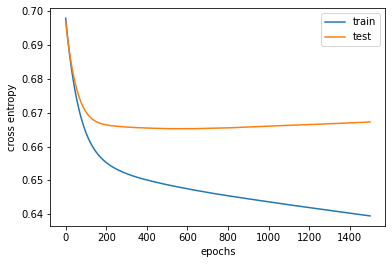

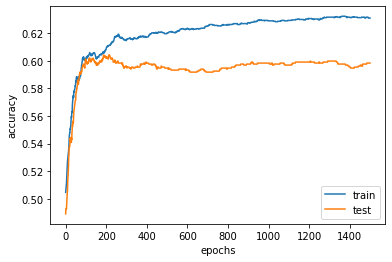

In [104]:
# plot the losses
import matplotlib.pyplot as plt

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [105]:
total = 0
correct = 0
for i in range(Xr_normalized.shape[0]):
    total = total + 1
    y_pred = model.forward(Xr_normalized[i,:]).item()
    y_true = y_labeled[i].item()
    if ((y_pred > .5) and (y_true == 1)) or ((y_pred < .5) and (y_true == 0)):
        correct = correct + 1
print(f'Accuracy of this model on training set: {correct/total}')

Accuracy of this model on training set: 0.6060804899387576


In [106]:
print(f'Accuracy of this model on test set: {best_acc}')

Accuracy of this model on test set: 0.6042274236679077
